In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
raw_data_path = "C:\\Users\\lenovo\\Downloads\\Thesis\\data huawei\\train_data\\train_data.csv"
data_label = pd.read_csv(raw_data_path, usecols = [0], sep = '|')

In [7]:
data_label['label'].value_counts()

0    40461645
1     1445488
Name: label, dtype: int64

In [3]:
data_click = data_label[data_label["label"] == 1]
skip_click_values = list(map(lambda x: x + 1, data_click.index))

data_nonclick = data_label[data_label["label"] == 0]
skip_nonclick_values = list(map(lambda x: x + 1, data_nonclick.index))

del data_label, data_click, data_nonclick

In [8]:
data_click_sample = pd.DataFrame(skip_click_values, columns = ["click"]).sample(n = len(skip_click_values) - 250000).click.tolist()
data_click_sample = sorted(data_click_sample + skip_nonclick_values)

data_click_sample = pd.read_csv(raw_data_path, skiprows = data_click_sample, sep = '|')

In [14]:
data_nonclick_sample = pd.DataFrame(skip_nonclick_values, columns = ["nonclick"]).sample(n = len(skip_nonclick_values) - 1000000).nonclick.tolist()
data_nonclick_sample = sorted(data_nonclick_sample + skip_click_values)

data_nonclick_sample = pd.read_csv(raw_data_path, skiprows = data_nonclick_sample, sep = '|')

In [25]:
data_nonclick = data_nonclick_sample.drop(['label', 'communication_onlinerate'], axis = 1, inplace = False)

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [27]:
np.array(data_nonclick)

array([[1058438,    3466,    5639, ...,       6,      17,       1],
       [1046924,    2621,    2736, ...,      12,      17,       1],
       [1402588,    3365,    5493, ...,      13,      11,       1],
       ...,
       [1794064,    2475,    6282, ...,      13,      17,       7],
       [1807574,    1448,    4758, ...,      10,      18,       7],
       [1231435,    1637,    3323, ...,      10,      17,       7]],
      dtype=int64)

In [29]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(np.array(data_nonclick))

In [30]:
scaled_features

array([[-1.56611057,  0.02047562,  0.97717911, ..., -3.15567242,
        -0.86496149, -1.48726398],
       [-1.59832794, -0.56961361, -0.70943136, ...,  0.52191814,
        -0.86496149, -1.48726398],
       [-0.60314304, -0.05005576,  0.89235474, ...,  1.13484989,
        -1.40726129, -1.48726398],
       ...,
       [ 0.49224757, -0.67156985,  1.3507549 , ...,  1.13484989,
        -0.86496149,  1.49792808],
       [ 0.53004996, -1.38875522,  0.46532798, ..., -0.70394538,
        -0.77457819,  1.49792808],
       [-1.08204695, -1.25677076, -0.36839094, ..., -0.70394538,
        -0.86496149,  1.49792808]])

In [31]:
kmeans = KMeans()
kmeans.fit(scaled_features)

KMeans()

In [33]:
kmeans.n_clusters

8

In [34]:
data_nonclick.index.values

array([     0,      1,      2, ..., 999997, 999998, 999999], dtype=int64)

In [35]:
kmeans.labels_

array([6, 7, 4, ..., 2, 7, 7])

In [37]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = data_nonclick.index.values
cluster_map['cluster'] = kmeans.labels_

In [86]:
data_all = pd.DataFrame()
for i in range(0, 8):
    if i == 4:
        num = 1542
    else:
        num = 35494
    index = cluster_map[cluster_map['cluster'] == i]['data_index'].tolist()
    temp = data_nonclick.iloc[index, :].sample(n = num)
    data_all = pd.concat([data_all, temp], axis = 0)

In [91]:
data_all['label'] = 0

In [94]:
data_click_sample.drop(['communication_onlinerate'], axis = 1, inplace = True)

In [100]:
data_sample = pd.concat([data_all, data_click_sample], axis = 0, sort=True).reset_index().drop(['index'], axis = 1)

In [102]:
data_sample['label'].value_counts()

1    250000
0    250000
Name: label, dtype: int64

In [104]:
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sn

# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, make_scorer, balanced_accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from datetime import datetime

In [105]:
df1 = data_sample.drop(['uid', 'up_membership_grade'], axis = 1, inplace = False)

X = df1.drop(['label'], axis = 1).copy()
y = df1['label'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.25)

In [106]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [108]:
model_lightgbm2 = lgb.LGBMClassifier(seed = 42, objective = 'binary', learning_rate = 0.1, num_leaves = 100, max_depth = 7, n_estimators = 350, reg_alpha = 10, lamda = 0.1)
start_time = timer(None)
model_lightgbm2.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = [(X_test, y_test)])
timer(start_time)

[1]	valid_0's binary_logloss: 0.681813
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.672448
[3]	valid_0's binary_logloss: 0.664877
[4]	valid_0's binary_logloss: 0.6585
[5]	valid_0's binary_logloss: 0.653231
[6]	valid_0's binary_logloss: 0.64891
[7]	valid_0's binary_logloss: 0.64515
[8]	valid_0's binary_logloss: 0.641822
[9]	valid_0's binary_logloss: 0.639108
[10]	valid_0's binary_logloss: 0.636609
[11]	valid_0's binary_logloss: 0.634698
[12]	valid_0's binary_logloss: 0.632844
[13]	valid_0's binary_logloss: 0.631336
[14]	valid_0's binary_logloss: 0.630015
[15]	valid_0's binary_logloss: 0.628916
[16]	valid_0's binary_logloss: 0.627924
[17]	valid_0's binary_logloss: 0.627085
[18]	valid_0's binary_logloss: 0.625976
[19]	valid_0's binary_logloss: 0.625057
[20]	valid_0's binary_logloss: 0.623505
[21]	valid_0's binary_logloss: 0.622466
[22]	valid_0's binary_logloss: 0.621713
[23]	valid_0's binary_logloss: 0.620982
[24]	valid_0's binary_logloss: 0

[203]	valid_0's binary_logloss: 0.599067
[204]	valid_0's binary_logloss: 0.599068
[205]	valid_0's binary_logloss: 0.599035
[206]	valid_0's binary_logloss: 0.599011
[207]	valid_0's binary_logloss: 0.59901
[208]	valid_0's binary_logloss: 0.599
[209]	valid_0's binary_logloss: 0.599
[210]	valid_0's binary_logloss: 0.599
[211]	valid_0's binary_logloss: 0.59898
[212]	valid_0's binary_logloss: 0.598972
[213]	valid_0's binary_logloss: 0.598956
[214]	valid_0's binary_logloss: 0.59892
[215]	valid_0's binary_logloss: 0.598916
[216]	valid_0's binary_logloss: 0.598916
[217]	valid_0's binary_logloss: 0.598892
[218]	valid_0's binary_logloss: 0.598879
[219]	valid_0's binary_logloss: 0.598871
[220]	valid_0's binary_logloss: 0.598859
[221]	valid_0's binary_logloss: 0.598827
[222]	valid_0's binary_logloss: 0.598815
[223]	valid_0's binary_logloss: 0.598808
[224]	valid_0's binary_logloss: 0.598797
[225]	valid_0's binary_logloss: 0.598785
[226]	valid_0's binary_logloss: 0.598779
[227]	valid_0's binary_loglo

In [109]:
y_pred = model_lightgbm2.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
#print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69     62500
           1       0.69      0.65      0.67     62500

    accuracy                           0.68    125000
   macro avg       0.68      0.68      0.68    125000
weighted avg       0.68      0.68      0.68    125000

0.680776
0.6935702170672788
0.647728


NameError: name 'f1_score' is not defined

In [110]:
def GridSearchCV_lightgbm_auc(param_grid):
    optimal_params = GridSearchCV(
        estimator = lgb.LGBMClassifier(seed = 42, objective = 'binary'),
        param_grid = param_grid,
        scoring = 'neg_log_loss',
        verbose = 3,
        n_jobs = 1,
        cv = 5)
    start_time = timer(None)
    optimal_params.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'log_loss', eval_set = [(X_test, y_test)], verbose = True)
    timer(start_time)
    print(optimal_params.best_params_)
    print(optimal_params.best_score_)

In [111]:
params = {
    'learning_rate':[0.05, 0.1, 0.15],
    'n_estimators':[150, 200, 250]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[1]	valid_0's binary_logloss: 0.687484
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.682396
[3]	valid_0's binary_logloss: 0.677789
[4]	valid_0's binary_logloss: 0.673593
[5]	valid_0's binary_logloss: 0.669759
[6]	valid_0's binary_logloss: 0.666245
[7]	valid_0's binary_logloss: 0.663073
[8]	valid_0's binary_logloss: 0.6602
[9]	valid_0's binary_logloss: 0.657594
[10]	valid_0's binary_logloss: 0.655245
[11]	valid_0's binary_logloss: 0.653049
[12]	valid_0's binary_logloss: 0.651023
[13]	valid_0's binary_logloss: 0.649084
[14]	valid_0's binary_logloss: 0.647401
[15]	valid_0's binary_logloss: 0.645725
[16]	valid_0's binary_logloss: 0.644285
[17]	valid_0's binary_logloss: 0.642835
[18]	valid_0's binary_logloss: 0.64154
[19]	valid_0's binary_logloss: 0.640287
[20]	valid_0's binary_logloss: 0.639136
[21]	valid_0's binary_logloss: 0.638078
[22]	valid_0's binary_logloss: 0.637154
[23]	valid_

[49]	valid_0's binary_logloss: 0.621438
[50]	valid_0's binary_logloss: 0.621082
[51]	valid_0's binary_logloss: 0.620835
[52]	valid_0's binary_logloss: 0.620528
[53]	valid_0's binary_logloss: 0.620282
[54]	valid_0's binary_logloss: 0.620019
[55]	valid_0's binary_logloss: 0.619576
[56]	valid_0's binary_logloss: 0.619336
[57]	valid_0's binary_logloss: 0.619147
[58]	valid_0's binary_logloss: 0.618951
[59]	valid_0's binary_logloss: 0.618708
[60]	valid_0's binary_logloss: 0.61849
[61]	valid_0's binary_logloss: 0.618209
[62]	valid_0's binary_logloss: 0.61794
[63]	valid_0's binary_logloss: 0.617716
[64]	valid_0's binary_logloss: 0.617554
[65]	valid_0's binary_logloss: 0.617157
[66]	valid_0's binary_logloss: 0.616916
[67]	valid_0's binary_logloss: 0.61676
[68]	valid_0's binary_logloss: 0.616479
[69]	valid_0's binary_logloss: 0.616137
[70]	valid_0's binary_logloss: 0.615943
[71]	valid_0's binary_logloss: 0.615681
[72]	valid_0's binary_logloss: 0.615431
[73]	valid_0's binary_logloss: 0.615262
[74

[101]	valid_0's binary_logloss: 0.611375
[102]	valid_0's binary_logloss: 0.611246
[103]	valid_0's binary_logloss: 0.611077
[104]	valid_0's binary_logloss: 0.610932
[105]	valid_0's binary_logloss: 0.610815
[106]	valid_0's binary_logloss: 0.610701
[107]	valid_0's binary_logloss: 0.6106
[108]	valid_0's binary_logloss: 0.610489
[109]	valid_0's binary_logloss: 0.610364
[110]	valid_0's binary_logloss: 0.610159
[111]	valid_0's binary_logloss: 0.610069
[112]	valid_0's binary_logloss: 0.610018
[113]	valid_0's binary_logloss: 0.609916
[114]	valid_0's binary_logloss: 0.609821
[115]	valid_0's binary_logloss: 0.609704
[116]	valid_0's binary_logloss: 0.609606
[117]	valid_0's binary_logloss: 0.609514
[118]	valid_0's binary_logloss: 0.609419
[119]	valid_0's binary_logloss: 0.609319
[120]	valid_0's binary_logloss: 0.609157
[121]	valid_0's binary_logloss: 0.609068
[122]	valid_0's binary_logloss: 0.608991
[123]	valid_0's binary_logloss: 0.608948
[124]	valid_0's binary_logloss: 0.608888
[125]	valid_0's bi

[CV 4/5] END ...........learning_rate=0.05, n_estimators=150; total time=   8.8s
[1]	valid_0's binary_logloss: 0.687471
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.682357
[3]	valid_0's binary_logloss: 0.67778
[4]	valid_0's binary_logloss: 0.673605
[5]	valid_0's binary_logloss: 0.669813
[6]	valid_0's binary_logloss: 0.666333
[7]	valid_0's binary_logloss: 0.663187
[8]	valid_0's binary_logloss: 0.66027
[9]	valid_0's binary_logloss: 0.657664
[10]	valid_0's binary_logloss: 0.655224
[11]	valid_0's binary_logloss: 0.65307
[12]	valid_0's binary_logloss: 0.651057
[13]	valid_0's binary_logloss: 0.649238
[14]	valid_0's binary_logloss: 0.647406
[15]	valid_0's binary_logloss: 0.645835
[16]	valid_0's binary_logloss: 0.644318
[17]	valid_0's binary_logloss: 0.642986
[18]	valid_0's binary_logloss: 0.641674
[19]	valid_0's binary_logloss: 0.640456
[20]	valid_0's binary_logloss: 0.639378
[21]	valid_0's binary_logloss: 0.63836
[22]	valid_0's binary_logloss: 

[49]	valid_0's binary_logloss: 0.621661
[50]	valid_0's binary_logloss: 0.621292
[51]	valid_0's binary_logloss: 0.621004
[52]	valid_0's binary_logloss: 0.620787
[53]	valid_0's binary_logloss: 0.620496
[54]	valid_0's binary_logloss: 0.620295
[55]	valid_0's binary_logloss: 0.620009
[56]	valid_0's binary_logloss: 0.619797
[57]	valid_0's binary_logloss: 0.619523
[58]	valid_0's binary_logloss: 0.619307
[59]	valid_0's binary_logloss: 0.619001
[60]	valid_0's binary_logloss: 0.61876
[61]	valid_0's binary_logloss: 0.618543
[62]	valid_0's binary_logloss: 0.618286
[63]	valid_0's binary_logloss: 0.618107
[64]	valid_0's binary_logloss: 0.617841
[65]	valid_0's binary_logloss: 0.617615
[66]	valid_0's binary_logloss: 0.617248
[67]	valid_0's binary_logloss: 0.617054
[68]	valid_0's binary_logloss: 0.616808
[69]	valid_0's binary_logloss: 0.616617
[70]	valid_0's binary_logloss: 0.616462
[71]	valid_0's binary_logloss: 0.61629
[72]	valid_0's binary_logloss: 0.615907
[73]	valid_0's binary_logloss: 0.615613
[7

[48]	valid_0's binary_logloss: 0.621759
[49]	valid_0's binary_logloss: 0.621438
[50]	valid_0's binary_logloss: 0.621082
[51]	valid_0's binary_logloss: 0.620835
[52]	valid_0's binary_logloss: 0.620528
[53]	valid_0's binary_logloss: 0.620282
[54]	valid_0's binary_logloss: 0.620019
[55]	valid_0's binary_logloss: 0.619576
[56]	valid_0's binary_logloss: 0.619336
[57]	valid_0's binary_logloss: 0.619147
[58]	valid_0's binary_logloss: 0.618951
[59]	valid_0's binary_logloss: 0.618708
[60]	valid_0's binary_logloss: 0.61849
[61]	valid_0's binary_logloss: 0.618209
[62]	valid_0's binary_logloss: 0.61794
[63]	valid_0's binary_logloss: 0.617716
[64]	valid_0's binary_logloss: 0.617554
[65]	valid_0's binary_logloss: 0.617157
[66]	valid_0's binary_logloss: 0.616916
[67]	valid_0's binary_logloss: 0.61676
[68]	valid_0's binary_logloss: 0.616479
[69]	valid_0's binary_logloss: 0.616137
[70]	valid_0's binary_logloss: 0.615943
[71]	valid_0's binary_logloss: 0.615681
[72]	valid_0's binary_logloss: 0.615431
[73

[45]	valid_0's binary_logloss: 0.623199
[46]	valid_0's binary_logloss: 0.62285
[47]	valid_0's binary_logloss: 0.622568
[48]	valid_0's binary_logloss: 0.622116
[49]	valid_0's binary_logloss: 0.621804
[50]	valid_0's binary_logloss: 0.621397
[51]	valid_0's binary_logloss: 0.621178
[52]	valid_0's binary_logloss: 0.620931
[53]	valid_0's binary_logloss: 0.620594
[54]	valid_0's binary_logloss: 0.620326
[55]	valid_0's binary_logloss: 0.620076
[56]	valid_0's binary_logloss: 0.619869
[57]	valid_0's binary_logloss: 0.619514
[58]	valid_0's binary_logloss: 0.61927
[59]	valid_0's binary_logloss: 0.618937
[60]	valid_0's binary_logloss: 0.618704
[61]	valid_0's binary_logloss: 0.618454
[62]	valid_0's binary_logloss: 0.61815
[63]	valid_0's binary_logloss: 0.617942
[64]	valid_0's binary_logloss: 0.617703
[65]	valid_0's binary_logloss: 0.617511
[66]	valid_0's binary_logloss: 0.617204
[67]	valid_0's binary_logloss: 0.617032
[68]	valid_0's binary_logloss: 0.616845
[69]	valid_0's binary_logloss: 0.616653
[70

[46]	valid_0's binary_logloss: 0.62257
[47]	valid_0's binary_logloss: 0.622236
[48]	valid_0's binary_logloss: 0.621923
[49]	valid_0's binary_logloss: 0.621634
[50]	valid_0's binary_logloss: 0.621384
[51]	valid_0's binary_logloss: 0.621048
[52]	valid_0's binary_logloss: 0.620587
[53]	valid_0's binary_logloss: 0.620297
[54]	valid_0's binary_logloss: 0.620085
[55]	valid_0's binary_logloss: 0.619807
[56]	valid_0's binary_logloss: 0.619612
[57]	valid_0's binary_logloss: 0.619413
[58]	valid_0's binary_logloss: 0.619099
[59]	valid_0's binary_logloss: 0.618896
[60]	valid_0's binary_logloss: 0.618667
[61]	valid_0's binary_logloss: 0.618489
[62]	valid_0's binary_logloss: 0.618212
[63]	valid_0's binary_logloss: 0.617978
[64]	valid_0's binary_logloss: 0.617813
[65]	valid_0's binary_logloss: 0.617489
[66]	valid_0's binary_logloss: 0.617192
[67]	valid_0's binary_logloss: 0.617037
[68]	valid_0's binary_logloss: 0.616807
[69]	valid_0's binary_logloss: 0.616543
[70]	valid_0's binary_logloss: 0.616341
[

[44]	valid_0's binary_logloss: 0.62336
[45]	valid_0's binary_logloss: 0.622944
[46]	valid_0's binary_logloss: 0.622602
[47]	valid_0's binary_logloss: 0.622286
[48]	valid_0's binary_logloss: 0.62204
[49]	valid_0's binary_logloss: 0.621705
[50]	valid_0's binary_logloss: 0.621402
[51]	valid_0's binary_logloss: 0.621087
[52]	valid_0's binary_logloss: 0.620765
[53]	valid_0's binary_logloss: 0.620463
[54]	valid_0's binary_logloss: 0.620143
[55]	valid_0's binary_logloss: 0.619847
[56]	valid_0's binary_logloss: 0.619585
[57]	valid_0's binary_logloss: 0.619323
[58]	valid_0's binary_logloss: 0.619022
[59]	valid_0's binary_logloss: 0.618821
[60]	valid_0's binary_logloss: 0.618586
[61]	valid_0's binary_logloss: 0.61824
[62]	valid_0's binary_logloss: 0.617964
[63]	valid_0's binary_logloss: 0.617552
[64]	valid_0's binary_logloss: 0.617312
[65]	valid_0's binary_logloss: 0.61711
[66]	valid_0's binary_logloss: 0.616739
[67]	valid_0's binary_logloss: 0.616622
[68]	valid_0's binary_logloss: 0.61645
[69]	

[42]	valid_0's binary_logloss: 0.624178
[43]	valid_0's binary_logloss: 0.623779
[44]	valid_0's binary_logloss: 0.623435
[45]	valid_0's binary_logloss: 0.622944
[46]	valid_0's binary_logloss: 0.622677
[47]	valid_0's binary_logloss: 0.622315
[48]	valid_0's binary_logloss: 0.621925
[49]	valid_0's binary_logloss: 0.621661
[50]	valid_0's binary_logloss: 0.621292
[51]	valid_0's binary_logloss: 0.621004
[52]	valid_0's binary_logloss: 0.620787
[53]	valid_0's binary_logloss: 0.620496
[54]	valid_0's binary_logloss: 0.620295
[55]	valid_0's binary_logloss: 0.620009
[56]	valid_0's binary_logloss: 0.619797
[57]	valid_0's binary_logloss: 0.619523
[58]	valid_0's binary_logloss: 0.619307
[59]	valid_0's binary_logloss: 0.619001
[60]	valid_0's binary_logloss: 0.61876
[61]	valid_0's binary_logloss: 0.618543
[62]	valid_0's binary_logloss: 0.618286
[63]	valid_0's binary_logloss: 0.618107
[64]	valid_0's binary_logloss: 0.617841
[65]	valid_0's binary_logloss: 0.617615
[66]	valid_0's binary_logloss: 0.617248
[

[246]	valid_0's binary_logloss: 0.60389
[247]	valid_0's binary_logloss: 0.603859
[248]	valid_0's binary_logloss: 0.603851
[249]	valid_0's binary_logloss: 0.603842
[250]	valid_0's binary_logloss: 0.603784
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.603784
[CV 1/5] END ...........learning_rate=0.05, n_estimators=250; total time=  15.0s
[1]	valid_0's binary_logloss: 0.6875
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.682401
[3]	valid_0's binary_logloss: 0.677781
[4]	valid_0's binary_logloss: 0.673551
[5]	valid_0's binary_logloss: 0.669732
[6]	valid_0's binary_logloss: 0.666265
[7]	valid_0's binary_logloss: 0.663098
[8]	valid_0's binary_logloss: 0.66024
[9]	valid_0's binary_logloss: 0.657622
[10]	valid_0's binary_logloss: 0.655247
[11]	valid_0's binary_logloss: 0.653004
[12]	valid_0's binary_logloss: 0.65099
[13]	valid_0's binary_logloss: 0.649118
[14]	valid_0's binary_logloss: 0.647275
[15]	valid_0's bin

[196]	valid_0's binary_logloss: 0.605346
[197]	valid_0's binary_logloss: 0.605307
[198]	valid_0's binary_logloss: 0.605293
[199]	valid_0's binary_logloss: 0.605252
[200]	valid_0's binary_logloss: 0.605225
[201]	valid_0's binary_logloss: 0.605172
[202]	valid_0's binary_logloss: 0.605166
[203]	valid_0's binary_logloss: 0.605146
[204]	valid_0's binary_logloss: 0.605142
[205]	valid_0's binary_logloss: 0.605104
[206]	valid_0's binary_logloss: 0.605075
[207]	valid_0's binary_logloss: 0.605042
[208]	valid_0's binary_logloss: 0.605027
[209]	valid_0's binary_logloss: 0.605026
[210]	valid_0's binary_logloss: 0.604981
[211]	valid_0's binary_logloss: 0.604949
[212]	valid_0's binary_logloss: 0.604937
[213]	valid_0's binary_logloss: 0.604914
[214]	valid_0's binary_logloss: 0.604865
[215]	valid_0's binary_logloss: 0.604854
[216]	valid_0's binary_logloss: 0.604848
[217]	valid_0's binary_logloss: 0.604755
[218]	valid_0's binary_logloss: 0.604739
[219]	valid_0's binary_logloss: 0.604718
[220]	valid_0's 

[143]	valid_0's binary_logloss: 0.607492
[144]	valid_0's binary_logloss: 0.607429
[145]	valid_0's binary_logloss: 0.607396
[146]	valid_0's binary_logloss: 0.607339
[147]	valid_0's binary_logloss: 0.607287
[148]	valid_0's binary_logloss: 0.607205
[149]	valid_0's binary_logloss: 0.607172
[150]	valid_0's binary_logloss: 0.607125
[151]	valid_0's binary_logloss: 0.607023
[152]	valid_0's binary_logloss: 0.606957
[153]	valid_0's binary_logloss: 0.606906
[154]	valid_0's binary_logloss: 0.606875
[155]	valid_0's binary_logloss: 0.606801
[156]	valid_0's binary_logloss: 0.606713
[157]	valid_0's binary_logloss: 0.606587
[158]	valid_0's binary_logloss: 0.606531
[159]	valid_0's binary_logloss: 0.606501
[160]	valid_0's binary_logloss: 0.606445
[161]	valid_0's binary_logloss: 0.606405
[162]	valid_0's binary_logloss: 0.606283
[163]	valid_0's binary_logloss: 0.606214
[164]	valid_0's binary_logloss: 0.606194
[165]	valid_0's binary_logloss: 0.606144
[166]	valid_0's binary_logloss: 0.606095
[167]	valid_0's 

[91]	valid_0's binary_logloss: 0.61239
[92]	valid_0's binary_logloss: 0.612252
[93]	valid_0's binary_logloss: 0.612085
[94]	valid_0's binary_logloss: 0.611993
[95]	valid_0's binary_logloss: 0.611839
[96]	valid_0's binary_logloss: 0.611682
[97]	valid_0's binary_logloss: 0.611524
[98]	valid_0's binary_logloss: 0.611383
[99]	valid_0's binary_logloss: 0.611233
[100]	valid_0's binary_logloss: 0.611084
[101]	valid_0's binary_logloss: 0.610955
[102]	valid_0's binary_logloss: 0.610873
[103]	valid_0's binary_logloss: 0.610732
[104]	valid_0's binary_logloss: 0.610592
[105]	valid_0's binary_logloss: 0.610484
[106]	valid_0's binary_logloss: 0.610411
[107]	valid_0's binary_logloss: 0.610322
[108]	valid_0's binary_logloss: 0.610183
[109]	valid_0's binary_logloss: 0.610068
[110]	valid_0's binary_logloss: 0.609944
[111]	valid_0's binary_logloss: 0.609863
[112]	valid_0's binary_logloss: 0.609787
[113]	valid_0's binary_logloss: 0.609673
[114]	valid_0's binary_logloss: 0.609576
[115]	valid_0's binary_log

[37]	valid_0's binary_logloss: 0.6265
[38]	valid_0's binary_logloss: 0.625989
[39]	valid_0's binary_logloss: 0.6254
[40]	valid_0's binary_logloss: 0.624878
[41]	valid_0's binary_logloss: 0.624468
[42]	valid_0's binary_logloss: 0.624096
[43]	valid_0's binary_logloss: 0.623703
[44]	valid_0's binary_logloss: 0.62336
[45]	valid_0's binary_logloss: 0.622944
[46]	valid_0's binary_logloss: 0.622602
[47]	valid_0's binary_logloss: 0.622286
[48]	valid_0's binary_logloss: 0.62204
[49]	valid_0's binary_logloss: 0.621705
[50]	valid_0's binary_logloss: 0.621402
[51]	valid_0's binary_logloss: 0.621087
[52]	valid_0's binary_logloss: 0.620765
[53]	valid_0's binary_logloss: 0.620463
[54]	valid_0's binary_logloss: 0.620143
[55]	valid_0's binary_logloss: 0.619847
[56]	valid_0's binary_logloss: 0.619585
[57]	valid_0's binary_logloss: 0.619323
[58]	valid_0's binary_logloss: 0.619022
[59]	valid_0's binary_logloss: 0.618821
[60]	valid_0's binary_logloss: 0.618586
[61]	valid_0's binary_logloss: 0.61824
[62]	va

[244]	valid_0's binary_logloss: 0.603781
[245]	valid_0's binary_logloss: 0.603763
[246]	valid_0's binary_logloss: 0.603762
[247]	valid_0's binary_logloss: 0.603723
[248]	valid_0's binary_logloss: 0.603656
[249]	valid_0's binary_logloss: 0.603647
[250]	valid_0's binary_logloss: 0.603646
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.603646
[CV 5/5] END ...........learning_rate=0.05, n_estimators=250; total time=  12.4s
[1]	valid_0's binary_logloss: 0.682114
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.673249
[3]	valid_0's binary_logloss: 0.66573
[4]	valid_0's binary_logloss: 0.659676
[5]	valid_0's binary_logloss: 0.654648
[6]	valid_0's binary_logloss: 0.650387
[7]	valid_0's binary_logloss: 0.646681
[8]	valid_0's binary_logloss: 0.643636
[9]	valid_0's binary_logloss: 0.640948
[10]	valid_0's binary_logloss: 0.638514
[11]	valid_0's binary_logloss: 0.636543
[12]	valid_0's binary_logloss: 0.634862
[13]	valid_0

[38]	valid_0's binary_logloss: 0.614791
[39]	valid_0's binary_logloss: 0.614413
[40]	valid_0's binary_logloss: 0.614075
[41]	valid_0's binary_logloss: 0.613725
[42]	valid_0's binary_logloss: 0.61356
[43]	valid_0's binary_logloss: 0.613349
[44]	valid_0's binary_logloss: 0.612974
[45]	valid_0's binary_logloss: 0.612767
[46]	valid_0's binary_logloss: 0.612536
[47]	valid_0's binary_logloss: 0.612254
[48]	valid_0's binary_logloss: 0.612125
[49]	valid_0's binary_logloss: 0.611881
[50]	valid_0's binary_logloss: 0.611292
[51]	valid_0's binary_logloss: 0.611085
[52]	valid_0's binary_logloss: 0.610866
[53]	valid_0's binary_logloss: 0.610557
[54]	valid_0's binary_logloss: 0.610337
[55]	valid_0's binary_logloss: 0.610137
[56]	valid_0's binary_logloss: 0.609914
[57]	valid_0's binary_logloss: 0.609797
[58]	valid_0's binary_logloss: 0.609415
[59]	valid_0's binary_logloss: 0.609311
[60]	valid_0's binary_logloss: 0.60915
[61]	valid_0's binary_logloss: 0.609022
[62]	valid_0's binary_logloss: 0.608839
[6

[92]	valid_0's binary_logloss: 0.605487
[93]	valid_0's binary_logloss: 0.605467
[94]	valid_0's binary_logloss: 0.605301
[95]	valid_0's binary_logloss: 0.605176
[96]	valid_0's binary_logloss: 0.605124
[97]	valid_0's binary_logloss: 0.605055
[98]	valid_0's binary_logloss: 0.604976
[99]	valid_0's binary_logloss: 0.604895
[100]	valid_0's binary_logloss: 0.604871
[101]	valid_0's binary_logloss: 0.604835
[102]	valid_0's binary_logloss: 0.604812
[103]	valid_0's binary_logloss: 0.604763
[104]	valid_0's binary_logloss: 0.604649
[105]	valid_0's binary_logloss: 0.604542
[106]	valid_0's binary_logloss: 0.604519
[107]	valid_0's binary_logloss: 0.604514
[108]	valid_0's binary_logloss: 0.604459
[109]	valid_0's binary_logloss: 0.604377
[110]	valid_0's binary_logloss: 0.604341
[111]	valid_0's binary_logloss: 0.604324
[112]	valid_0's binary_logloss: 0.604294
[113]	valid_0's binary_logloss: 0.6043
[114]	valid_0's binary_logloss: 0.604261
[115]	valid_0's binary_logloss: 0.604209
[116]	valid_0's binary_log

[139]	valid_0's binary_logloss: 0.603387
[140]	valid_0's binary_logloss: 0.603349
[141]	valid_0's binary_logloss: 0.603324
[142]	valid_0's binary_logloss: 0.603239
[143]	valid_0's binary_logloss: 0.6032
[144]	valid_0's binary_logloss: 0.603209
[145]	valid_0's binary_logloss: 0.603151
[146]	valid_0's binary_logloss: 0.603051
[147]	valid_0's binary_logloss: 0.603049
[148]	valid_0's binary_logloss: 0.602984
[149]	valid_0's binary_logloss: 0.602962
[150]	valid_0's binary_logloss: 0.602959
Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.602959
[CV 4/5] END ............learning_rate=0.1, n_estimators=150; total time=   8.0s
[1]	valid_0's binary_logloss: 0.682088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.673159
[3]	valid_0's binary_logloss: 0.665798
[4]	valid_0's binary_logloss: 0.659777
[5]	valid_0's binary_logloss: 0.654742
[6]	valid_0's binary_logloss: 0.650469
[7]	valid_0's binary_logloss: 0.646848
[8]	va

[35]	valid_0's binary_logloss: 0.615917
[36]	valid_0's binary_logloss: 0.615218
[37]	valid_0's binary_logloss: 0.61498
[38]	valid_0's binary_logloss: 0.614695
[39]	valid_0's binary_logloss: 0.614445
[40]	valid_0's binary_logloss: 0.613817
[41]	valid_0's binary_logloss: 0.613531
[42]	valid_0's binary_logloss: 0.613143
[43]	valid_0's binary_logloss: 0.612767
[44]	valid_0's binary_logloss: 0.612502
[45]	valid_0's binary_logloss: 0.61222
[46]	valid_0's binary_logloss: 0.611929
[47]	valid_0's binary_logloss: 0.611777
[48]	valid_0's binary_logloss: 0.611483
[49]	valid_0's binary_logloss: 0.61113
[50]	valid_0's binary_logloss: 0.610886
[51]	valid_0's binary_logloss: 0.610673
[52]	valid_0's binary_logloss: 0.610411
[53]	valid_0's binary_logloss: 0.610124
[54]	valid_0's binary_logloss: 0.609993
[55]	valid_0's binary_logloss: 0.609863
[56]	valid_0's binary_logloss: 0.6097
[57]	valid_0's binary_logloss: 0.609499
[58]	valid_0's binary_logloss: 0.609355
[59]	valid_0's binary_logloss: 0.60913
[60]	v

[32]	valid_0's binary_logloss: 0.61769
[33]	valid_0's binary_logloss: 0.617276
[34]	valid_0's binary_logloss: 0.616479
[35]	valid_0's binary_logloss: 0.616068
[36]	valid_0's binary_logloss: 0.615708
[37]	valid_0's binary_logloss: 0.615117
[38]	valid_0's binary_logloss: 0.614791
[39]	valid_0's binary_logloss: 0.614413
[40]	valid_0's binary_logloss: 0.614075
[41]	valid_0's binary_logloss: 0.613725
[42]	valid_0's binary_logloss: 0.61356
[43]	valid_0's binary_logloss: 0.613349
[44]	valid_0's binary_logloss: 0.612974
[45]	valid_0's binary_logloss: 0.612767
[46]	valid_0's binary_logloss: 0.612536
[47]	valid_0's binary_logloss: 0.612254
[48]	valid_0's binary_logloss: 0.612125
[49]	valid_0's binary_logloss: 0.611881
[50]	valid_0's binary_logloss: 0.611292
[51]	valid_0's binary_logloss: 0.611085
[52]	valid_0's binary_logloss: 0.610866
[53]	valid_0's binary_logloss: 0.610557
[54]	valid_0's binary_logloss: 0.610337
[55]	valid_0's binary_logloss: 0.610137
[56]	valid_0's binary_logloss: 0.609914
[5

[32]	valid_0's binary_logloss: 0.617422
[33]	valid_0's binary_logloss: 0.616929
[34]	valid_0's binary_logloss: 0.616532
[35]	valid_0's binary_logloss: 0.616045
[36]	valid_0's binary_logloss: 0.615645
[37]	valid_0's binary_logloss: 0.615304
[38]	valid_0's binary_logloss: 0.61506
[39]	valid_0's binary_logloss: 0.61474
[40]	valid_0's binary_logloss: 0.614104
[41]	valid_0's binary_logloss: 0.613761
[42]	valid_0's binary_logloss: 0.613434
[43]	valid_0's binary_logloss: 0.6131
[44]	valid_0's binary_logloss: 0.612817
[45]	valid_0's binary_logloss: 0.612468
[46]	valid_0's binary_logloss: 0.612203
[47]	valid_0's binary_logloss: 0.611941
[48]	valid_0's binary_logloss: 0.611673
[49]	valid_0's binary_logloss: 0.61151
[50]	valid_0's binary_logloss: 0.610996
[51]	valid_0's binary_logloss: 0.610814
[52]	valid_0's binary_logloss: 0.610665
[53]	valid_0's binary_logloss: 0.610429
[54]	valid_0's binary_logloss: 0.610202
[55]	valid_0's binary_logloss: 0.610012
[56]	valid_0's binary_logloss: 0.60978
[57]	v

[33]	valid_0's binary_logloss: 0.617075
[34]	valid_0's binary_logloss: 0.616586
[35]	valid_0's binary_logloss: 0.61624
[36]	valid_0's binary_logloss: 0.615491
[37]	valid_0's binary_logloss: 0.614997
[38]	valid_0's binary_logloss: 0.614752
[39]	valid_0's binary_logloss: 0.614433
[40]	valid_0's binary_logloss: 0.6141
[41]	valid_0's binary_logloss: 0.613695
[42]	valid_0's binary_logloss: 0.613225
[43]	valid_0's binary_logloss: 0.612886
[44]	valid_0's binary_logloss: 0.612648
[45]	valid_0's binary_logloss: 0.612501
[46]	valid_0's binary_logloss: 0.612243
[47]	valid_0's binary_logloss: 0.611882
[48]	valid_0's binary_logloss: 0.611698
[49]	valid_0's binary_logloss: 0.61135
[50]	valid_0's binary_logloss: 0.611143
[51]	valid_0's binary_logloss: 0.610611
[52]	valid_0's binary_logloss: 0.610371
[53]	valid_0's binary_logloss: 0.610068
[54]	valid_0's binary_logloss: 0.609927
[55]	valid_0's binary_logloss: 0.6097
[56]	valid_0's binary_logloss: 0.609572
[57]	valid_0's binary_logloss: 0.609417
[58]	v

[32]	valid_0's binary_logloss: 0.617222
[33]	valid_0's binary_logloss: 0.616718
[34]	valid_0's binary_logloss: 0.616215
[35]	valid_0's binary_logloss: 0.615935
[36]	valid_0's binary_logloss: 0.615623
[37]	valid_0's binary_logloss: 0.614979
[38]	valid_0's binary_logloss: 0.614565
[39]	valid_0's binary_logloss: 0.614302
[40]	valid_0's binary_logloss: 0.613931
[41]	valid_0's binary_logloss: 0.613667
[42]	valid_0's binary_logloss: 0.613365
[43]	valid_0's binary_logloss: 0.613086
[44]	valid_0's binary_logloss: 0.612781
[45]	valid_0's binary_logloss: 0.61248
[46]	valid_0's binary_logloss: 0.612239
[47]	valid_0's binary_logloss: 0.611994
[48]	valid_0's binary_logloss: 0.611808
[49]	valid_0's binary_logloss: 0.611381
[50]	valid_0's binary_logloss: 0.611157
[51]	valid_0's binary_logloss: 0.611056
[52]	valid_0's binary_logloss: 0.610749
[53]	valid_0's binary_logloss: 0.610575
[54]	valid_0's binary_logloss: 0.610264
[55]	valid_0's binary_logloss: 0.609944
[56]	valid_0's binary_logloss: 0.609722
[

[30]	valid_0's binary_logloss: 0.61822
[31]	valid_0's binary_logloss: 0.617687
[32]	valid_0's binary_logloss: 0.617379
[33]	valid_0's binary_logloss: 0.616651
[34]	valid_0's binary_logloss: 0.616249
[35]	valid_0's binary_logloss: 0.615917
[36]	valid_0's binary_logloss: 0.615218
[37]	valid_0's binary_logloss: 0.61498
[38]	valid_0's binary_logloss: 0.614695
[39]	valid_0's binary_logloss: 0.614445
[40]	valid_0's binary_logloss: 0.613817
[41]	valid_0's binary_logloss: 0.613531
[42]	valid_0's binary_logloss: 0.613143
[43]	valid_0's binary_logloss: 0.612767
[44]	valid_0's binary_logloss: 0.612502
[45]	valid_0's binary_logloss: 0.61222
[46]	valid_0's binary_logloss: 0.611929
[47]	valid_0's binary_logloss: 0.611777
[48]	valid_0's binary_logloss: 0.611483
[49]	valid_0's binary_logloss: 0.61113
[50]	valid_0's binary_logloss: 0.610886
[51]	valid_0's binary_logloss: 0.610673
[52]	valid_0's binary_logloss: 0.610411
[53]	valid_0's binary_logloss: 0.610124
[54]	valid_0's binary_logloss: 0.609993
[55]

[236]	valid_0's binary_logloss: 0.601825
[237]	valid_0's binary_logloss: 0.60181
[238]	valid_0's binary_logloss: 0.601788
[239]	valid_0's binary_logloss: 0.601788
[240]	valid_0's binary_logloss: 0.601815
[241]	valid_0's binary_logloss: 0.601805
[242]	valid_0's binary_logloss: 0.601805
[243]	valid_0's binary_logloss: 0.601811
[244]	valid_0's binary_logloss: 0.601814
[245]	valid_0's binary_logloss: 0.601816
[246]	valid_0's binary_logloss: 0.601824
[247]	valid_0's binary_logloss: 0.601823
[248]	valid_0's binary_logloss: 0.601822
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.601788
[CV 1/5] END ............learning_rate=0.1, n_estimators=250; total time=  11.6s
[1]	valid_0's binary_logloss: 0.682145
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.67315
[3]	valid_0's binary_logloss: 0.665807
[4]	valid_0's binary_logloss: 0.659721
[5]	valid_0's binary_logloss: 0.654666
[6]	valid_0's binary_logloss: 0.650405
[7]	valid_0's bin

[189]	valid_0's binary_logloss: 0.602156
[190]	valid_0's binary_logloss: 0.602124
[191]	valid_0's binary_logloss: 0.602134
[192]	valid_0's binary_logloss: 0.602084
[193]	valid_0's binary_logloss: 0.602039
[194]	valid_0's binary_logloss: 0.602043
[195]	valid_0's binary_logloss: 0.602035
[196]	valid_0's binary_logloss: 0.602032
[197]	valid_0's binary_logloss: 0.602
[198]	valid_0's binary_logloss: 0.601959
[199]	valid_0's binary_logloss: 0.601949
[200]	valid_0's binary_logloss: 0.601934
[201]	valid_0's binary_logloss: 0.601881
[202]	valid_0's binary_logloss: 0.601874
[203]	valid_0's binary_logloss: 0.601851
[204]	valid_0's binary_logloss: 0.601841
[205]	valid_0's binary_logloss: 0.601834
[206]	valid_0's binary_logloss: 0.601828
[207]	valid_0's binary_logloss: 0.601831
[208]	valid_0's binary_logloss: 0.60184
[209]	valid_0's binary_logloss: 0.601837
[210]	valid_0's binary_logloss: 0.601805
[211]	valid_0's binary_logloss: 0.60178
[212]	valid_0's binary_logloss: 0.60177
[213]	valid_0's binary

[136]	valid_0's binary_logloss: 0.603585
[137]	valid_0's binary_logloss: 0.603543
[138]	valid_0's binary_logloss: 0.603411
[139]	valid_0's binary_logloss: 0.603405
[140]	valid_0's binary_logloss: 0.603391
[141]	valid_0's binary_logloss: 0.603274
[142]	valid_0's binary_logloss: 0.603269
[143]	valid_0's binary_logloss: 0.603253
[144]	valid_0's binary_logloss: 0.603251
[145]	valid_0's binary_logloss: 0.603205
[146]	valid_0's binary_logloss: 0.603201
[147]	valid_0's binary_logloss: 0.603206
[148]	valid_0's binary_logloss: 0.603201
[149]	valid_0's binary_logloss: 0.603191
[150]	valid_0's binary_logloss: 0.603124
[151]	valid_0's binary_logloss: 0.603078
[152]	valid_0's binary_logloss: 0.603081
[153]	valid_0's binary_logloss: 0.60306
[154]	valid_0's binary_logloss: 0.603069
[155]	valid_0's binary_logloss: 0.603041
[156]	valid_0's binary_logloss: 0.602982
[157]	valid_0's binary_logloss: 0.602932
[158]	valid_0's binary_logloss: 0.602876
[159]	valid_0's binary_logloss: 0.602867
[160]	valid_0's b

[85]	valid_0's binary_logloss: 0.605541
[86]	valid_0's binary_logloss: 0.605426
[87]	valid_0's binary_logloss: 0.605359
[88]	valid_0's binary_logloss: 0.605312
[89]	valid_0's binary_logloss: 0.605242
[90]	valid_0's binary_logloss: 0.605162
[91]	valid_0's binary_logloss: 0.60507
[92]	valid_0's binary_logloss: 0.605039
[93]	valid_0's binary_logloss: 0.605027
[94]	valid_0's binary_logloss: 0.605
[95]	valid_0's binary_logloss: 0.604915
[96]	valid_0's binary_logloss: 0.604879
[97]	valid_0's binary_logloss: 0.604826
[98]	valid_0's binary_logloss: 0.604828
[99]	valid_0's binary_logloss: 0.604812
[100]	valid_0's binary_logloss: 0.604729
[101]	valid_0's binary_logloss: 0.604703
[102]	valid_0's binary_logloss: 0.604645
[103]	valid_0's binary_logloss: 0.604571
[104]	valid_0's binary_logloss: 0.604546
[105]	valid_0's binary_logloss: 0.604548
[106]	valid_0's binary_logloss: 0.604549
[107]	valid_0's binary_logloss: 0.604542
[108]	valid_0's binary_logloss: 0.604538
[109]	valid_0's binary_logloss: 0.6

[33]	valid_0's binary_logloss: 0.616718
[34]	valid_0's binary_logloss: 0.616215
[35]	valid_0's binary_logloss: 0.615935
[36]	valid_0's binary_logloss: 0.615623
[37]	valid_0's binary_logloss: 0.614979
[38]	valid_0's binary_logloss: 0.614565
[39]	valid_0's binary_logloss: 0.614302
[40]	valid_0's binary_logloss: 0.613931
[41]	valid_0's binary_logloss: 0.613667
[42]	valid_0's binary_logloss: 0.613365
[43]	valid_0's binary_logloss: 0.613086
[44]	valid_0's binary_logloss: 0.612781
[45]	valid_0's binary_logloss: 0.61248
[46]	valid_0's binary_logloss: 0.612239
[47]	valid_0's binary_logloss: 0.611994
[48]	valid_0's binary_logloss: 0.611808
[49]	valid_0's binary_logloss: 0.611381
[50]	valid_0's binary_logloss: 0.611157
[51]	valid_0's binary_logloss: 0.611056
[52]	valid_0's binary_logloss: 0.610749
[53]	valid_0's binary_logloss: 0.610575
[54]	valid_0's binary_logloss: 0.610264
[55]	valid_0's binary_logloss: 0.609944
[56]	valid_0's binary_logloss: 0.609722
[57]	valid_0's binary_logloss: 0.609407
[

[238]	valid_0's binary_logloss: 0.601505
[239]	valid_0's binary_logloss: 0.601499
[240]	valid_0's binary_logloss: 0.601503
[241]	valid_0's binary_logloss: 0.601482
[242]	valid_0's binary_logloss: 0.60148
[243]	valid_0's binary_logloss: 0.601441
[244]	valid_0's binary_logloss: 0.601426
[245]	valid_0's binary_logloss: 0.601418
[246]	valid_0's binary_logloss: 0.601418
[247]	valid_0's binary_logloss: 0.601408
[248]	valid_0's binary_logloss: 0.601367
[249]	valid_0's binary_logloss: 0.601327
[250]	valid_0's binary_logloss: 0.601339
Did not meet early stopping. Best iteration is:
[249]	valid_0's binary_logloss: 0.601327
[CV 5/5] END ............learning_rate=0.1, n_estimators=250; total time=  11.3s
[1]	valid_0's binary_logloss: 0.677035
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665231
[3]	valid_0's binary_logloss: 0.656525
[4]	valid_0's binary_logloss: 0.649955
[5]	valid_0's binary_logloss: 0.644635
[6]	valid_0's binary_logloss: 0.640745
[7]

[30]	valid_0's binary_logloss: 0.612364
[31]	valid_0's binary_logloss: 0.611713
[32]	valid_0's binary_logloss: 0.611383
[33]	valid_0's binary_logloss: 0.610806
[34]	valid_0's binary_logloss: 0.610639
[35]	valid_0's binary_logloss: 0.610325
[36]	valid_0's binary_logloss: 0.61012
[37]	valid_0's binary_logloss: 0.60979
[38]	valid_0's binary_logloss: 0.609558
[39]	valid_0's binary_logloss: 0.609297
[40]	valid_0's binary_logloss: 0.609097
[41]	valid_0's binary_logloss: 0.60879
[42]	valid_0's binary_logloss: 0.608332
[43]	valid_0's binary_logloss: 0.608155
[44]	valid_0's binary_logloss: 0.60787
[45]	valid_0's binary_logloss: 0.60765
[46]	valid_0's binary_logloss: 0.607539
[47]	valid_0's binary_logloss: 0.607365
[48]	valid_0's binary_logloss: 0.607142
[49]	valid_0's binary_logloss: 0.60701
[50]	valid_0's binary_logloss: 0.60667
[51]	valid_0's binary_logloss: 0.606528
[52]	valid_0's binary_logloss: 0.606392
[53]	valid_0's binary_logloss: 0.606178
[54]	valid_0's binary_logloss: 0.606066
[55]	va

[78]	valid_0's binary_logloss: 0.604477
[79]	valid_0's binary_logloss: 0.604474
[80]	valid_0's binary_logloss: 0.604328
[81]	valid_0's binary_logloss: 0.604261
[82]	valid_0's binary_logloss: 0.604206
[83]	valid_0's binary_logloss: 0.604101
[84]	valid_0's binary_logloss: 0.6041
[85]	valid_0's binary_logloss: 0.604057
[86]	valid_0's binary_logloss: 0.60401
[87]	valid_0's binary_logloss: 0.603905
[88]	valid_0's binary_logloss: 0.603902
[89]	valid_0's binary_logloss: 0.603875
[90]	valid_0's binary_logloss: 0.603837
[91]	valid_0's binary_logloss: 0.603824
[92]	valid_0's binary_logloss: 0.603787
[93]	valid_0's binary_logloss: 0.603652
[94]	valid_0's binary_logloss: 0.603598
[95]	valid_0's binary_logloss: 0.603581
[96]	valid_0's binary_logloss: 0.603578
[97]	valid_0's binary_logloss: 0.603546
[98]	valid_0's binary_logloss: 0.603565
[99]	valid_0's binary_logloss: 0.603515
[100]	valid_0's binary_logloss: 0.603418
[101]	valid_0's binary_logloss: 0.603268
[102]	valid_0's binary_logloss: 0.603247


[133]	valid_0's binary_logloss: 0.602087
[134]	valid_0's binary_logloss: 0.602083
[135]	valid_0's binary_logloss: 0.602066
[136]	valid_0's binary_logloss: 0.602009
[137]	valid_0's binary_logloss: 0.601997
[138]	valid_0's binary_logloss: 0.601957
[139]	valid_0's binary_logloss: 0.601892
[140]	valid_0's binary_logloss: 0.601885
[141]	valid_0's binary_logloss: 0.601892
[142]	valid_0's binary_logloss: 0.6019
[143]	valid_0's binary_logloss: 0.601897
[144]	valid_0's binary_logloss: 0.601892
[145]	valid_0's binary_logloss: 0.601877
[146]	valid_0's binary_logloss: 0.601853
[147]	valid_0's binary_logloss: 0.601801
[148]	valid_0's binary_logloss: 0.601809
[149]	valid_0's binary_logloss: 0.601774
[150]	valid_0's binary_logloss: 0.601779
Did not meet early stopping. Best iteration is:
[149]	valid_0's binary_logloss: 0.601774
[CV 4/5] END ...........learning_rate=0.15, n_estimators=150; total time=   7.7s
[1]	valid_0's binary_logloss: 0.676996
Training until validation scores don't improve for 10 r

[26]	valid_0's binary_logloss: 0.614389
[27]	valid_0's binary_logloss: 0.613777
[28]	valid_0's binary_logloss: 0.613391
[29]	valid_0's binary_logloss: 0.612822
[30]	valid_0's binary_logloss: 0.612271
[31]	valid_0's binary_logloss: 0.611956
[32]	valid_0's binary_logloss: 0.611487
[33]	valid_0's binary_logloss: 0.61123
[34]	valid_0's binary_logloss: 0.610833
[35]	valid_0's binary_logloss: 0.610612
[36]	valid_0's binary_logloss: 0.610329
[37]	valid_0's binary_logloss: 0.610171
[38]	valid_0's binary_logloss: 0.609976
[39]	valid_0's binary_logloss: 0.609615
[40]	valid_0's binary_logloss: 0.609282
[41]	valid_0's binary_logloss: 0.609039
[42]	valid_0's binary_logloss: 0.60874
[43]	valid_0's binary_logloss: 0.608507
[44]	valid_0's binary_logloss: 0.608146
[45]	valid_0's binary_logloss: 0.607926
[46]	valid_0's binary_logloss: 0.607744
[47]	valid_0's binary_logloss: 0.607611
[48]	valid_0's binary_logloss: 0.607425
[49]	valid_0's binary_logloss: 0.607152
[50]	valid_0's binary_logloss: 0.607014
[5

[23]	valid_0's binary_logloss: 0.615823
[24]	valid_0's binary_logloss: 0.615526
[25]	valid_0's binary_logloss: 0.614931
[26]	valid_0's binary_logloss: 0.614202
[27]	valid_0's binary_logloss: 0.613702
[28]	valid_0's binary_logloss: 0.613194
[29]	valid_0's binary_logloss: 0.612553
[30]	valid_0's binary_logloss: 0.612364
[31]	valid_0's binary_logloss: 0.611713
[32]	valid_0's binary_logloss: 0.611383
[33]	valid_0's binary_logloss: 0.610806
[34]	valid_0's binary_logloss: 0.610639
[35]	valid_0's binary_logloss: 0.610325
[36]	valid_0's binary_logloss: 0.61012
[37]	valid_0's binary_logloss: 0.60979
[38]	valid_0's binary_logloss: 0.609558
[39]	valid_0's binary_logloss: 0.609297
[40]	valid_0's binary_logloss: 0.609097
[41]	valid_0's binary_logloss: 0.60879
[42]	valid_0's binary_logloss: 0.608332
[43]	valid_0's binary_logloss: 0.608155
[44]	valid_0's binary_logloss: 0.60787
[45]	valid_0's binary_logloss: 0.60765
[46]	valid_0's binary_logloss: 0.607539
[47]	valid_0's binary_logloss: 0.607365
[48]	

[39]	valid_0's binary_logloss: 0.609652
[40]	valid_0's binary_logloss: 0.609286
[41]	valid_0's binary_logloss: 0.609024
[42]	valid_0's binary_logloss: 0.608893
[43]	valid_0's binary_logloss: 0.608783
[44]	valid_0's binary_logloss: 0.608638
[45]	valid_0's binary_logloss: 0.608405
[46]	valid_0's binary_logloss: 0.60831
[47]	valid_0's binary_logloss: 0.608069
[48]	valid_0's binary_logloss: 0.60789
[49]	valid_0's binary_logloss: 0.607823
[50]	valid_0's binary_logloss: 0.607585
[51]	valid_0's binary_logloss: 0.607441
[52]	valid_0's binary_logloss: 0.607214
[53]	valid_0's binary_logloss: 0.606992
[54]	valid_0's binary_logloss: 0.606871
[55]	valid_0's binary_logloss: 0.606623
[56]	valid_0's binary_logloss: 0.606475
[57]	valid_0's binary_logloss: 0.606238
[58]	valid_0's binary_logloss: 0.606163
[59]	valid_0's binary_logloss: 0.60613
[60]	valid_0's binary_logloss: 0.606114
[61]	valid_0's binary_logloss: 0.60601
[62]	valid_0's binary_logloss: 0.605929
[63]	valid_0's binary_logloss: 0.605687
[64]

[38]	valid_0's binary_logloss: 0.609107
[39]	valid_0's binary_logloss: 0.608838
[40]	valid_0's binary_logloss: 0.608682
[41]	valid_0's binary_logloss: 0.608401
[42]	valid_0's binary_logloss: 0.60827
[43]	valid_0's binary_logloss: 0.608045
[44]	valid_0's binary_logloss: 0.607789
[45]	valid_0's binary_logloss: 0.607546
[46]	valid_0's binary_logloss: 0.607449
[47]	valid_0's binary_logloss: 0.607191
[48]	valid_0's binary_logloss: 0.607091
[49]	valid_0's binary_logloss: 0.606865
[50]	valid_0's binary_logloss: 0.606528
[51]	valid_0's binary_logloss: 0.606403
[52]	valid_0's binary_logloss: 0.606213
[53]	valid_0's binary_logloss: 0.606061
[54]	valid_0's binary_logloss: 0.605842
[55]	valid_0's binary_logloss: 0.605658
[56]	valid_0's binary_logloss: 0.605524
[57]	valid_0's binary_logloss: 0.605487
[58]	valid_0's binary_logloss: 0.605422
[59]	valid_0's binary_logloss: 0.6053
[60]	valid_0's binary_logloss: 0.605212
[61]	valid_0's binary_logloss: 0.605208
[62]	valid_0's binary_logloss: 0.605202
[63

[36]	valid_0's binary_logloss: 0.609911
[37]	valid_0's binary_logloss: 0.609664
[38]	valid_0's binary_logloss: 0.609402
[39]	valid_0's binary_logloss: 0.609021
[40]	valid_0's binary_logloss: 0.608778
[41]	valid_0's binary_logloss: 0.608666
[42]	valid_0's binary_logloss: 0.608358
[43]	valid_0's binary_logloss: 0.608168
[44]	valid_0's binary_logloss: 0.608055
[45]	valid_0's binary_logloss: 0.607887
[46]	valid_0's binary_logloss: 0.607752
[47]	valid_0's binary_logloss: 0.607644
[48]	valid_0's binary_logloss: 0.607528
[49]	valid_0's binary_logloss: 0.607373
[50]	valid_0's binary_logloss: 0.607264
[51]	valid_0's binary_logloss: 0.607103
[52]	valid_0's binary_logloss: 0.606939
[53]	valid_0's binary_logloss: 0.606782
[54]	valid_0's binary_logloss: 0.606631
[55]	valid_0's binary_logloss: 0.606557
[56]	valid_0's binary_logloss: 0.606494
[57]	valid_0's binary_logloss: 0.606392
[58]	valid_0's binary_logloss: 0.606233
[59]	valid_0's binary_logloss: 0.606209
[60]	valid_0's binary_logloss: 0.605968


[35]	valid_0's binary_logloss: 0.610612
[36]	valid_0's binary_logloss: 0.610329
[37]	valid_0's binary_logloss: 0.610171
[38]	valid_0's binary_logloss: 0.609976
[39]	valid_0's binary_logloss: 0.609615
[40]	valid_0's binary_logloss: 0.609282
[41]	valid_0's binary_logloss: 0.609039
[42]	valid_0's binary_logloss: 0.60874
[43]	valid_0's binary_logloss: 0.608507
[44]	valid_0's binary_logloss: 0.608146
[45]	valid_0's binary_logloss: 0.607926
[46]	valid_0's binary_logloss: 0.607744
[47]	valid_0's binary_logloss: 0.607611
[48]	valid_0's binary_logloss: 0.607425
[49]	valid_0's binary_logloss: 0.607152
[50]	valid_0's binary_logloss: 0.607014
[51]	valid_0's binary_logloss: 0.606775
[52]	valid_0's binary_logloss: 0.606746
[53]	valid_0's binary_logloss: 0.606564
[54]	valid_0's binary_logloss: 0.606363
[55]	valid_0's binary_logloss: 0.606211
[56]	valid_0's binary_logloss: 0.605966
[57]	valid_0's binary_logloss: 0.605793
[58]	valid_0's binary_logloss: 0.605767
[59]	valid_0's binary_logloss: 0.605673
[

[6]	valid_0's binary_logloss: 0.640385
[7]	valid_0's binary_logloss: 0.637204
[8]	valid_0's binary_logloss: 0.634503
[9]	valid_0's binary_logloss: 0.632429
[10]	valid_0's binary_logloss: 0.630358
[11]	valid_0's binary_logloss: 0.627867
[12]	valid_0's binary_logloss: 0.625893
[13]	valid_0's binary_logloss: 0.624281
[14]	valid_0's binary_logloss: 0.622831
[15]	valid_0's binary_logloss: 0.621691
[16]	valid_0's binary_logloss: 0.620613
[17]	valid_0's binary_logloss: 0.619937
[18]	valid_0's binary_logloss: 0.619241
[19]	valid_0's binary_logloss: 0.618548
[20]	valid_0's binary_logloss: 0.617922
[21]	valid_0's binary_logloss: 0.6173
[22]	valid_0's binary_logloss: 0.616561
[23]	valid_0's binary_logloss: 0.615823
[24]	valid_0's binary_logloss: 0.615526
[25]	valid_0's binary_logloss: 0.614931
[26]	valid_0's binary_logloss: 0.614202
[27]	valid_0's binary_logloss: 0.613702
[28]	valid_0's binary_logloss: 0.613194
[29]	valid_0's binary_logloss: 0.612553
[30]	valid_0's binary_logloss: 0.612364
[31]	v

[21]	valid_0's binary_logloss: 0.618056
[22]	valid_0's binary_logloss: 0.617565
[23]	valid_0's binary_logloss: 0.616946
[24]	valid_0's binary_logloss: 0.616391
[25]	valid_0's binary_logloss: 0.61539
[26]	valid_0's binary_logloss: 0.614869
[27]	valid_0's binary_logloss: 0.614487
[28]	valid_0's binary_logloss: 0.61386
[29]	valid_0's binary_logloss: 0.613473
[30]	valid_0's binary_logloss: 0.613263
[31]	valid_0's binary_logloss: 0.612774
[32]	valid_0's binary_logloss: 0.612385
[33]	valid_0's binary_logloss: 0.611775
[34]	valid_0's binary_logloss: 0.611189
[35]	valid_0's binary_logloss: 0.610839
[36]	valid_0's binary_logloss: 0.610435
[37]	valid_0's binary_logloss: 0.610127
[38]	valid_0's binary_logloss: 0.609861
[39]	valid_0's binary_logloss: 0.609652
[40]	valid_0's binary_logloss: 0.609286
[41]	valid_0's binary_logloss: 0.609024
[42]	valid_0's binary_logloss: 0.608893
[43]	valid_0's binary_logloss: 0.608783
[44]	valid_0's binary_logloss: 0.608638
[45]	valid_0's binary_logloss: 0.608405
[4

[21]	valid_0's binary_logloss: 0.617478
[22]	valid_0's binary_logloss: 0.616124
[23]	valid_0's binary_logloss: 0.615428
[24]	valid_0's binary_logloss: 0.61486
[25]	valid_0's binary_logloss: 0.614391
[26]	valid_0's binary_logloss: 0.614042
[27]	valid_0's binary_logloss: 0.613348
[28]	valid_0's binary_logloss: 0.612832
[29]	valid_0's binary_logloss: 0.61206
[30]	valid_0's binary_logloss: 0.61163
[31]	valid_0's binary_logloss: 0.611178
[32]	valid_0's binary_logloss: 0.610781
[33]	valid_0's binary_logloss: 0.610524
[34]	valid_0's binary_logloss: 0.610172
[35]	valid_0's binary_logloss: 0.61003
[36]	valid_0's binary_logloss: 0.609736
[37]	valid_0's binary_logloss: 0.609407
[38]	valid_0's binary_logloss: 0.609107
[39]	valid_0's binary_logloss: 0.608838
[40]	valid_0's binary_logloss: 0.608682
[41]	valid_0's binary_logloss: 0.608401
[42]	valid_0's binary_logloss: 0.60827
[43]	valid_0's binary_logloss: 0.608045
[44]	valid_0's binary_logloss: 0.607789
[45]	valid_0's binary_logloss: 0.607546
[46]	

[228]	valid_0's binary_logloss: 0.600935
[229]	valid_0's binary_logloss: 0.600945
Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.600897
[CV 4/5] END ...........learning_rate=0.15, n_estimators=250; total time=  10.2s
[1]	valid_0's binary_logloss: 0.676996
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665279
[3]	valid_0's binary_logloss: 0.656558
[4]	valid_0's binary_logloss: 0.649896
[5]	valid_0's binary_logloss: 0.644619
[6]	valid_0's binary_logloss: 0.640635
[7]	valid_0's binary_logloss: 0.637261
[8]	valid_0's binary_logloss: 0.634689
[9]	valid_0's binary_logloss: 0.632428
[10]	valid_0's binary_logloss: 0.630673
[11]	valid_0's binary_logloss: 0.628401
[12]	valid_0's binary_logloss: 0.626914
[13]	valid_0's binary_logloss: 0.625383
[14]	valid_0's binary_logloss: 0.623839
[15]	valid_0's binary_logloss: 0.622759
[16]	valid_0's binary_logloss: 0.621697
[17]	valid_0's binary_logloss: 0.620753
[18]	valid_0's binary_logloss

[202]	valid_0's binary_logloss: 0.601338
[203]	valid_0's binary_logloss: 0.601334
[204]	valid_0's binary_logloss: 0.601326
[205]	valid_0's binary_logloss: 0.601296
[206]	valid_0's binary_logloss: 0.601302
[207]	valid_0's binary_logloss: 0.601279
[208]	valid_0's binary_logloss: 0.601262
[209]	valid_0's binary_logloss: 0.601272
[210]	valid_0's binary_logloss: 0.60127
[211]	valid_0's binary_logloss: 0.601174
[212]	valid_0's binary_logloss: 0.601125
[213]	valid_0's binary_logloss: 0.601148
[214]	valid_0's binary_logloss: 0.60115
[215]	valid_0's binary_logloss: 0.601133
[216]	valid_0's binary_logloss: 0.601107
[217]	valid_0's binary_logloss: 0.601106
[218]	valid_0's binary_logloss: 0.601122
[219]	valid_0's binary_logloss: 0.601112
[220]	valid_0's binary_logloss: 0.601134
[221]	valid_0's binary_logloss: 0.601151
[222]	valid_0's binary_logloss: 0.601158
[223]	valid_0's binary_logloss: 0.60116
[224]	valid_0's binary_logloss: 0.601155
[225]	valid_0's binary_logloss: 0.601151
[226]	valid_0's bin

[175]	valid_0's binary_logloss: 0.600406
[176]	valid_0's binary_logloss: 0.60042
[177]	valid_0's binary_logloss: 0.600422
[178]	valid_0's binary_logloss: 0.600397
[179]	valid_0's binary_logloss: 0.600398
[180]	valid_0's binary_logloss: 0.600395
[181]	valid_0's binary_logloss: 0.600375
[182]	valid_0's binary_logloss: 0.600358
[183]	valid_0's binary_logloss: 0.600342
[184]	valid_0's binary_logloss: 0.600341
[185]	valid_0's binary_logloss: 0.600337
[186]	valid_0's binary_logloss: 0.600302
[187]	valid_0's binary_logloss: 0.600267
[188]	valid_0's binary_logloss: 0.600245
[189]	valid_0's binary_logloss: 0.600223
[190]	valid_0's binary_logloss: 0.600218
[191]	valid_0's binary_logloss: 0.600224
[192]	valid_0's binary_logloss: 0.600232
[193]	valid_0's binary_logloss: 0.600227
[194]	valid_0's binary_logloss: 0.600215
[195]	valid_0's binary_logloss: 0.600199
[196]	valid_0's binary_logloss: 0.600183
[197]	valid_0's binary_logloss: 0.600189
[198]	valid_0's binary_logloss: 0.600189
[199]	valid_0's b

In [112]:
params = {
    'learning_rate':[0.15, 0.2],
    'n_estimators':[250, 300, 350]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[1]	valid_0's binary_logloss: 0.677035
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665231
[3]	valid_0's binary_logloss: 0.656525
[4]	valid_0's binary_logloss: 0.649955
[5]	valid_0's binary_logloss: 0.644635
[6]	valid_0's binary_logloss: 0.640745
[7]	valid_0's binary_logloss: 0.637359
[8]	valid_0's binary_logloss: 0.634753
[9]	valid_0's binary_logloss: 0.632598
[10]	valid_0's binary_logloss: 0.630772
[11]	valid_0's binary_logloss: 0.628629
[12]	valid_0's binary_logloss: 0.626837
[13]	valid_0's binary_logloss: 0.625127
[14]	valid_0's binary_logloss: 0.623974
[15]	valid_0's binary_logloss: 0.622764
[16]	valid_0's binary_logloss: 0.621845
[17]	valid_0's binary_logloss: 0.620955
[18]	valid_0's binary_logloss: 0.619926
[19]	valid_0's binary_logloss: 0.619427
[20]	valid_0's binary_logloss: 0.618559
[21]	valid_0's binary_logloss: 0.617612
[22]	valid_0's binary_logloss: 0.617084
[23]	val

[200]	valid_0's binary_logloss: 0.601036
[201]	valid_0's binary_logloss: 0.601012
[202]	valid_0's binary_logloss: 0.600985
[203]	valid_0's binary_logloss: 0.600925
[204]	valid_0's binary_logloss: 0.600939
[205]	valid_0's binary_logloss: 0.600904
[206]	valid_0's binary_logloss: 0.600905
[207]	valid_0's binary_logloss: 0.600911
[208]	valid_0's binary_logloss: 0.60089
[209]	valid_0's binary_logloss: 0.600894
[210]	valid_0's binary_logloss: 0.600864
[211]	valid_0's binary_logloss: 0.600841
[212]	valid_0's binary_logloss: 0.600835
[213]	valid_0's binary_logloss: 0.600829
[214]	valid_0's binary_logloss: 0.600789
[215]	valid_0's binary_logloss: 0.600775
[216]	valid_0's binary_logloss: 0.600791
[217]	valid_0's binary_logloss: 0.600781
[218]	valid_0's binary_logloss: 0.600764
[219]	valid_0's binary_logloss: 0.600753
[220]	valid_0's binary_logloss: 0.600759
[221]	valid_0's binary_logloss: 0.60076
[222]	valid_0's binary_logloss: 0.600767
[223]	valid_0's binary_logloss: 0.600779
[224]	valid_0's bi

[172]	valid_0's binary_logloss: 0.601524
[173]	valid_0's binary_logloss: 0.601514
[174]	valid_0's binary_logloss: 0.601503
[175]	valid_0's binary_logloss: 0.601503
[176]	valid_0's binary_logloss: 0.601514
[177]	valid_0's binary_logloss: 0.60151
[178]	valid_0's binary_logloss: 0.601512
[179]	valid_0's binary_logloss: 0.601522
[180]	valid_0's binary_logloss: 0.601544
[181]	valid_0's binary_logloss: 0.601546
[182]	valid_0's binary_logloss: 0.601539
[183]	valid_0's binary_logloss: 0.601543
[184]	valid_0's binary_logloss: 0.601538
[185]	valid_0's binary_logloss: 0.601552
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.601503
[CV 2/5] END ...........learning_rate=0.15, n_estimators=250; total time=   9.7s
[1]	valid_0's binary_logloss: 0.677022
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665111
[3]	valid_0's binary_logloss: 0.656441
[4]	valid_0's binary_logloss: 0.649892
[5]	valid_0's binary_logloss: 0.644743
[6]	valid_0's 

[189]	valid_0's binary_logloss: 0.601389
[190]	valid_0's binary_logloss: 0.601384
[191]	valid_0's binary_logloss: 0.60141
[192]	valid_0's binary_logloss: 0.601422
[193]	valid_0's binary_logloss: 0.601419
[194]	valid_0's binary_logloss: 0.601433
[195]	valid_0's binary_logloss: 0.601434
[196]	valid_0's binary_logloss: 0.601442
[197]	valid_0's binary_logloss: 0.60144
[198]	valid_0's binary_logloss: 0.601446
[199]	valid_0's binary_logloss: 0.601434
[200]	valid_0's binary_logloss: 0.601425
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.601384
[CV 3/5] END ...........learning_rate=0.15, n_estimators=250; total time=  10.1s
[1]	valid_0's binary_logloss: 0.677101
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665385
[3]	valid_0's binary_logloss: 0.656563
[4]	valid_0's binary_logloss: 0.649922
[5]	valid_0's binary_logloss: 0.644726
[6]	valid_0's binary_logloss: 0.640618
[7]	valid_0's binary_logloss: 0.637267
[8]	valid_0's binar

[187]	valid_0's binary_logloss: 0.601249
[188]	valid_0's binary_logloss: 0.601259
[189]	valid_0's binary_logloss: 0.601261
[190]	valid_0's binary_logloss: 0.601228
[191]	valid_0's binary_logloss: 0.601221
[192]	valid_0's binary_logloss: 0.601209
[193]	valid_0's binary_logloss: 0.60121
[194]	valid_0's binary_logloss: 0.601181
[195]	valid_0's binary_logloss: 0.601189
[196]	valid_0's binary_logloss: 0.601166
[197]	valid_0's binary_logloss: 0.601164
[198]	valid_0's binary_logloss: 0.601163
[199]	valid_0's binary_logloss: 0.601102
[200]	valid_0's binary_logloss: 0.60111
[201]	valid_0's binary_logloss: 0.601123
[202]	valid_0's binary_logloss: 0.601087
[203]	valid_0's binary_logloss: 0.601085
[204]	valid_0's binary_logloss: 0.601081
[205]	valid_0's binary_logloss: 0.601066
[206]	valid_0's binary_logloss: 0.601039
[207]	valid_0's binary_logloss: 0.601005
[208]	valid_0's binary_logloss: 0.600967
[209]	valid_0's binary_logloss: 0.600973
[210]	valid_0's binary_logloss: 0.600982
[211]	valid_0's bi

[160]	valid_0's binary_logloss: 0.601937
[161]	valid_0's binary_logloss: 0.60193
[162]	valid_0's binary_logloss: 0.601942
[163]	valid_0's binary_logloss: 0.601944
[164]	valid_0's binary_logloss: 0.601891
[165]	valid_0's binary_logloss: 0.60185
[166]	valid_0's binary_logloss: 0.601813
[167]	valid_0's binary_logloss: 0.60183
[168]	valid_0's binary_logloss: 0.601827
[169]	valid_0's binary_logloss: 0.601833
[170]	valid_0's binary_logloss: 0.601726
[171]	valid_0's binary_logloss: 0.601711
[172]	valid_0's binary_logloss: 0.601704
[173]	valid_0's binary_logloss: 0.601684
[174]	valid_0's binary_logloss: 0.601696
[175]	valid_0's binary_logloss: 0.601654
[176]	valid_0's binary_logloss: 0.601646
[177]	valid_0's binary_logloss: 0.601651
[178]	valid_0's binary_logloss: 0.601648
[179]	valid_0's binary_logloss: 0.601645
[180]	valid_0's binary_logloss: 0.601652
[181]	valid_0's binary_logloss: 0.601657
[182]	valid_0's binary_logloss: 0.601668
[183]	valid_0's binary_logloss: 0.601595
[184]	valid_0's bin

[133]	valid_0's binary_logloss: 0.602245
[134]	valid_0's binary_logloss: 0.602239
[135]	valid_0's binary_logloss: 0.60221
[136]	valid_0's binary_logloss: 0.602206
[137]	valid_0's binary_logloss: 0.602146
[138]	valid_0's binary_logloss: 0.602137
[139]	valid_0's binary_logloss: 0.602127
[140]	valid_0's binary_logloss: 0.602051
[141]	valid_0's binary_logloss: 0.602049
[142]	valid_0's binary_logloss: 0.602023
[143]	valid_0's binary_logloss: 0.6019
[144]	valid_0's binary_logloss: 0.601902
[145]	valid_0's binary_logloss: 0.601909
[146]	valid_0's binary_logloss: 0.601918
[147]	valid_0's binary_logloss: 0.601923
[148]	valid_0's binary_logloss: 0.601859
[149]	valid_0's binary_logloss: 0.601775
[150]	valid_0's binary_logloss: 0.601754
[151]	valid_0's binary_logloss: 0.601759
[152]	valid_0's binary_logloss: 0.601751
[153]	valid_0's binary_logloss: 0.601737
[154]	valid_0's binary_logloss: 0.601718
[155]	valid_0's binary_logloss: 0.601738
[156]	valid_0's binary_logloss: 0.60174
[157]	valid_0's bina

[105]	valid_0's binary_logloss: 0.60294
[106]	valid_0's binary_logloss: 0.602922
[107]	valid_0's binary_logloss: 0.602911
[108]	valid_0's binary_logloss: 0.602858
[109]	valid_0's binary_logloss: 0.60278
[110]	valid_0's binary_logloss: 0.602776
[111]	valid_0's binary_logloss: 0.602774
[112]	valid_0's binary_logloss: 0.602772
[113]	valid_0's binary_logloss: 0.602765
[114]	valid_0's binary_logloss: 0.60274
[115]	valid_0's binary_logloss: 0.602718
[116]	valid_0's binary_logloss: 0.602698
[117]	valid_0's binary_logloss: 0.602661
[118]	valid_0's binary_logloss: 0.602662
[119]	valid_0's binary_logloss: 0.602673
[120]	valid_0's binary_logloss: 0.602608
[121]	valid_0's binary_logloss: 0.602615
[122]	valid_0's binary_logloss: 0.602566
[123]	valid_0's binary_logloss: 0.602575
[124]	valid_0's binary_logloss: 0.602582
[125]	valid_0's binary_logloss: 0.602544
[126]	valid_0's binary_logloss: 0.602507
[127]	valid_0's binary_logloss: 0.602515
[128]	valid_0's binary_logloss: 0.602491
[129]	valid_0's bin

[122]	valid_0's binary_logloss: 0.60276
[123]	valid_0's binary_logloss: 0.602683
[124]	valid_0's binary_logloss: 0.602652
[125]	valid_0's binary_logloss: 0.602631
[126]	valid_0's binary_logloss: 0.60254
[127]	valid_0's binary_logloss: 0.602533
[128]	valid_0's binary_logloss: 0.602543
[129]	valid_0's binary_logloss: 0.602456
[130]	valid_0's binary_logloss: 0.602451
[131]	valid_0's binary_logloss: 0.602362
[132]	valid_0's binary_logloss: 0.602337
[133]	valid_0's binary_logloss: 0.602363
[134]	valid_0's binary_logloss: 0.602336
[135]	valid_0's binary_logloss: 0.602349
[136]	valid_0's binary_logloss: 0.602315
[137]	valid_0's binary_logloss: 0.602267
[138]	valid_0's binary_logloss: 0.602278
[139]	valid_0's binary_logloss: 0.602289
[140]	valid_0's binary_logloss: 0.602261
[141]	valid_0's binary_logloss: 0.602264
[142]	valid_0's binary_logloss: 0.602244
[143]	valid_0's binary_logloss: 0.602256
[144]	valid_0's binary_logloss: 0.602256
[145]	valid_0's binary_logloss: 0.602139
[146]	valid_0's bi

[123]	valid_0's binary_logloss: 0.602156
[124]	valid_0's binary_logloss: 0.602147
[125]	valid_0's binary_logloss: 0.602119
[126]	valid_0's binary_logloss: 0.602135
[127]	valid_0's binary_logloss: 0.602121
[128]	valid_0's binary_logloss: 0.602111
[129]	valid_0's binary_logloss: 0.6021
[130]	valid_0's binary_logloss: 0.602113
[131]	valid_0's binary_logloss: 0.6021
[132]	valid_0's binary_logloss: 0.602089
[133]	valid_0's binary_logloss: 0.602087
[134]	valid_0's binary_logloss: 0.602083
[135]	valid_0's binary_logloss: 0.602066
[136]	valid_0's binary_logloss: 0.602009
[137]	valid_0's binary_logloss: 0.601997
[138]	valid_0's binary_logloss: 0.601957
[139]	valid_0's binary_logloss: 0.601892
[140]	valid_0's binary_logloss: 0.601885
[141]	valid_0's binary_logloss: 0.601892
[142]	valid_0's binary_logloss: 0.6019
[143]	valid_0's binary_logloss: 0.601897
[144]	valid_0's binary_logloss: 0.601892
[145]	valid_0's binary_logloss: 0.601877
[146]	valid_0's binary_logloss: 0.601853
[147]	valid_0's binary

[97]	valid_0's binary_logloss: 0.603376
[98]	valid_0's binary_logloss: 0.603381
[99]	valid_0's binary_logloss: 0.603347
[100]	valid_0's binary_logloss: 0.60321
[101]	valid_0's binary_logloss: 0.603202
[102]	valid_0's binary_logloss: 0.603189
[103]	valid_0's binary_logloss: 0.603168
[104]	valid_0's binary_logloss: 0.603159
[105]	valid_0's binary_logloss: 0.603119
[106]	valid_0's binary_logloss: 0.603075
[107]	valid_0's binary_logloss: 0.603063
[108]	valid_0's binary_logloss: 0.603064
[109]	valid_0's binary_logloss: 0.602977
[110]	valid_0's binary_logloss: 0.602994
[111]	valid_0's binary_logloss: 0.603002
[112]	valid_0's binary_logloss: 0.603
[113]	valid_0's binary_logloss: 0.602988
[114]	valid_0's binary_logloss: 0.602897
[115]	valid_0's binary_logloss: 0.602906
[116]	valid_0's binary_logloss: 0.602896
[117]	valid_0's binary_logloss: 0.602891
[118]	valid_0's binary_logloss: 0.602894
[119]	valid_0's binary_logloss: 0.602908
[120]	valid_0's binary_logloss: 0.602881
[121]	valid_0's binary_

[71]	valid_0's binary_logloss: 0.604643
[72]	valid_0's binary_logloss: 0.604536
[73]	valid_0's binary_logloss: 0.604527
[74]	valid_0's binary_logloss: 0.604528
[75]	valid_0's binary_logloss: 0.604511
[76]	valid_0's binary_logloss: 0.604484
[77]	valid_0's binary_logloss: 0.604404
[78]	valid_0's binary_logloss: 0.6044
[79]	valid_0's binary_logloss: 0.604383
[80]	valid_0's binary_logloss: 0.604214
[81]	valid_0's binary_logloss: 0.604059
[82]	valid_0's binary_logloss: 0.603971
[83]	valid_0's binary_logloss: 0.603947
[84]	valid_0's binary_logloss: 0.603925
[85]	valid_0's binary_logloss: 0.603819
[86]	valid_0's binary_logloss: 0.603734
[87]	valid_0's binary_logloss: 0.603707
[88]	valid_0's binary_logloss: 0.603685
[89]	valid_0's binary_logloss: 0.603649
[90]	valid_0's binary_logloss: 0.603591
[91]	valid_0's binary_logloss: 0.603467
[92]	valid_0's binary_logloss: 0.603435
[93]	valid_0's binary_logloss: 0.603437
[94]	valid_0's binary_logloss: 0.603373
[95]	valid_0's binary_logloss: 0.603378
[9

[41]	valid_0's binary_logloss: 0.60879
[42]	valid_0's binary_logloss: 0.608332
[43]	valid_0's binary_logloss: 0.608155
[44]	valid_0's binary_logloss: 0.60787
[45]	valid_0's binary_logloss: 0.60765
[46]	valid_0's binary_logloss: 0.607539
[47]	valid_0's binary_logloss: 0.607365
[48]	valid_0's binary_logloss: 0.607142
[49]	valid_0's binary_logloss: 0.60701
[50]	valid_0's binary_logloss: 0.60667
[51]	valid_0's binary_logloss: 0.606528
[52]	valid_0's binary_logloss: 0.606392
[53]	valid_0's binary_logloss: 0.606178
[54]	valid_0's binary_logloss: 0.606066
[55]	valid_0's binary_logloss: 0.605836
[56]	valid_0's binary_logloss: 0.605667
[57]	valid_0's binary_logloss: 0.605634
[58]	valid_0's binary_logloss: 0.605578
[59]	valid_0's binary_logloss: 0.605364
[60]	valid_0's binary_logloss: 0.605253
[61]	valid_0's binary_logloss: 0.605202
[62]	valid_0's binary_logloss: 0.605096
[63]	valid_0's binary_logloss: 0.605018
[64]	valid_0's binary_logloss: 0.604985
[65]	valid_0's binary_logloss: 0.604852
[66]	

[57]	valid_0's binary_logloss: 0.606238
[58]	valid_0's binary_logloss: 0.606163
[59]	valid_0's binary_logloss: 0.60613
[60]	valid_0's binary_logloss: 0.606114
[61]	valid_0's binary_logloss: 0.60601
[62]	valid_0's binary_logloss: 0.605929
[63]	valid_0's binary_logloss: 0.605687
[64]	valid_0's binary_logloss: 0.605495
[65]	valid_0's binary_logloss: 0.605313
[66]	valid_0's binary_logloss: 0.605278
[67]	valid_0's binary_logloss: 0.605268
[68]	valid_0's binary_logloss: 0.605148
[69]	valid_0's binary_logloss: 0.605132
[70]	valid_0's binary_logloss: 0.605106
[71]	valid_0's binary_logloss: 0.605063
[72]	valid_0's binary_logloss: 0.604951
[73]	valid_0's binary_logloss: 0.604834
[74]	valid_0's binary_logloss: 0.604859
[75]	valid_0's binary_logloss: 0.60473
[76]	valid_0's binary_logloss: 0.604638
[77]	valid_0's binary_logloss: 0.60455
[78]	valid_0's binary_logloss: 0.604477
[79]	valid_0's binary_logloss: 0.604474
[80]	valid_0's binary_logloss: 0.604328
[81]	valid_0's binary_logloss: 0.604261
[82]

[58]	valid_0's binary_logloss: 0.605422
[59]	valid_0's binary_logloss: 0.6053
[60]	valid_0's binary_logloss: 0.605212
[61]	valid_0's binary_logloss: 0.605208
[62]	valid_0's binary_logloss: 0.605202
[63]	valid_0's binary_logloss: 0.60517
[64]	valid_0's binary_logloss: 0.604992
[65]	valid_0's binary_logloss: 0.604951
[66]	valid_0's binary_logloss: 0.604931
[67]	valid_0's binary_logloss: 0.604827
[68]	valid_0's binary_logloss: 0.604644
[69]	valid_0's binary_logloss: 0.604534
[70]	valid_0's binary_logloss: 0.604457
[71]	valid_0's binary_logloss: 0.604432
[72]	valid_0's binary_logloss: 0.604439
[73]	valid_0's binary_logloss: 0.604311
[74]	valid_0's binary_logloss: 0.604262
[75]	valid_0's binary_logloss: 0.604232
[76]	valid_0's binary_logloss: 0.604213
[77]	valid_0's binary_logloss: 0.604114
[78]	valid_0's binary_logloss: 0.604112
[79]	valid_0's binary_logloss: 0.604121
[80]	valid_0's binary_logloss: 0.604104
[81]	valid_0's binary_logloss: 0.603988
[82]	valid_0's binary_logloss: 0.604001
[83

[29]	valid_0's binary_logloss: 0.612328
[30]	valid_0's binary_logloss: 0.611898
[31]	valid_0's binary_logloss: 0.611741
[32]	valid_0's binary_logloss: 0.611404
[33]	valid_0's binary_logloss: 0.610885
[34]	valid_0's binary_logloss: 0.610573
[35]	valid_0's binary_logloss: 0.610244
[36]	valid_0's binary_logloss: 0.609911
[37]	valid_0's binary_logloss: 0.609664
[38]	valid_0's binary_logloss: 0.609402
[39]	valid_0's binary_logloss: 0.609021
[40]	valid_0's binary_logloss: 0.608778
[41]	valid_0's binary_logloss: 0.608666
[42]	valid_0's binary_logloss: 0.608358
[43]	valid_0's binary_logloss: 0.608168
[44]	valid_0's binary_logloss: 0.608055
[45]	valid_0's binary_logloss: 0.607887
[46]	valid_0's binary_logloss: 0.607752
[47]	valid_0's binary_logloss: 0.607644
[48]	valid_0's binary_logloss: 0.607528
[49]	valid_0's binary_logloss: 0.607373
[50]	valid_0's binary_logloss: 0.607264
[51]	valid_0's binary_logloss: 0.607103
[52]	valid_0's binary_logloss: 0.606939
[53]	valid_0's binary_logloss: 0.606782


[1]	valid_0's binary_logloss: 0.672248
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.658521
[3]	valid_0's binary_logloss: 0.649291
[4]	valid_0's binary_logloss: 0.642644
[5]	valid_0's binary_logloss: 0.637939
[6]	valid_0's binary_logloss: 0.634199
[7]	valid_0's binary_logloss: 0.631598
[8]	valid_0's binary_logloss: 0.629463
[9]	valid_0's binary_logloss: 0.626612
[10]	valid_0's binary_logloss: 0.624509
[11]	valid_0's binary_logloss: 0.623263
[12]	valid_0's binary_logloss: 0.622043
[13]	valid_0's binary_logloss: 0.620853
[14]	valid_0's binary_logloss: 0.619363
[15]	valid_0's binary_logloss: 0.618385
[16]	valid_0's binary_logloss: 0.617492
[17]	valid_0's binary_logloss: 0.616249
[18]	valid_0's binary_logloss: 0.615228
[19]	valid_0's binary_logloss: 0.614648
[20]	valid_0's binary_logloss: 0.61431
[21]	valid_0's binary_logloss: 0.613711
[22]	valid_0's binary_logloss: 0.61316
[23]	valid_0's binary_logloss: 0.612534
[24]	valid_0's binary_logloss:

[54]	valid_0's binary_logloss: 0.60489
[55]	valid_0's binary_logloss: 0.604721
[56]	valid_0's binary_logloss: 0.604681
[57]	valid_0's binary_logloss: 0.604697
[58]	valid_0's binary_logloss: 0.604694
[59]	valid_0's binary_logloss: 0.60461
[60]	valid_0's binary_logloss: 0.604583
[61]	valid_0's binary_logloss: 0.6045
[62]	valid_0's binary_logloss: 0.604471
[63]	valid_0's binary_logloss: 0.604431
[64]	valid_0's binary_logloss: 0.604351
[65]	valid_0's binary_logloss: 0.604158
[66]	valid_0's binary_logloss: 0.604147
[67]	valid_0's binary_logloss: 0.604095
[68]	valid_0's binary_logloss: 0.604111
[69]	valid_0's binary_logloss: 0.60389
[70]	valid_0's binary_logloss: 0.60382
[71]	valid_0's binary_logloss: 0.603793
[72]	valid_0's binary_logloss: 0.603773
[73]	valid_0's binary_logloss: 0.603749
[74]	valid_0's binary_logloss: 0.603744
[75]	valid_0's binary_logloss: 0.60374
[76]	valid_0's binary_logloss: 0.603739
[77]	valid_0's binary_logloss: 0.603723
[78]	valid_0's binary_logloss: 0.603661
[79]	va

[100]	valid_0's binary_logloss: 0.602508
[101]	valid_0's binary_logloss: 0.602509
[102]	valid_0's binary_logloss: 0.602472
[103]	valid_0's binary_logloss: 0.602494
[104]	valid_0's binary_logloss: 0.602492
[105]	valid_0's binary_logloss: 0.60249
[106]	valid_0's binary_logloss: 0.602397
[107]	valid_0's binary_logloss: 0.602407
[108]	valid_0's binary_logloss: 0.602388
[109]	valid_0's binary_logloss: 0.602358
[110]	valid_0's binary_logloss: 0.602351
[111]	valid_0's binary_logloss: 0.602331
[112]	valid_0's binary_logloss: 0.602267
[113]	valid_0's binary_logloss: 0.602239
[114]	valid_0's binary_logloss: 0.602245
[115]	valid_0's binary_logloss: 0.602263
[116]	valid_0's binary_logloss: 0.602268
[117]	valid_0's binary_logloss: 0.602257
[118]	valid_0's binary_logloss: 0.602272
[119]	valid_0's binary_logloss: 0.602297
[120]	valid_0's binary_logloss: 0.602225
[121]	valid_0's binary_logloss: 0.602241
[122]	valid_0's binary_logloss: 0.602244
[123]	valid_0's binary_logloss: 0.602259
[124]	valid_0's b

[CV 4/5] END ............learning_rate=0.2, n_estimators=250; total time=   7.3s
[1]	valid_0's binary_logloss: 0.672195
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.658568
[3]	valid_0's binary_logloss: 0.649394
[4]	valid_0's binary_logloss: 0.642631
[5]	valid_0's binary_logloss: 0.638026
[6]	valid_0's binary_logloss: 0.634359
[7]	valid_0's binary_logloss: 0.631409
[8]	valid_0's binary_logloss: 0.627894
[9]	valid_0's binary_logloss: 0.625552
[10]	valid_0's binary_logloss: 0.623754
[11]	valid_0's binary_logloss: 0.622438
[12]	valid_0's binary_logloss: 0.621054
[13]	valid_0's binary_logloss: 0.619954
[14]	valid_0's binary_logloss: 0.618975
[15]	valid_0's binary_logloss: 0.618202
[16]	valid_0's binary_logloss: 0.617265
[17]	valid_0's binary_logloss: 0.615883
[18]	valid_0's binary_logloss: 0.61505
[19]	valid_0's binary_logloss: 0.614143
[20]	valid_0's binary_logloss: 0.613737
[21]	valid_0's binary_logloss: 0.613303
[22]	valid_0's binary_loglos

[35]	valid_0's binary_logloss: 0.607347
[36]	valid_0's binary_logloss: 0.607117
[37]	valid_0's binary_logloss: 0.606981
[38]	valid_0's binary_logloss: 0.606757
[39]	valid_0's binary_logloss: 0.60646
[40]	valid_0's binary_logloss: 0.606218
[41]	valid_0's binary_logloss: 0.606078
[42]	valid_0's binary_logloss: 0.606015
[43]	valid_0's binary_logloss: 0.605854
[44]	valid_0's binary_logloss: 0.605585
[45]	valid_0's binary_logloss: 0.605528
[46]	valid_0's binary_logloss: 0.605418
[47]	valid_0's binary_logloss: 0.605394
[48]	valid_0's binary_logloss: 0.605366
[49]	valid_0's binary_logloss: 0.605217
[50]	valid_0's binary_logloss: 0.605053
[51]	valid_0's binary_logloss: 0.604847
[52]	valid_0's binary_logloss: 0.604773
[53]	valid_0's binary_logloss: 0.604798
[54]	valid_0's binary_logloss: 0.604645
[55]	valid_0's binary_logloss: 0.60457
[56]	valid_0's binary_logloss: 0.60432
[57]	valid_0's binary_logloss: 0.604299
[58]	valid_0's binary_logloss: 0.604215
[59]	valid_0's binary_logloss: 0.604147
[60

[92]	valid_0's binary_logloss: 0.602981
[93]	valid_0's binary_logloss: 0.602901
[94]	valid_0's binary_logloss: 0.602893
[95]	valid_0's binary_logloss: 0.602873
[96]	valid_0's binary_logloss: 0.602781
[97]	valid_0's binary_logloss: 0.602701
[98]	valid_0's binary_logloss: 0.602652
[99]	valid_0's binary_logloss: 0.602671
[100]	valid_0's binary_logloss: 0.602683
[101]	valid_0's binary_logloss: 0.602631
[102]	valid_0's binary_logloss: 0.602618
[103]	valid_0's binary_logloss: 0.602579
[104]	valid_0's binary_logloss: 0.602595
[105]	valid_0's binary_logloss: 0.602589
[106]	valid_0's binary_logloss: 0.602599
[107]	valid_0's binary_logloss: 0.602605
[108]	valid_0's binary_logloss: 0.602616
[109]	valid_0's binary_logloss: 0.602604
[110]	valid_0's binary_logloss: 0.602629
[111]	valid_0's binary_logloss: 0.602609
[112]	valid_0's binary_logloss: 0.602573
[113]	valid_0's binary_logloss: 0.602549
[114]	valid_0's binary_logloss: 0.602568
[115]	valid_0's binary_logloss: 0.602555
[116]	valid_0's binary_l

[CV 3/5] END ............learning_rate=0.2, n_estimators=300; total time=   6.5s
[1]	valid_0's binary_logloss: 0.672332
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.658526
[3]	valid_0's binary_logloss: 0.649444
[4]	valid_0's binary_logloss: 0.642754
[5]	valid_0's binary_logloss: 0.637954
[6]	valid_0's binary_logloss: 0.634233
[7]	valid_0's binary_logloss: 0.631617
[8]	valid_0's binary_logloss: 0.628497
[9]	valid_0's binary_logloss: 0.626528
[10]	valid_0's binary_logloss: 0.623997
[11]	valid_0's binary_logloss: 0.622189
[12]	valid_0's binary_logloss: 0.621004
[13]	valid_0's binary_logloss: 0.620066
[14]	valid_0's binary_logloss: 0.618755
[15]	valid_0's binary_logloss: 0.617939
[16]	valid_0's binary_logloss: 0.616478
[17]	valid_0's binary_logloss: 0.615569
[18]	valid_0's binary_logloss: 0.614869
[19]	valid_0's binary_logloss: 0.614363
[20]	valid_0's binary_logloss: 0.612927
[21]	valid_0's binary_logloss: 0.612279
[22]	valid_0's binary_loglo

[35]	valid_0's binary_logloss: 0.607333
[36]	valid_0's binary_logloss: 0.607102
[37]	valid_0's binary_logloss: 0.606839
[38]	valid_0's binary_logloss: 0.606708
[39]	valid_0's binary_logloss: 0.606353
[40]	valid_0's binary_logloss: 0.606093
[41]	valid_0's binary_logloss: 0.605953
[42]	valid_0's binary_logloss: 0.605618
[43]	valid_0's binary_logloss: 0.605433
[44]	valid_0's binary_logloss: 0.605301
[45]	valid_0's binary_logloss: 0.605076
[46]	valid_0's binary_logloss: 0.605028
[47]	valid_0's binary_logloss: 0.604858
[48]	valid_0's binary_logloss: 0.604733
[49]	valid_0's binary_logloss: 0.604687
[50]	valid_0's binary_logloss: 0.604629
[51]	valid_0's binary_logloss: 0.604603
[52]	valid_0's binary_logloss: 0.604503
[53]	valid_0's binary_logloss: 0.604432
[54]	valid_0's binary_logloss: 0.604273
[55]	valid_0's binary_logloss: 0.604273
[56]	valid_0's binary_logloss: 0.604317
[57]	valid_0's binary_logloss: 0.604277
[58]	valid_0's binary_logloss: 0.604262
[59]	valid_0's binary_logloss: 0.604194


[70]	valid_0's binary_logloss: 0.603079
[71]	valid_0's binary_logloss: 0.603069
[72]	valid_0's binary_logloss: 0.602978
[73]	valid_0's binary_logloss: 0.602932
[74]	valid_0's binary_logloss: 0.602873
[75]	valid_0's binary_logloss: 0.602892
[76]	valid_0's binary_logloss: 0.602871
[77]	valid_0's binary_logloss: 0.602875
[78]	valid_0's binary_logloss: 0.60287
[79]	valid_0's binary_logloss: 0.602757
[80]	valid_0's binary_logloss: 0.602745
[81]	valid_0's binary_logloss: 0.602737
[82]	valid_0's binary_logloss: 0.602735
[83]	valid_0's binary_logloss: 0.602735
[84]	valid_0's binary_logloss: 0.602728
[85]	valid_0's binary_logloss: 0.602622
[86]	valid_0's binary_logloss: 0.602577
[87]	valid_0's binary_logloss: 0.602528
[88]	valid_0's binary_logloss: 0.602491
[89]	valid_0's binary_logloss: 0.602353
[90]	valid_0's binary_logloss: 0.602358
[91]	valid_0's binary_logloss: 0.602353
[92]	valid_0's binary_logloss: 0.602343
[93]	valid_0's binary_logloss: 0.602327
[94]	valid_0's binary_logloss: 0.602348
[

[126]	valid_0's binary_logloss: 0.602492
[127]	valid_0's binary_logloss: 0.602471
[128]	valid_0's binary_logloss: 0.602472
[129]	valid_0's binary_logloss: 0.602455
[130]	valid_0's binary_logloss: 0.602456
[131]	valid_0's binary_logloss: 0.60242
[132]	valid_0's binary_logloss: 0.60243
[133]	valid_0's binary_logloss: 0.602428
[134]	valid_0's binary_logloss: 0.602435
[135]	valid_0's binary_logloss: 0.602468
[136]	valid_0's binary_logloss: 0.60245
[137]	valid_0's binary_logloss: 0.602374
[138]	valid_0's binary_logloss: 0.602381
[139]	valid_0's binary_logloss: 0.602365
[140]	valid_0's binary_logloss: 0.602302
[141]	valid_0's binary_logloss: 0.602289
[142]	valid_0's binary_logloss: 0.602252
[143]	valid_0's binary_logloss: 0.602233
[144]	valid_0's binary_logloss: 0.602237
[145]	valid_0's binary_logloss: 0.602234
[146]	valid_0's binary_logloss: 0.60227
[147]	valid_0's binary_logloss: 0.602275
[148]	valid_0's binary_logloss: 0.602271
[149]	valid_0's binary_logloss: 0.602262
[150]	valid_0's bina

[28]	valid_0's binary_logloss: 0.608955
[29]	valid_0's binary_logloss: 0.608654
[30]	valid_0's binary_logloss: 0.608166
[31]	valid_0's binary_logloss: 0.608027
[32]	valid_0's binary_logloss: 0.607871
[33]	valid_0's binary_logloss: 0.607483
[34]	valid_0's binary_logloss: 0.607246
[35]	valid_0's binary_logloss: 0.607044
[36]	valid_0's binary_logloss: 0.606877
[37]	valid_0's binary_logloss: 0.606651
[38]	valid_0's binary_logloss: 0.606465
[39]	valid_0's binary_logloss: 0.606312
[40]	valid_0's binary_logloss: 0.606084
[41]	valid_0's binary_logloss: 0.605878
[42]	valid_0's binary_logloss: 0.605746
[43]	valid_0's binary_logloss: 0.605546
[44]	valid_0's binary_logloss: 0.605412
[45]	valid_0's binary_logloss: 0.605414
[46]	valid_0's binary_logloss: 0.605326
[47]	valid_0's binary_logloss: 0.604973
[48]	valid_0's binary_logloss: 0.6048
[49]	valid_0's binary_logloss: 0.60473
[50]	valid_0's binary_logloss: 0.604674
[51]	valid_0's binary_logloss: 0.604587
[52]	valid_0's binary_logloss: 0.604569
[53

[65]	valid_0's binary_logloss: 0.603575
[66]	valid_0's binary_logloss: 0.603574
[67]	valid_0's binary_logloss: 0.603332
[68]	valid_0's binary_logloss: 0.603231
[69]	valid_0's binary_logloss: 0.603192
[70]	valid_0's binary_logloss: 0.603127
[71]	valid_0's binary_logloss: 0.603104
[72]	valid_0's binary_logloss: 0.603071
[73]	valid_0's binary_logloss: 0.603045
[74]	valid_0's binary_logloss: 0.602965
[75]	valid_0's binary_logloss: 0.602943
[76]	valid_0's binary_logloss: 0.602943
[77]	valid_0's binary_logloss: 0.602939
[78]	valid_0's binary_logloss: 0.602822
[79]	valid_0's binary_logloss: 0.602793
[80]	valid_0's binary_logloss: 0.602803
[81]	valid_0's binary_logloss: 0.60279
[82]	valid_0's binary_logloss: 0.602706
[83]	valid_0's binary_logloss: 0.602727
[84]	valid_0's binary_logloss: 0.60273
[85]	valid_0's binary_logloss: 0.602671
[86]	valid_0's binary_logloss: 0.602569
[87]	valid_0's binary_logloss: 0.602471
[88]	valid_0's binary_logloss: 0.602437
[89]	valid_0's binary_logloss: 0.602437
[9

[101]	valid_0's binary_logloss: 0.602255
[102]	valid_0's binary_logloss: 0.602196
[103]	valid_0's binary_logloss: 0.602168
[104]	valid_0's binary_logloss: 0.602068
[105]	valid_0's binary_logloss: 0.602069
[106]	valid_0's binary_logloss: 0.602058
[107]	valid_0's binary_logloss: 0.602036
[108]	valid_0's binary_logloss: 0.601993
[109]	valid_0's binary_logloss: 0.601946
[110]	valid_0's binary_logloss: 0.601847
[111]	valid_0's binary_logloss: 0.601843
[112]	valid_0's binary_logloss: 0.60183
[113]	valid_0's binary_logloss: 0.601811
[114]	valid_0's binary_logloss: 0.601764
[115]	valid_0's binary_logloss: 0.601736
[116]	valid_0's binary_logloss: 0.601735
[117]	valid_0's binary_logloss: 0.601718
[118]	valid_0's binary_logloss: 0.601735
[119]	valid_0's binary_logloss: 0.60174
[120]	valid_0's binary_logloss: 0.601733
[121]	valid_0's binary_logloss: 0.601698
[122]	valid_0's binary_logloss: 0.601679
[123]	valid_0's binary_logloss: 0.601563
[124]	valid_0's binary_logloss: 0.601562
[125]	valid_0's bi

In [113]:
params = {
    'learning_rate':[0.15],
    'n_estimators':[250],
    'max_depth':[7, 9, 11],
    'num_leaves':[100, 125, 150]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[1]	valid_0's binary_logloss: 0.676694
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.664322
[3]	valid_0's binary_logloss: 0.655093
[4]	valid_0's binary_logloss: 0.648151
[5]	valid_0's binary_logloss: 0.642622
[6]	valid_0's binary_logloss: 0.638046
[7]	valid_0's binary_logloss: 0.634927
[8]	valid_0's binary_logloss: 0.632079
[9]	valid_0's binary_logloss: 0.630091
[10]	valid_0's binary_logloss: 0.628285
[11]	valid_0's binary_logloss: 0.626405
[12]	valid_0's binary_logloss: 0.625236
[13]	valid_0's binary_logloss: 0.623566
[14]	valid_0's binary_logloss: 0.622253
[15]	valid_0's binary_logloss: 0.620452
[16]	valid_0's binary_logloss: 0.619742
[17]	valid_0's binary_logloss: 0.618496
[18]	valid_0's binary_logloss: 0.617779
[19]	valid_0's binary_logloss: 0.617217
[20]	valid_0's binary_logloss: 0.616646
[21]	valid_0's binary_logloss: 0.616095
[22]	valid_0's binary_logloss: 0.615474
[23]	val

[27]	valid_0's binary_logloss: 0.612812
[28]	valid_0's binary_logloss: 0.612535
[29]	valid_0's binary_logloss: 0.612087
[30]	valid_0's binary_logloss: 0.611889
[31]	valid_0's binary_logloss: 0.611542
[32]	valid_0's binary_logloss: 0.611438
[33]	valid_0's binary_logloss: 0.610827
[34]	valid_0's binary_logloss: 0.610172
[35]	valid_0's binary_logloss: 0.609362
[36]	valid_0's binary_logloss: 0.60902
[37]	valid_0's binary_logloss: 0.608724
[38]	valid_0's binary_logloss: 0.608437
[39]	valid_0's binary_logloss: 0.608284
[40]	valid_0's binary_logloss: 0.607846
[41]	valid_0's binary_logloss: 0.607508
[42]	valid_0's binary_logloss: 0.60734
[43]	valid_0's binary_logloss: 0.607207
[44]	valid_0's binary_logloss: 0.607073
[45]	valid_0's binary_logloss: 0.606976
[46]	valid_0's binary_logloss: 0.60691
[47]	valid_0's binary_logloss: 0.606827
[48]	valid_0's binary_logloss: 0.606657
[49]	valid_0's binary_logloss: 0.606115
[50]	valid_0's binary_logloss: 0.606003
[51]	valid_0's binary_logloss: 0.605948
[52

[76]	valid_0's binary_logloss: 0.602499
[77]	valid_0's binary_logloss: 0.602405
[78]	valid_0's binary_logloss: 0.602408
[79]	valid_0's binary_logloss: 0.602329
[80]	valid_0's binary_logloss: 0.602162
[81]	valid_0's binary_logloss: 0.602126
[82]	valid_0's binary_logloss: 0.602128
[83]	valid_0's binary_logloss: 0.602056
[84]	valid_0's binary_logloss: 0.602029
[85]	valid_0's binary_logloss: 0.601993
[86]	valid_0's binary_logloss: 0.60198
[87]	valid_0's binary_logloss: 0.601994
[88]	valid_0's binary_logloss: 0.601985
[89]	valid_0's binary_logloss: 0.601955
[90]	valid_0's binary_logloss: 0.601941
[91]	valid_0's binary_logloss: 0.601919
[92]	valid_0's binary_logloss: 0.601897
[93]	valid_0's binary_logloss: 0.601905
[94]	valid_0's binary_logloss: 0.601779
[95]	valid_0's binary_logloss: 0.60173
[96]	valid_0's binary_logloss: 0.601706
[97]	valid_0's binary_logloss: 0.601613
[98]	valid_0's binary_logloss: 0.60155
[99]	valid_0's binary_logloss: 0.601522
[100]	valid_0's binary_logloss: 0.601495
[1

[128]	valid_0's binary_logloss: 0.600678
[129]	valid_0's binary_logloss: 0.600678
[130]	valid_0's binary_logloss: 0.600687
[131]	valid_0's binary_logloss: 0.600674
[132]	valid_0's binary_logloss: 0.600621
[133]	valid_0's binary_logloss: 0.600617
[134]	valid_0's binary_logloss: 0.600591
[135]	valid_0's binary_logloss: 0.600559
[136]	valid_0's binary_logloss: 0.600538
[137]	valid_0's binary_logloss: 0.600519
[138]	valid_0's binary_logloss: 0.600545
[139]	valid_0's binary_logloss: 0.600536
[140]	valid_0's binary_logloss: 0.600542
[141]	valid_0's binary_logloss: 0.600579
[142]	valid_0's binary_logloss: 0.600525
[143]	valid_0's binary_logloss: 0.600522
[144]	valid_0's binary_logloss: 0.600544
[145]	valid_0's binary_logloss: 0.600525
[146]	valid_0's binary_logloss: 0.600562
[147]	valid_0's binary_logloss: 0.600528
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.600519
[CV 4/5] END learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100; total time=   8.1s
[1]	v

[20]	valid_0's binary_logloss: 0.617016
[21]	valid_0's binary_logloss: 0.616334
[22]	valid_0's binary_logloss: 0.615941
[23]	valid_0's binary_logloss: 0.615157
[24]	valid_0's binary_logloss: 0.614907
[25]	valid_0's binary_logloss: 0.614267
[26]	valid_0's binary_logloss: 0.613717
[27]	valid_0's binary_logloss: 0.613298
[28]	valid_0's binary_logloss: 0.612905
[29]	valid_0's binary_logloss: 0.612179
[30]	valid_0's binary_logloss: 0.611837
[31]	valid_0's binary_logloss: 0.611414
[32]	valid_0's binary_logloss: 0.610881
[33]	valid_0's binary_logloss: 0.610491
[34]	valid_0's binary_logloss: 0.610123
[35]	valid_0's binary_logloss: 0.609774
[36]	valid_0's binary_logloss: 0.608961
[37]	valid_0's binary_logloss: 0.608597
[38]	valid_0's binary_logloss: 0.608175
[39]	valid_0's binary_logloss: 0.608014
[40]	valid_0's binary_logloss: 0.607509
[41]	valid_0's binary_logloss: 0.607319
[42]	valid_0's binary_logloss: 0.607217
[43]	valid_0's binary_logloss: 0.60701
[44]	valid_0's binary_logloss: 0.606824
[

[84]	valid_0's binary_logloss: 0.602492
[85]	valid_0's binary_logloss: 0.602455
[86]	valid_0's binary_logloss: 0.602451
[87]	valid_0's binary_logloss: 0.60235
[88]	valid_0's binary_logloss: 0.602282
[89]	valid_0's binary_logloss: 0.602297
[90]	valid_0's binary_logloss: 0.602251
[91]	valid_0's binary_logloss: 0.602162
[92]	valid_0's binary_logloss: 0.60206
[93]	valid_0's binary_logloss: 0.601975
[94]	valid_0's binary_logloss: 0.601838
[95]	valid_0's binary_logloss: 0.601846
[96]	valid_0's binary_logloss: 0.601763
[97]	valid_0's binary_logloss: 0.601704
[98]	valid_0's binary_logloss: 0.601661
[99]	valid_0's binary_logloss: 0.601632
[100]	valid_0's binary_logloss: 0.601597
[101]	valid_0's binary_logloss: 0.601554
[102]	valid_0's binary_logloss: 0.601582
[103]	valid_0's binary_logloss: 0.601604
[104]	valid_0's binary_logloss: 0.601541
[105]	valid_0's binary_logloss: 0.601558
[106]	valid_0's binary_logloss: 0.601543
[107]	valid_0's binary_logloss: 0.601511
[108]	valid_0's binary_logloss: 0.

[120]	valid_0's binary_logloss: 0.601378
[121]	valid_0's binary_logloss: 0.60139
[122]	valid_0's binary_logloss: 0.601272
[123]	valid_0's binary_logloss: 0.601277
[124]	valid_0's binary_logloss: 0.601253
[125]	valid_0's binary_logloss: 0.601271
[126]	valid_0's binary_logloss: 0.601257
[127]	valid_0's binary_logloss: 0.601275
[128]	valid_0's binary_logloss: 0.601246
[129]	valid_0's binary_logloss: 0.601255
[130]	valid_0's binary_logloss: 0.601216
[131]	valid_0's binary_logloss: 0.601241
[132]	valid_0's binary_logloss: 0.601237
[133]	valid_0's binary_logloss: 0.601177
[134]	valid_0's binary_logloss: 0.601183
[135]	valid_0's binary_logloss: 0.601132
[136]	valid_0's binary_logloss: 0.601144
[137]	valid_0's binary_logloss: 0.601153
[138]	valid_0's binary_logloss: 0.601088
[139]	valid_0's binary_logloss: 0.601057
[140]	valid_0's binary_logloss: 0.600978
[141]	valid_0's binary_logloss: 0.600916
[142]	valid_0's binary_logloss: 0.600924
[143]	valid_0's binary_logloss: 0.600945
[144]	valid_0's b

[14]	valid_0's binary_logloss: 0.622137
[15]	valid_0's binary_logloss: 0.621055
[16]	valid_0's binary_logloss: 0.619535
[17]	valid_0's binary_logloss: 0.618567
[18]	valid_0's binary_logloss: 0.617858
[19]	valid_0's binary_logloss: 0.616897
[20]	valid_0's binary_logloss: 0.616217
[21]	valid_0's binary_logloss: 0.615565
[22]	valid_0's binary_logloss: 0.615154
[23]	valid_0's binary_logloss: 0.614643
[24]	valid_0's binary_logloss: 0.613871
[25]	valid_0's binary_logloss: 0.613591
[26]	valid_0's binary_logloss: 0.613204
[27]	valid_0's binary_logloss: 0.612893
[28]	valid_0's binary_logloss: 0.612587
[29]	valid_0's binary_logloss: 0.612047
[30]	valid_0's binary_logloss: 0.611788
[31]	valid_0's binary_logloss: 0.611447
[32]	valid_0's binary_logloss: 0.610827
[33]	valid_0's binary_logloss: 0.610624
[34]	valid_0's binary_logloss: 0.610324
[35]	valid_0's binary_logloss: 0.61021
[36]	valid_0's binary_logloss: 0.609948
[37]	valid_0's binary_logloss: 0.609796
[38]	valid_0's binary_logloss: 0.609636
[

[48]	valid_0's binary_logloss: 0.606127
[49]	valid_0's binary_logloss: 0.605968
[50]	valid_0's binary_logloss: 0.605687
[51]	valid_0's binary_logloss: 0.605657
[52]	valid_0's binary_logloss: 0.605411
[53]	valid_0's binary_logloss: 0.60521
[54]	valid_0's binary_logloss: 0.605023
[55]	valid_0's binary_logloss: 0.604861
[56]	valid_0's binary_logloss: 0.604822
[57]	valid_0's binary_logloss: 0.604727
[58]	valid_0's binary_logloss: 0.604434
[59]	valid_0's binary_logloss: 0.604146
[60]	valid_0's binary_logloss: 0.603924
[61]	valid_0's binary_logloss: 0.603898
[62]	valid_0's binary_logloss: 0.603793
[63]	valid_0's binary_logloss: 0.603705
[64]	valid_0's binary_logloss: 0.603695
[65]	valid_0's binary_logloss: 0.603661
[66]	valid_0's binary_logloss: 0.603377
[67]	valid_0's binary_logloss: 0.603326
[68]	valid_0's binary_logloss: 0.603156
[69]	valid_0's binary_logloss: 0.603147
[70]	valid_0's binary_logloss: 0.603106
[71]	valid_0's binary_logloss: 0.602941
[72]	valid_0's binary_logloss: 0.602831
[

[109]	valid_0's binary_logloss: 0.601431
[110]	valid_0's binary_logloss: 0.601437
[111]	valid_0's binary_logloss: 0.601458
[112]	valid_0's binary_logloss: 0.60129
[113]	valid_0's binary_logloss: 0.601279
[114]	valid_0's binary_logloss: 0.601251
[115]	valid_0's binary_logloss: 0.601272
[116]	valid_0's binary_logloss: 0.601267
[117]	valid_0's binary_logloss: 0.601269
[118]	valid_0's binary_logloss: 0.601253
[119]	valid_0's binary_logloss: 0.601216
[120]	valid_0's binary_logloss: 0.601212
[121]	valid_0's binary_logloss: 0.601214
[122]	valid_0's binary_logloss: 0.601218
[123]	valid_0's binary_logloss: 0.601206
[124]	valid_0's binary_logloss: 0.601199
[125]	valid_0's binary_logloss: 0.601175
[126]	valid_0's binary_logloss: 0.601185
[127]	valid_0's binary_logloss: 0.601211
[128]	valid_0's binary_logloss: 0.601065
[129]	valid_0's binary_logloss: 0.601062
[130]	valid_0's binary_logloss: 0.60104
[131]	valid_0's binary_logloss: 0.601052
[132]	valid_0's binary_logloss: 0.601042
[133]	valid_0's bi

[143]	valid_0's binary_logloss: 0.600945
[144]	valid_0's binary_logloss: 0.600926
[145]	valid_0's binary_logloss: 0.60094
[146]	valid_0's binary_logloss: 0.600962
[147]	valid_0's binary_logloss: 0.600933
[148]	valid_0's binary_logloss: 0.600912
[149]	valid_0's binary_logloss: 0.600938
[150]	valid_0's binary_logloss: 0.601003
[151]	valid_0's binary_logloss: 0.601006
[152]	valid_0's binary_logloss: 0.60099
[153]	valid_0's binary_logloss: 0.601004
[154]	valid_0's binary_logloss: 0.600953
[155]	valid_0's binary_logloss: 0.600934
[156]	valid_0's binary_logloss: 0.600935
[157]	valid_0's binary_logloss: 0.600907
[158]	valid_0's binary_logloss: 0.600889
[159]	valid_0's binary_logloss: 0.600876
[160]	valid_0's binary_logloss: 0.600889
[161]	valid_0's binary_logloss: 0.600909
[162]	valid_0's binary_logloss: 0.600859
[163]	valid_0's binary_logloss: 0.60085
[164]	valid_0's binary_logloss: 0.600832
[165]	valid_0's binary_logloss: 0.600846
[166]	valid_0's binary_logloss: 0.600838
[167]	valid_0's bin

[39]	valid_0's binary_logloss: 0.608016
[40]	valid_0's binary_logloss: 0.607808
[41]	valid_0's binary_logloss: 0.607575
[42]	valid_0's binary_logloss: 0.607445
[43]	valid_0's binary_logloss: 0.607044
[44]	valid_0's binary_logloss: 0.606939
[45]	valid_0's binary_logloss: 0.606586
[46]	valid_0's binary_logloss: 0.606529
[47]	valid_0's binary_logloss: 0.606073
[48]	valid_0's binary_logloss: 0.605923
[49]	valid_0's binary_logloss: 0.605868
[50]	valid_0's binary_logloss: 0.605702
[51]	valid_0's binary_logloss: 0.605325
[52]	valid_0's binary_logloss: 0.605029
[53]	valid_0's binary_logloss: 0.604967
[54]	valid_0's binary_logloss: 0.604958
[55]	valid_0's binary_logloss: 0.604859
[56]	valid_0's binary_logloss: 0.604688
[57]	valid_0's binary_logloss: 0.604386
[58]	valid_0's binary_logloss: 0.604194
[59]	valid_0's binary_logloss: 0.603981
[60]	valid_0's binary_logloss: 0.603982
[61]	valid_0's binary_logloss: 0.603969
[62]	valid_0's binary_logloss: 0.603935
[63]	valid_0's binary_logloss: 0.603824


[106]	valid_0's binary_logloss: 0.600555
[107]	valid_0's binary_logloss: 0.600614
[108]	valid_0's binary_logloss: 0.600551
[109]	valid_0's binary_logloss: 0.600557
[110]	valid_0's binary_logloss: 0.600584
[111]	valid_0's binary_logloss: 0.600548
[112]	valid_0's binary_logloss: 0.600554
[113]	valid_0's binary_logloss: 0.600594
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.600521
[CV 1/5] END learning_rate=0.15, max_depth=9, n_estimators=250, num_leaves=100; total time=   7.5s
[1]	valid_0's binary_logloss: 0.675573
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.662607
[3]	valid_0's binary_logloss: 0.652832
[4]	valid_0's binary_logloss: 0.645349
[5]	valid_0's binary_logloss: 0.639093
[6]	valid_0's binary_logloss: 0.634663
[7]	valid_0's binary_logloss: 0.63099
[8]	valid_0's binary_logloss: 0.628218
[9]	valid_0's binary_logloss: 0.625862
[10]	valid_0's binary_logloss: 0.623811
[11]	valid_0's binary_logloss: 0.621945
[12]	v

[81]	valid_0's binary_logloss: 0.601668
[82]	valid_0's binary_logloss: 0.601664
[83]	valid_0's binary_logloss: 0.601632
[84]	valid_0's binary_logloss: 0.601621
[85]	valid_0's binary_logloss: 0.601636
[86]	valid_0's binary_logloss: 0.601639
[87]	valid_0's binary_logloss: 0.601419
[88]	valid_0's binary_logloss: 0.601335
[89]	valid_0's binary_logloss: 0.60134
[90]	valid_0's binary_logloss: 0.601326
[91]	valid_0's binary_logloss: 0.601337
[92]	valid_0's binary_logloss: 0.601345
[93]	valid_0's binary_logloss: 0.60137
[94]	valid_0's binary_logloss: 0.601418
[95]	valid_0's binary_logloss: 0.601416
[96]	valid_0's binary_logloss: 0.60145
[97]	valid_0's binary_logloss: 0.601468
[98]	valid_0's binary_logloss: 0.601475
[99]	valid_0's binary_logloss: 0.601496
[100]	valid_0's binary_logloss: 0.6015
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.601326
[CV 3/5] END learning_rate=0.15, max_depth=9, n_estimators=250, num_leaves=100; total time=   7.2s
[1]	valid_0's binary_logloss: 

[94]	valid_0's binary_logloss: 0.600973
[95]	valid_0's binary_logloss: 0.600965
[96]	valid_0's binary_logloss: 0.600944
[97]	valid_0's binary_logloss: 0.600943
[98]	valid_0's binary_logloss: 0.600959
[99]	valid_0's binary_logloss: 0.600977
[100]	valid_0's binary_logloss: 0.600953
[101]	valid_0's binary_logloss: 0.600949
[102]	valid_0's binary_logloss: 0.600952
[103]	valid_0's binary_logloss: 0.60092
[104]	valid_0's binary_logloss: 0.600934
[105]	valid_0's binary_logloss: 0.600929
[106]	valid_0's binary_logloss: 0.600942
[107]	valid_0's binary_logloss: 0.600932
[108]	valid_0's binary_logloss: 0.60097
[109]	valid_0's binary_logloss: 0.600986
[110]	valid_0's binary_logloss: 0.600973
[111]	valid_0's binary_logloss: 0.600974
[112]	valid_0's binary_logloss: 0.600973
[113]	valid_0's binary_logloss: 0.60094
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.60092
[CV 5/5] END learning_rate=0.15, max_depth=9, n_estimators=250, num_leaves=100; total time=   7.1s
[1]	valid_0's b

[88]	valid_0's binary_logloss: 0.601066
[89]	valid_0's binary_logloss: 0.60108
[90]	valid_0's binary_logloss: 0.601057
[91]	valid_0's binary_logloss: 0.601054
[92]	valid_0's binary_logloss: 0.600973
[93]	valid_0's binary_logloss: 0.600985
[94]	valid_0's binary_logloss: 0.600972
[95]	valid_0's binary_logloss: 0.600862
[96]	valid_0's binary_logloss: 0.600797
[97]	valid_0's binary_logloss: 0.60079
[98]	valid_0's binary_logloss: 0.600873
[99]	valid_0's binary_logloss: 0.600835
[100]	valid_0's binary_logloss: 0.600821
[101]	valid_0's binary_logloss: 0.600854
[102]	valid_0's binary_logloss: 0.600872
[103]	valid_0's binary_logloss: 0.600847
[104]	valid_0's binary_logloss: 0.600724
[105]	valid_0's binary_logloss: 0.60074
[106]	valid_0's binary_logloss: 0.600765
[107]	valid_0's binary_logloss: 0.600789
[108]	valid_0's binary_logloss: 0.600814
[109]	valid_0's binary_logloss: 0.600808
[110]	valid_0's binary_logloss: 0.600766
[111]	valid_0's binary_logloss: 0.600779
[112]	valid_0's binary_logloss:

[62]	valid_0's binary_logloss: 0.601292
[63]	valid_0's binary_logloss: 0.60131
[64]	valid_0's binary_logloss: 0.601264
[65]	valid_0's binary_logloss: 0.601319
[66]	valid_0's binary_logloss: 0.601157
[67]	valid_0's binary_logloss: 0.601175
[68]	valid_0's binary_logloss: 0.601168
[69]	valid_0's binary_logloss: 0.601184
[70]	valid_0's binary_logloss: 0.601183
[71]	valid_0's binary_logloss: 0.601175
[72]	valid_0's binary_logloss: 0.601138
[73]	valid_0's binary_logloss: 0.601152
[74]	valid_0's binary_logloss: 0.601185
[75]	valid_0's binary_logloss: 0.601213
[76]	valid_0's binary_logloss: 0.601161
[77]	valid_0's binary_logloss: 0.601196
[78]	valid_0's binary_logloss: 0.601216
[79]	valid_0's binary_logloss: 0.601076
[80]	valid_0's binary_logloss: 0.601052
[81]	valid_0's binary_logloss: 0.601034
[82]	valid_0's binary_logloss: 0.601017
[83]	valid_0's binary_logloss: 0.60102
[84]	valid_0's binary_logloss: 0.601033
[85]	valid_0's binary_logloss: 0.601067
[86]	valid_0's binary_logloss: 0.601088
[8

[61]	valid_0's binary_logloss: 0.601943
[62]	valid_0's binary_logloss: 0.601899
[63]	valid_0's binary_logloss: 0.601863
[64]	valid_0's binary_logloss: 0.601905
[65]	valid_0's binary_logloss: 0.601876
[66]	valid_0's binary_logloss: 0.601732
[67]	valid_0's binary_logloss: 0.60171
[68]	valid_0's binary_logloss: 0.601683
[69]	valid_0's binary_logloss: 0.601655
[70]	valid_0's binary_logloss: 0.60163
[71]	valid_0's binary_logloss: 0.601609
[72]	valid_0's binary_logloss: 0.601606
[73]	valid_0's binary_logloss: 0.601575
[74]	valid_0's binary_logloss: 0.601535
[75]	valid_0's binary_logloss: 0.60149
[76]	valid_0's binary_logloss: 0.601506
[77]	valid_0's binary_logloss: 0.601491
[78]	valid_0's binary_logloss: 0.601538
[79]	valid_0's binary_logloss: 0.601493
[80]	valid_0's binary_logloss: 0.601367
[81]	valid_0's binary_logloss: 0.601211
[82]	valid_0's binary_logloss: 0.601105
[83]	valid_0's binary_logloss: 0.601109
[84]	valid_0's binary_logloss: 0.601019
[85]	valid_0's binary_logloss: 0.60103
[86]

[CV 3/5] END learning_rate=0.15, max_depth=9, n_estimators=250, num_leaves=150; total time=   6.7s
[1]	valid_0's binary_logloss: 0.675197
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.661937
[3]	valid_0's binary_logloss: 0.651936
[4]	valid_0's binary_logloss: 0.644282
[5]	valid_0's binary_logloss: 0.638355
[6]	valid_0's binary_logloss: 0.633519
[7]	valid_0's binary_logloss: 0.630117
[8]	valid_0's binary_logloss: 0.627117
[9]	valid_0's binary_logloss: 0.624576
[10]	valid_0's binary_logloss: 0.622772
[11]	valid_0's binary_logloss: 0.621053
[12]	valid_0's binary_logloss: 0.619719
[13]	valid_0's binary_logloss: 0.618558
[14]	valid_0's binary_logloss: 0.617059
[15]	valid_0's binary_logloss: 0.616027
[16]	valid_0's binary_logloss: 0.615086
[17]	valid_0's binary_logloss: 0.614116
[18]	valid_0's binary_logloss: 0.613159
[19]	valid_0's binary_logloss: 0.612644
[20]	valid_0's binary_logloss: 0.611381
[21]	valid_0's binary_logloss: 0.610968
[22]	vali

[4]	valid_0's binary_logloss: 0.644564
[5]	valid_0's binary_logloss: 0.638773
[6]	valid_0's binary_logloss: 0.633947
[7]	valid_0's binary_logloss: 0.629999
[8]	valid_0's binary_logloss: 0.627078
[9]	valid_0's binary_logloss: 0.624689
[10]	valid_0's binary_logloss: 0.622642
[11]	valid_0's binary_logloss: 0.620922
[12]	valid_0's binary_logloss: 0.6193
[13]	valid_0's binary_logloss: 0.618058
[14]	valid_0's binary_logloss: 0.616854
[15]	valid_0's binary_logloss: 0.615184
[16]	valid_0's binary_logloss: 0.614126
[17]	valid_0's binary_logloss: 0.613139
[18]	valid_0's binary_logloss: 0.612597
[19]	valid_0's binary_logloss: 0.611697
[20]	valid_0's binary_logloss: 0.611051
[21]	valid_0's binary_logloss: 0.610535
[22]	valid_0's binary_logloss: 0.610096
[23]	valid_0's binary_logloss: 0.60935
[24]	valid_0's binary_logloss: 0.609
[25]	valid_0's binary_logloss: 0.6082
[26]	valid_0's binary_logloss: 0.607815
[27]	valid_0's binary_logloss: 0.607396
[28]	valid_0's binary_logloss: 0.606903
[29]	valid_0's

[102]	valid_0's binary_logloss: 0.601069
[103]	valid_0's binary_logloss: 0.601079
[104]	valid_0's binary_logloss: 0.601008
[105]	valid_0's binary_logloss: 0.600971
[106]	valid_0's binary_logloss: 0.600956
[107]	valid_0's binary_logloss: 0.601006
[108]	valid_0's binary_logloss: 0.601028
[109]	valid_0's binary_logloss: 0.601011
[110]	valid_0's binary_logloss: 0.600998
[111]	valid_0's binary_logloss: 0.601025
[112]	valid_0's binary_logloss: 0.601016
[113]	valid_0's binary_logloss: 0.601051
[114]	valid_0's binary_logloss: 0.601058
[115]	valid_0's binary_logloss: 0.601076
[116]	valid_0's binary_logloss: 0.601094
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.600956
[CV 2/5] END learning_rate=0.15, max_depth=11, n_estimators=250, num_leaves=100; total time=   7.3s
[1]	valid_0's binary_logloss: 0.675364
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.662182
[3]	valid_0's binary_logloss: 0.652264
[4]	valid_0's binary_logloss: 0

[86]	valid_0's binary_logloss: 0.601338
[87]	valid_0's binary_logloss: 0.601321
[88]	valid_0's binary_logloss: 0.601312
[89]	valid_0's binary_logloss: 0.601355
[90]	valid_0's binary_logloss: 0.60138
[91]	valid_0's binary_logloss: 0.601384
[92]	valid_0's binary_logloss: 0.601342
[93]	valid_0's binary_logloss: 0.601311
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.601293
[CV 4/5] END learning_rate=0.15, max_depth=11, n_estimators=250, num_leaves=100; total time=   6.6s
[1]	valid_0's binary_logloss: 0.675192
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.662075
[3]	valid_0's binary_logloss: 0.65207
[4]	valid_0's binary_logloss: 0.644494
[5]	valid_0's binary_logloss: 0.638635
[6]	valid_0's binary_logloss: 0.634132
[7]	valid_0's binary_logloss: 0.630161
[8]	valid_0's binary_logloss: 0.627277
[9]	valid_0's binary_logloss: 0.624735
[10]	valid_0's binary_logloss: 0.622597
[11]	valid_0's binary_logloss: 0.620946
[12]	valid_0's 

[69]	valid_0's binary_logloss: 0.601466
[70]	valid_0's binary_logloss: 0.601445
[71]	valid_0's binary_logloss: 0.601316
[72]	valid_0's binary_logloss: 0.601331
[73]	valid_0's binary_logloss: 0.601202
[74]	valid_0's binary_logloss: 0.601227
[75]	valid_0's binary_logloss: 0.601193
[76]	valid_0's binary_logloss: 0.601066
[77]	valid_0's binary_logloss: 0.601061
[78]	valid_0's binary_logloss: 0.601061
[79]	valid_0's binary_logloss: 0.601089
[80]	valid_0's binary_logloss: 0.601097
[81]	valid_0's binary_logloss: 0.601093
[82]	valid_0's binary_logloss: 0.601003
[83]	valid_0's binary_logloss: 0.600962
[84]	valid_0's binary_logloss: 0.600956
[85]	valid_0's binary_logloss: 0.60099
[86]	valid_0's binary_logloss: 0.600958
[87]	valid_0's binary_logloss: 0.600959
[88]	valid_0's binary_logloss: 0.600929
[89]	valid_0's binary_logloss: 0.600911
[90]	valid_0's binary_logloss: 0.600899
[91]	valid_0's binary_logloss: 0.600913
[92]	valid_0's binary_logloss: 0.600918
[93]	valid_0's binary_logloss: 0.600941
[

[44]	valid_0's binary_logloss: 0.602512
[45]	valid_0's binary_logloss: 0.602375
[46]	valid_0's binary_logloss: 0.602397
[47]	valid_0's binary_logloss: 0.602334
[48]	valid_0's binary_logloss: 0.602277
[49]	valid_0's binary_logloss: 0.602233
[50]	valid_0's binary_logloss: 0.60219
[51]	valid_0's binary_logloss: 0.602171
[52]	valid_0's binary_logloss: 0.602209
[53]	valid_0's binary_logloss: 0.60218
[54]	valid_0's binary_logloss: 0.601972
[55]	valid_0's binary_logloss: 0.60179
[56]	valid_0's binary_logloss: 0.601799
[57]	valid_0's binary_logloss: 0.601833
[58]	valid_0's binary_logloss: 0.601827
[59]	valid_0's binary_logloss: 0.601808
[60]	valid_0's binary_logloss: 0.601805
[61]	valid_0's binary_logloss: 0.601808
[62]	valid_0's binary_logloss: 0.601755
[63]	valid_0's binary_logloss: 0.601747
[64]	valid_0's binary_logloss: 0.601754
[65]	valid_0's binary_logloss: 0.601752
[66]	valid_0's binary_logloss: 0.601706
[67]	valid_0's binary_logloss: 0.601542
[68]	valid_0's binary_logloss: 0.601428
[69

[90]	valid_0's binary_logloss: 0.600979
[91]	valid_0's binary_logloss: 0.600977
[92]	valid_0's binary_logloss: 0.601011
[93]	valid_0's binary_logloss: 0.601013
[94]	valid_0's binary_logloss: 0.601043
[95]	valid_0's binary_logloss: 0.601049
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.600945
[CV 5/5] END learning_rate=0.15, max_depth=11, n_estimators=250, num_leaves=125; total time=   6.8s
[1]	valid_0's binary_logloss: 0.674684
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.661141
[3]	valid_0's binary_logloss: 0.650896
[4]	valid_0's binary_logloss: 0.643215
[5]	valid_0's binary_logloss: 0.637033
[6]	valid_0's binary_logloss: 0.632041
[7]	valid_0's binary_logloss: 0.628363
[8]	valid_0's binary_logloss: 0.625328
[9]	valid_0's binary_logloss: 0.622849
[10]	valid_0's binary_logloss: 0.62078
[11]	valid_0's binary_logloss: 0.619085
[12]	valid_0's binary_logloss: 0.617684
[13]	valid_0's binary_logloss: 0.616487
[14]	valid_0's

[24]	valid_0's binary_logloss: 0.607287
[25]	valid_0's binary_logloss: 0.607045
[26]	valid_0's binary_logloss: 0.606562
[27]	valid_0's binary_logloss: 0.605994
[28]	valid_0's binary_logloss: 0.605786
[29]	valid_0's binary_logloss: 0.605659
[30]	valid_0's binary_logloss: 0.604879
[31]	valid_0's binary_logloss: 0.604525
[32]	valid_0's binary_logloss: 0.604267
[33]	valid_0's binary_logloss: 0.603895
[34]	valid_0's binary_logloss: 0.603781
[35]	valid_0's binary_logloss: 0.603569
[36]	valid_0's binary_logloss: 0.603489
[37]	valid_0's binary_logloss: 0.60344
[38]	valid_0's binary_logloss: 0.603398
[39]	valid_0's binary_logloss: 0.603254
[40]	valid_0's binary_logloss: 0.602994
[41]	valid_0's binary_logloss: 0.602957
[42]	valid_0's binary_logloss: 0.602914
[43]	valid_0's binary_logloss: 0.602889
[44]	valid_0's binary_logloss: 0.602832
[45]	valid_0's binary_logloss: 0.602628
[46]	valid_0's binary_logloss: 0.60251
[47]	valid_0's binary_logloss: 0.602492
[48]	valid_0's binary_logloss: 0.602462
[4

[40]	valid_0's binary_logloss: 0.60268
[41]	valid_0's binary_logloss: 0.602518
[42]	valid_0's binary_logloss: 0.602426
[43]	valid_0's binary_logloss: 0.602412
[44]	valid_0's binary_logloss: 0.602384
[45]	valid_0's binary_logloss: 0.602007
[46]	valid_0's binary_logloss: 0.601902
[47]	valid_0's binary_logloss: 0.601866
[48]	valid_0's binary_logloss: 0.601913
[49]	valid_0's binary_logloss: 0.601551
[50]	valid_0's binary_logloss: 0.601305
[51]	valid_0's binary_logloss: 0.601249
[52]	valid_0's binary_logloss: 0.60113
[53]	valid_0's binary_logloss: 0.60113
[54]	valid_0's binary_logloss: 0.601095
[55]	valid_0's binary_logloss: 0.601075
[56]	valid_0's binary_logloss: 0.601056
[57]	valid_0's binary_logloss: 0.601033
[58]	valid_0's binary_logloss: 0.600936
[59]	valid_0's binary_logloss: 0.600852
[60]	valid_0's binary_logloss: 0.600875
[61]	valid_0's binary_logloss: 0.600889
[62]	valid_0's binary_logloss: 0.600883
[63]	valid_0's binary_logloss: 0.600891
[64]	valid_0's binary_logloss: 0.600818
[65

[149]	valid_0's binary_logloss: 0.599622
[150]	valid_0's binary_logloss: 0.599619
[151]	valid_0's binary_logloss: 0.599591
[152]	valid_0's binary_logloss: 0.599556
[153]	valid_0's binary_logloss: 0.599556
[154]	valid_0's binary_logloss: 0.599556
[155]	valid_0's binary_logloss: 0.599564
[156]	valid_0's binary_logloss: 0.599573
[157]	valid_0's binary_logloss: 0.599581
[158]	valid_0's binary_logloss: 0.599575
[159]	valid_0's binary_logloss: 0.599495
[160]	valid_0's binary_logloss: 0.599464
[161]	valid_0's binary_logloss: 0.599467
[162]	valid_0's binary_logloss: 0.599408
[163]	valid_0's binary_logloss: 0.599428
[164]	valid_0's binary_logloss: 0.599417
[165]	valid_0's binary_logloss: 0.599424
[166]	valid_0's binary_logloss: 0.599356
[167]	valid_0's binary_logloss: 0.59934
[168]	valid_0's binary_logloss: 0.599347
[169]	valid_0's binary_logloss: 0.599343
[170]	valid_0's binary_logloss: 0.599337
[171]	valid_0's binary_logloss: 0.599349
[172]	valid_0's binary_logloss: 0.599379
[173]	valid_0's b

In [114]:
params = {
    'learning_rate':[0.15],
    'n_estimators':[250],
    'max_depth':[7],
    'num_leaves':[100],
    'min_child_samples':[18, 20, 22],
    'min_child_weight':[0.001, 0.002, 0.003]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[1]	valid_0's binary_logloss: 0.676693
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.66432
[3]	valid_0's binary_logloss: 0.65509
[4]	valid_0's binary_logloss: 0.648152
[5]	valid_0's binary_logloss: 0.642622
[6]	valid_0's binary_logloss: 0.63805
[7]	valid_0's binary_logloss: 0.634932
[8]	valid_0's binary_logloss: 0.632084
[9]	valid_0's binary_logloss: 0.630078
[10]	valid_0's binary_logloss: 0.628325
[11]	valid_0's binary_logloss: 0.626501
[12]	valid_0's binary_logloss: 0.625281
[13]	valid_0's binary_logloss: 0.623211
[14]	valid_0's binary_logloss: 0.621893
[15]	valid_0's binary_logloss: 0.620312
[16]	valid_0's binary_logloss: 0.619457
[17]	valid_0's binary_logloss: 0.618207
[18]	valid_0's binary_logloss: 0.617584
[19]	valid_0's binary_logloss: 0.616909
[20]	valid_0's binary_logloss: 0.616418
[21]	valid_0's binary_logloss: 0.616031
[22]	valid_0's binary_logloss: 0.615238
[23]	valid_

[40]	valid_0's binary_logloss: 0.608551
[41]	valid_0's binary_logloss: 0.608319
[42]	valid_0's binary_logloss: 0.607829
[43]	valid_0's binary_logloss: 0.607619
[44]	valid_0's binary_logloss: 0.60742
[45]	valid_0's binary_logloss: 0.606838
[46]	valid_0's binary_logloss: 0.60671
[47]	valid_0's binary_logloss: 0.606267
[48]	valid_0's binary_logloss: 0.605769
[49]	valid_0's binary_logloss: 0.605605
[50]	valid_0's binary_logloss: 0.605516
[51]	valid_0's binary_logloss: 0.605349
[52]	valid_0's binary_logloss: 0.605195
[53]	valid_0's binary_logloss: 0.605156
[54]	valid_0's binary_logloss: 0.605063
[55]	valid_0's binary_logloss: 0.604705
[56]	valid_0's binary_logloss: 0.60463
[57]	valid_0's binary_logloss: 0.604514
[58]	valid_0's binary_logloss: 0.60432
[59]	valid_0's binary_logloss: 0.604295
[60]	valid_0's binary_logloss: 0.604239
[61]	valid_0's binary_logloss: 0.604087
[62]	valid_0's binary_logloss: 0.604019
[63]	valid_0's binary_logloss: 0.60402
[64]	valid_0's binary_logloss: 0.603788
[65]	

[83]	valid_0's binary_logloss: 0.602033
[84]	valid_0's binary_logloss: 0.602008
[85]	valid_0's binary_logloss: 0.601792
[86]	valid_0's binary_logloss: 0.601774
[87]	valid_0's binary_logloss: 0.601738
[88]	valid_0's binary_logloss: 0.601705
[89]	valid_0's binary_logloss: 0.601674
[90]	valid_0's binary_logloss: 0.601637
[91]	valid_0's binary_logloss: 0.601584
[92]	valid_0's binary_logloss: 0.601531
[93]	valid_0's binary_logloss: 0.601539
[94]	valid_0's binary_logloss: 0.601448
[95]	valid_0's binary_logloss: 0.60138
[96]	valid_0's binary_logloss: 0.601355
[97]	valid_0's binary_logloss: 0.601286
[98]	valid_0's binary_logloss: 0.60128
[99]	valid_0's binary_logloss: 0.601201
[100]	valid_0's binary_logloss: 0.601165
[101]	valid_0's binary_logloss: 0.601176
[102]	valid_0's binary_logloss: 0.601144
[103]	valid_0's binary_logloss: 0.601123
[104]	valid_0's binary_logloss: 0.600973
[105]	valid_0's binary_logloss: 0.600964
[106]	valid_0's binary_logloss: 0.600913
[107]	valid_0's binary_logloss: 0.6

[102]	valid_0's binary_logloss: 0.600916
[103]	valid_0's binary_logloss: 0.600853
[104]	valid_0's binary_logloss: 0.600868
[105]	valid_0's binary_logloss: 0.600855
[106]	valid_0's binary_logloss: 0.600863
[107]	valid_0's binary_logloss: 0.600834
[108]	valid_0's binary_logloss: 0.600808
[109]	valid_0's binary_logloss: 0.600849
[110]	valid_0's binary_logloss: 0.600824
[111]	valid_0's binary_logloss: 0.600838
[112]	valid_0's binary_logloss: 0.600838
[113]	valid_0's binary_logloss: 0.600796
[114]	valid_0's binary_logloss: 0.600826
[115]	valid_0's binary_logloss: 0.600822
[116]	valid_0's binary_logloss: 0.600861
[117]	valid_0's binary_logloss: 0.600821
[118]	valid_0's binary_logloss: 0.600779
[119]	valid_0's binary_logloss: 0.600775
[120]	valid_0's binary_logloss: 0.600665
[121]	valid_0's binary_logloss: 0.600678
[122]	valid_0's binary_logloss: 0.600528
[123]	valid_0's binary_logloss: 0.600534
[124]	valid_0's binary_logloss: 0.600527
[125]	valid_0's binary_logloss: 0.600547
[126]	valid_0's 

[17]	valid_0's binary_logloss: 0.618207
[18]	valid_0's binary_logloss: 0.617584
[19]	valid_0's binary_logloss: 0.616909
[20]	valid_0's binary_logloss: 0.616418
[21]	valid_0's binary_logloss: 0.616031
[22]	valid_0's binary_logloss: 0.615238
[23]	valid_0's binary_logloss: 0.614591
[24]	valid_0's binary_logloss: 0.614167
[25]	valid_0's binary_logloss: 0.613682
[26]	valid_0's binary_logloss: 0.613381
[27]	valid_0's binary_logloss: 0.612926
[28]	valid_0's binary_logloss: 0.612692
[29]	valid_0's binary_logloss: 0.612366
[30]	valid_0's binary_logloss: 0.61182
[31]	valid_0's binary_logloss: 0.611457
[32]	valid_0's binary_logloss: 0.611337
[33]	valid_0's binary_logloss: 0.610878
[34]	valid_0's binary_logloss: 0.610133
[35]	valid_0's binary_logloss: 0.609347
[36]	valid_0's binary_logloss: 0.609273
[37]	valid_0's binary_logloss: 0.608993
[38]	valid_0's binary_logloss: 0.608599
[39]	valid_0's binary_logloss: 0.608189
[40]	valid_0's binary_logloss: 0.60807
[41]	valid_0's binary_logloss: 0.607669
[4

[54]	valid_0's binary_logloss: 0.605063
[55]	valid_0's binary_logloss: 0.604705
[56]	valid_0's binary_logloss: 0.60463
[57]	valid_0's binary_logloss: 0.604514
[58]	valid_0's binary_logloss: 0.60432
[59]	valid_0's binary_logloss: 0.604295
[60]	valid_0's binary_logloss: 0.604239
[61]	valid_0's binary_logloss: 0.604087
[62]	valid_0's binary_logloss: 0.604019
[63]	valid_0's binary_logloss: 0.60402
[64]	valid_0's binary_logloss: 0.603788
[65]	valid_0's binary_logloss: 0.60375
[66]	valid_0's binary_logloss: 0.603609
[67]	valid_0's binary_logloss: 0.603196
[68]	valid_0's binary_logloss: 0.603007
[69]	valid_0's binary_logloss: 0.602856
[70]	valid_0's binary_logloss: 0.602801
[71]	valid_0's binary_logloss: 0.602666
[72]	valid_0's binary_logloss: 0.602595
[73]	valid_0's binary_logloss: 0.602524
[74]	valid_0's binary_logloss: 0.602485
[75]	valid_0's binary_logloss: 0.602342
[76]	valid_0's binary_logloss: 0.602274
[77]	valid_0's binary_logloss: 0.602281
[78]	valid_0's binary_logloss: 0.602276
[79]

[98]	valid_0's binary_logloss: 0.60128
[99]	valid_0's binary_logloss: 0.601201
[100]	valid_0's binary_logloss: 0.601165
[101]	valid_0's binary_logloss: 0.601176
[102]	valid_0's binary_logloss: 0.601144
[103]	valid_0's binary_logloss: 0.601123
[104]	valid_0's binary_logloss: 0.600973
[105]	valid_0's binary_logloss: 0.600964
[106]	valid_0's binary_logloss: 0.600913
[107]	valid_0's binary_logloss: 0.600826
[108]	valid_0's binary_logloss: 0.600848
[109]	valid_0's binary_logloss: 0.600875
[110]	valid_0's binary_logloss: 0.600879
[111]	valid_0's binary_logloss: 0.600904
[112]	valid_0's binary_logloss: 0.600879
[113]	valid_0's binary_logloss: 0.600885
[114]	valid_0's binary_logloss: 0.600815
[115]	valid_0's binary_logloss: 0.600748
[116]	valid_0's binary_logloss: 0.600711
[117]	valid_0's binary_logloss: 0.600718
[118]	valid_0's binary_logloss: 0.600739
[119]	valid_0's binary_logloss: 0.600714
[120]	valid_0's binary_logloss: 0.600681
[121]	valid_0's binary_logloss: 0.600585
[122]	valid_0's bin

[116]	valid_0's binary_logloss: 0.600861
[117]	valid_0's binary_logloss: 0.600821
[118]	valid_0's binary_logloss: 0.600779
[119]	valid_0's binary_logloss: 0.600775
[120]	valid_0's binary_logloss: 0.600665
[121]	valid_0's binary_logloss: 0.600678
[122]	valid_0's binary_logloss: 0.600528
[123]	valid_0's binary_logloss: 0.600534
[124]	valid_0's binary_logloss: 0.600527
[125]	valid_0's binary_logloss: 0.600547
[126]	valid_0's binary_logloss: 0.600536
[127]	valid_0's binary_logloss: 0.600527
[128]	valid_0's binary_logloss: 0.600513
[129]	valid_0's binary_logloss: 0.600471
[130]	valid_0's binary_logloss: 0.600502
[131]	valid_0's binary_logloss: 0.600527
[132]	valid_0's binary_logloss: 0.600548
[133]	valid_0's binary_logloss: 0.600557
[134]	valid_0's binary_logloss: 0.600561
[135]	valid_0's binary_logloss: 0.600588
[136]	valid_0's binary_logloss: 0.600593
[137]	valid_0's binary_logloss: 0.600589
[138]	valid_0's binary_logloss: 0.600615
[139]	valid_0's binary_logloss: 0.600622
Early stopping, 

[33]	valid_0's binary_logloss: 0.610878
[34]	valid_0's binary_logloss: 0.610133
[35]	valid_0's binary_logloss: 0.609347
[36]	valid_0's binary_logloss: 0.609273
[37]	valid_0's binary_logloss: 0.608993
[38]	valid_0's binary_logloss: 0.608599
[39]	valid_0's binary_logloss: 0.608189
[40]	valid_0's binary_logloss: 0.60807
[41]	valid_0's binary_logloss: 0.607669
[42]	valid_0's binary_logloss: 0.607498
[43]	valid_0's binary_logloss: 0.607058
[44]	valid_0's binary_logloss: 0.606931
[45]	valid_0's binary_logloss: 0.606711
[46]	valid_0's binary_logloss: 0.606527
[47]	valid_0's binary_logloss: 0.606178
[48]	valid_0's binary_logloss: 0.606101
[49]	valid_0's binary_logloss: 0.605953
[50]	valid_0's binary_logloss: 0.605895
[51]	valid_0's binary_logloss: 0.605595
[52]	valid_0's binary_logloss: 0.605342
[53]	valid_0's binary_logloss: 0.605083
[54]	valid_0's binary_logloss: 0.605005
[55]	valid_0's binary_logloss: 0.604951
[56]	valid_0's binary_logloss: 0.604783
[57]	valid_0's binary_logloss: 0.604686
[

[73]	valid_0's binary_logloss: 0.602524
[74]	valid_0's binary_logloss: 0.602485
[75]	valid_0's binary_logloss: 0.602342
[76]	valid_0's binary_logloss: 0.602274
[77]	valid_0's binary_logloss: 0.602281
[78]	valid_0's binary_logloss: 0.602276
[79]	valid_0's binary_logloss: 0.602219
[80]	valid_0's binary_logloss: 0.6022
[81]	valid_0's binary_logloss: 0.602201
[82]	valid_0's binary_logloss: 0.602085
[83]	valid_0's binary_logloss: 0.602075
[84]	valid_0's binary_logloss: 0.601992
[85]	valid_0's binary_logloss: 0.601882
[86]	valid_0's binary_logloss: 0.601912
[87]	valid_0's binary_logloss: 0.601863
[88]	valid_0's binary_logloss: 0.601872
[89]	valid_0's binary_logloss: 0.601811
[90]	valid_0's binary_logloss: 0.601758
[91]	valid_0's binary_logloss: 0.601653
[92]	valid_0's binary_logloss: 0.601626
[93]	valid_0's binary_logloss: 0.601641
[94]	valid_0's binary_logloss: 0.601536
[95]	valid_0's binary_logloss: 0.601556
[96]	valid_0's binary_logloss: 0.601549
[97]	valid_0's binary_logloss: 0.60148
[98

[112]	valid_0's binary_logloss: 0.600879
[113]	valid_0's binary_logloss: 0.600885
[114]	valid_0's binary_logloss: 0.600815
[115]	valid_0's binary_logloss: 0.600748
[116]	valid_0's binary_logloss: 0.600711
[117]	valid_0's binary_logloss: 0.600718
[118]	valid_0's binary_logloss: 0.600739
[119]	valid_0's binary_logloss: 0.600714
[120]	valid_0's binary_logloss: 0.600681
[121]	valid_0's binary_logloss: 0.600585
[122]	valid_0's binary_logloss: 0.600586
[123]	valid_0's binary_logloss: 0.60059
[124]	valid_0's binary_logloss: 0.600595
[125]	valid_0's binary_logloss: 0.600604
[126]	valid_0's binary_logloss: 0.600605
[127]	valid_0's binary_logloss: 0.600596
[128]	valid_0's binary_logloss: 0.600565
[129]	valid_0's binary_logloss: 0.600598
[130]	valid_0's binary_logloss: 0.600598
[131]	valid_0's binary_logloss: 0.600616
[132]	valid_0's binary_logloss: 0.600621
[133]	valid_0's binary_logloss: 0.600546
[134]	valid_0's binary_logloss: 0.600544
[135]	valid_0's binary_logloss: 0.600539
[136]	valid_0's b

[131]	valid_0's binary_logloss: 0.600527
[132]	valid_0's binary_logloss: 0.600548
[133]	valid_0's binary_logloss: 0.600557
[134]	valid_0's binary_logloss: 0.600561
[135]	valid_0's binary_logloss: 0.600588
[136]	valid_0's binary_logloss: 0.600593
[137]	valid_0's binary_logloss: 0.600589
[138]	valid_0's binary_logloss: 0.600615
[139]	valid_0's binary_logloss: 0.600622
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.600471
[CV 4/5] END learning_rate=0.15, max_depth=7, min_child_samples=18, min_child_weight=0.003, n_estimators=250, num_leaves=100; total time=   9.7s
[1]	valid_0's binary_logloss: 0.676446
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.664077
[3]	valid_0's binary_logloss: 0.654915
[4]	valid_0's binary_logloss: 0.64796
[5]	valid_0's binary_logloss: 0.642456
[6]	valid_0's binary_logloss: 0.638402
[7]	valid_0's binary_logloss: 0.634894
[8]	valid_0's binary_logloss: 0.632197
[9]	valid_0's binary_logloss: 0.630102

[48]	valid_0's binary_logloss: 0.606591
[49]	valid_0's binary_logloss: 0.6063
[50]	valid_0's binary_logloss: 0.606225
[51]	valid_0's binary_logloss: 0.605764
[52]	valid_0's binary_logloss: 0.605591
[53]	valid_0's binary_logloss: 0.605446
[54]	valid_0's binary_logloss: 0.605416
[55]	valid_0's binary_logloss: 0.605304
[56]	valid_0's binary_logloss: 0.605217
[57]	valid_0's binary_logloss: 0.605103
[58]	valid_0's binary_logloss: 0.605075
[59]	valid_0's binary_logloss: 0.604728
[60]	valid_0's binary_logloss: 0.604693
[61]	valid_0's binary_logloss: 0.604534
[62]	valid_0's binary_logloss: 0.604416
[63]	valid_0's binary_logloss: 0.604304
[64]	valid_0's binary_logloss: 0.604117
[65]	valid_0's binary_logloss: 0.604072
[66]	valid_0's binary_logloss: 0.604023
[67]	valid_0's binary_logloss: 0.60381
[68]	valid_0's binary_logloss: 0.603722
[69]	valid_0's binary_logloss: 0.603563
[70]	valid_0's binary_logloss: 0.603275
[71]	valid_0's binary_logloss: 0.603254
[72]	valid_0's binary_logloss: 0.603135
[73

[76]	valid_0's binary_logloss: 0.602547
[77]	valid_0's binary_logloss: 0.60246
[78]	valid_0's binary_logloss: 0.602452
[79]	valid_0's binary_logloss: 0.602422
[80]	valid_0's binary_logloss: 0.602439
[81]	valid_0's binary_logloss: 0.602356
[82]	valid_0's binary_logloss: 0.602362
[83]	valid_0's binary_logloss: 0.602237
[84]	valid_0's binary_logloss: 0.602086
[85]	valid_0's binary_logloss: 0.602076
[86]	valid_0's binary_logloss: 0.602088
[87]	valid_0's binary_logloss: 0.601987
[88]	valid_0's binary_logloss: 0.601887
[89]	valid_0's binary_logloss: 0.601897
[90]	valid_0's binary_logloss: 0.601802
[91]	valid_0's binary_logloss: 0.60174
[92]	valid_0's binary_logloss: 0.601728
[93]	valid_0's binary_logloss: 0.60173
[94]	valid_0's binary_logloss: 0.601695
[95]	valid_0's binary_logloss: 0.601631
[96]	valid_0's binary_logloss: 0.601595
[97]	valid_0's binary_logloss: 0.601543
[98]	valid_0's binary_logloss: 0.601542
[99]	valid_0's binary_logloss: 0.601475
[100]	valid_0's binary_logloss: 0.601429
[1

[124]	valid_0's binary_logloss: 0.601077
[125]	valid_0's binary_logloss: 0.601022
[126]	valid_0's binary_logloss: 0.600939
[127]	valid_0's binary_logloss: 0.600972
[128]	valid_0's binary_logloss: 0.60096
[129]	valid_0's binary_logloss: 0.600981
[130]	valid_0's binary_logloss: 0.600997
[131]	valid_0's binary_logloss: 0.600995
[132]	valid_0's binary_logloss: 0.601003
[133]	valid_0's binary_logloss: 0.60099
[134]	valid_0's binary_logloss: 0.600965
[135]	valid_0's binary_logloss: 0.600971
[136]	valid_0's binary_logloss: 0.600877
[137]	valid_0's binary_logloss: 0.600872
[138]	valid_0's binary_logloss: 0.600798
[139]	valid_0's binary_logloss: 0.600809
[140]	valid_0's binary_logloss: 0.60083
[141]	valid_0's binary_logloss: 0.600773
[142]	valid_0's binary_logloss: 0.600807
[143]	valid_0's binary_logloss: 0.600835
[144]	valid_0's binary_logloss: 0.600819
[145]	valid_0's binary_logloss: 0.600829
[146]	valid_0's binary_logloss: 0.600839
[147]	valid_0's binary_logloss: 0.600796
[148]	valid_0's bin

[19]	valid_0's binary_logloss: 0.616319
[20]	valid_0's binary_logloss: 0.615772
[21]	valid_0's binary_logloss: 0.615285
[22]	valid_0's binary_logloss: 0.614646
[23]	valid_0's binary_logloss: 0.614319
[24]	valid_0's binary_logloss: 0.613827
[25]	valid_0's binary_logloss: 0.613531
[26]	valid_0's binary_logloss: 0.613136
[27]	valid_0's binary_logloss: 0.61286
[28]	valid_0's binary_logloss: 0.61246
[29]	valid_0's binary_logloss: 0.612059
[30]	valid_0's binary_logloss: 0.611752
[31]	valid_0's binary_logloss: 0.611459
[32]	valid_0's binary_logloss: 0.610855
[33]	valid_0's binary_logloss: 0.61015
[34]	valid_0's binary_logloss: 0.609953
[35]	valid_0's binary_logloss: 0.609563
[36]	valid_0's binary_logloss: 0.609191
[37]	valid_0's binary_logloss: 0.608779
[38]	valid_0's binary_logloss: 0.608611
[39]	valid_0's binary_logloss: 0.6085
[40]	valid_0's binary_logloss: 0.607734
[41]	valid_0's binary_logloss: 0.607595
[42]	valid_0's binary_logloss: 0.607424
[43]	valid_0's binary_logloss: 0.607114
[44]	

[60]	valid_0's binary_logloss: 0.604693
[61]	valid_0's binary_logloss: 0.604534
[62]	valid_0's binary_logloss: 0.604416
[63]	valid_0's binary_logloss: 0.604304
[64]	valid_0's binary_logloss: 0.604117
[65]	valid_0's binary_logloss: 0.604072
[66]	valid_0's binary_logloss: 0.604023
[67]	valid_0's binary_logloss: 0.60381
[68]	valid_0's binary_logloss: 0.603722
[69]	valid_0's binary_logloss: 0.603563
[70]	valid_0's binary_logloss: 0.603275
[71]	valid_0's binary_logloss: 0.603254
[72]	valid_0's binary_logloss: 0.603135
[73]	valid_0's binary_logloss: 0.602894
[74]	valid_0's binary_logloss: 0.602626
[75]	valid_0's binary_logloss: 0.602609
[76]	valid_0's binary_logloss: 0.60257
[77]	valid_0's binary_logloss: 0.602461
[78]	valid_0's binary_logloss: 0.60243
[79]	valid_0's binary_logloss: 0.602448
[80]	valid_0's binary_logloss: 0.602438
[81]	valid_0's binary_logloss: 0.602395
[82]	valid_0's binary_logloss: 0.602295
[83]	valid_0's binary_logloss: 0.602079
[84]	valid_0's binary_logloss: 0.602085
[85

[89]	valid_0's binary_logloss: 0.601897
[90]	valid_0's binary_logloss: 0.601802
[91]	valid_0's binary_logloss: 0.60174
[92]	valid_0's binary_logloss: 0.601728
[93]	valid_0's binary_logloss: 0.60173
[94]	valid_0's binary_logloss: 0.601695
[95]	valid_0's binary_logloss: 0.601631
[96]	valid_0's binary_logloss: 0.601595
[97]	valid_0's binary_logloss: 0.601543
[98]	valid_0's binary_logloss: 0.601542
[99]	valid_0's binary_logloss: 0.601475
[100]	valid_0's binary_logloss: 0.601429
[101]	valid_0's binary_logloss: 0.601414
[102]	valid_0's binary_logloss: 0.601411
[103]	valid_0's binary_logloss: 0.601417
[104]	valid_0's binary_logloss: 0.60141
[105]	valid_0's binary_logloss: 0.60141
[106]	valid_0's binary_logloss: 0.601398
[107]	valid_0's binary_logloss: 0.601268
[108]	valid_0's binary_logloss: 0.601282
[109]	valid_0's binary_logloss: 0.601261
[110]	valid_0's binary_logloss: 0.601261
[111]	valid_0's binary_logloss: 0.6012
[112]	valid_0's binary_logloss: 0.601197
[113]	valid_0's binary_logloss: 0

[139]	valid_0's binary_logloss: 0.600809
[140]	valid_0's binary_logloss: 0.60083
[141]	valid_0's binary_logloss: 0.600773
[142]	valid_0's binary_logloss: 0.600807
[143]	valid_0's binary_logloss: 0.600835
[144]	valid_0's binary_logloss: 0.600819
[145]	valid_0's binary_logloss: 0.600829
[146]	valid_0's binary_logloss: 0.600839
[147]	valid_0's binary_logloss: 0.600796
[148]	valid_0's binary_logloss: 0.600809
[149]	valid_0's binary_logloss: 0.600815
[150]	valid_0's binary_logloss: 0.600853
[151]	valid_0's binary_logloss: 0.600876
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.600773
[CV 3/5] END learning_rate=0.15, max_depth=7, min_child_samples=20, min_child_weight=0.002, n_estimators=250, num_leaves=100; total time=  11.1s
[1]	valid_0's binary_logloss: 0.676529
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.664178
[3]	valid_0's binary_logloss: 0.655073
[4]	valid_0's binary_logloss: 0.64811
[5]	valid_0's binary_logloss: 0

[32]	valid_0's binary_logloss: 0.610855
[33]	valid_0's binary_logloss: 0.61015
[34]	valid_0's binary_logloss: 0.609953
[35]	valid_0's binary_logloss: 0.609563
[36]	valid_0's binary_logloss: 0.609191
[37]	valid_0's binary_logloss: 0.608779
[38]	valid_0's binary_logloss: 0.608611
[39]	valid_0's binary_logloss: 0.6085
[40]	valid_0's binary_logloss: 0.607734
[41]	valid_0's binary_logloss: 0.607595
[42]	valid_0's binary_logloss: 0.607424
[43]	valid_0's binary_logloss: 0.607114
[44]	valid_0's binary_logloss: 0.606596
[45]	valid_0's binary_logloss: 0.606272
[46]	valid_0's binary_logloss: 0.606247
[47]	valid_0's binary_logloss: 0.605921
[48]	valid_0's binary_logloss: 0.605808
[49]	valid_0's binary_logloss: 0.605504
[50]	valid_0's binary_logloss: 0.605225
[51]	valid_0's binary_logloss: 0.604784
[52]	valid_0's binary_logloss: 0.604668
[53]	valid_0's binary_logloss: 0.604629
[54]	valid_0's binary_logloss: 0.604535
[55]	valid_0's binary_logloss: 0.604261
[56]	valid_0's binary_logloss: 0.604124
[57

[75]	valid_0's binary_logloss: 0.602609
[76]	valid_0's binary_logloss: 0.60257
[77]	valid_0's binary_logloss: 0.602461
[78]	valid_0's binary_logloss: 0.60243
[79]	valid_0's binary_logloss: 0.602448
[80]	valid_0's binary_logloss: 0.602438
[81]	valid_0's binary_logloss: 0.602395
[82]	valid_0's binary_logloss: 0.602295
[83]	valid_0's binary_logloss: 0.602079
[84]	valid_0's binary_logloss: 0.602085
[85]	valid_0's binary_logloss: 0.601979
[86]	valid_0's binary_logloss: 0.601979
[87]	valid_0's binary_logloss: 0.601901
[88]	valid_0's binary_logloss: 0.601859
[89]	valid_0's binary_logloss: 0.601795
[90]	valid_0's binary_logloss: 0.601801
[91]	valid_0's binary_logloss: 0.60183
[92]	valid_0's binary_logloss: 0.601841
[93]	valid_0's binary_logloss: 0.60184
[94]	valid_0's binary_logloss: 0.601824
[95]	valid_0's binary_logloss: 0.601816
[96]	valid_0's binary_logloss: 0.601802
[97]	valid_0's binary_logloss: 0.601765
[98]	valid_0's binary_logloss: 0.601662
[99]	valid_0's binary_logloss: 0.60162
[100]

[104]	valid_0's binary_logloss: 0.60141
[105]	valid_0's binary_logloss: 0.60141
[106]	valid_0's binary_logloss: 0.601398
[107]	valid_0's binary_logloss: 0.601268
[108]	valid_0's binary_logloss: 0.601282
[109]	valid_0's binary_logloss: 0.601261
[110]	valid_0's binary_logloss: 0.601261
[111]	valid_0's binary_logloss: 0.6012
[112]	valid_0's binary_logloss: 0.601197
[113]	valid_0's binary_logloss: 0.601186
[114]	valid_0's binary_logloss: 0.601119
[115]	valid_0's binary_logloss: 0.601128
[116]	valid_0's binary_logloss: 0.601101
[117]	valid_0's binary_logloss: 0.601109
[118]	valid_0's binary_logloss: 0.601087
[119]	valid_0's binary_logloss: 0.601083
[120]	valid_0's binary_logloss: 0.601068
[121]	valid_0's binary_logloss: 0.601088
[122]	valid_0's binary_logloss: 0.601067
[123]	valid_0's binary_logloss: 0.601057
[124]	valid_0's binary_logloss: 0.601056
[125]	valid_0's binary_logloss: 0.601065
[126]	valid_0's binary_logloss: 0.601048
[127]	valid_0's binary_logloss: 0.601035
[128]	valid_0's bina

[CV 3/5] END learning_rate=0.15, max_depth=7, min_child_samples=20, min_child_weight=0.003, n_estimators=250, num_leaves=100; total time=   8.9s
[1]	valid_0's binary_logloss: 0.676529
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.664178
[3]	valid_0's binary_logloss: 0.655073
[4]	valid_0's binary_logloss: 0.64811
[5]	valid_0's binary_logloss: 0.642874
[6]	valid_0's binary_logloss: 0.638369
[7]	valid_0's binary_logloss: 0.63496
[8]	valid_0's binary_logloss: 0.632262
[9]	valid_0's binary_logloss: 0.630222
[10]	valid_0's binary_logloss: 0.628324
[11]	valid_0's binary_logloss: 0.626707
[12]	valid_0's binary_logloss: 0.625215
[13]	valid_0's binary_logloss: 0.622783
[14]	valid_0's binary_logloss: 0.621493
[15]	valid_0's binary_logloss: 0.620321
[16]	valid_0's binary_logloss: 0.619423
[17]	valid_0's binary_logloss: 0.618414
[18]	valid_0's binary_logloss: 0.61798
[19]	valid_0's binary_logloss: 0.617059
[20]	valid_0's binary_logloss: 0.616468
[21]	v

[48]	valid_0's binary_logloss: 0.605808
[49]	valid_0's binary_logloss: 0.605504
[50]	valid_0's binary_logloss: 0.605225
[51]	valid_0's binary_logloss: 0.604784
[52]	valid_0's binary_logloss: 0.604668
[53]	valid_0's binary_logloss: 0.604629
[54]	valid_0's binary_logloss: 0.604535
[55]	valid_0's binary_logloss: 0.604261
[56]	valid_0's binary_logloss: 0.604124
[57]	valid_0's binary_logloss: 0.603901
[58]	valid_0's binary_logloss: 0.603822
[59]	valid_0's binary_logloss: 0.6038
[60]	valid_0's binary_logloss: 0.603626
[61]	valid_0's binary_logloss: 0.603499
[62]	valid_0's binary_logloss: 0.603472
[63]	valid_0's binary_logloss: 0.603241
[64]	valid_0's binary_logloss: 0.603143
[65]	valid_0's binary_logloss: 0.603122
[66]	valid_0's binary_logloss: 0.603063
[67]	valid_0's binary_logloss: 0.602892
[68]	valid_0's binary_logloss: 0.602704
[69]	valid_0's binary_logloss: 0.602669
[70]	valid_0's binary_logloss: 0.60265
[71]	valid_0's binary_logloss: 0.602608
[72]	valid_0's binary_logloss: 0.602584
[73

[90]	valid_0's binary_logloss: 0.601955
[91]	valid_0's binary_logloss: 0.601935
[92]	valid_0's binary_logloss: 0.601907
[93]	valid_0's binary_logloss: 0.601874
[94]	valid_0's binary_logloss: 0.601859
[95]	valid_0's binary_logloss: 0.601833
[96]	valid_0's binary_logloss: 0.601805
[97]	valid_0's binary_logloss: 0.601715
[98]	valid_0's binary_logloss: 0.601662
[99]	valid_0's binary_logloss: 0.601654
[100]	valid_0's binary_logloss: 0.601653
[101]	valid_0's binary_logloss: 0.601529
[102]	valid_0's binary_logloss: 0.601391
[103]	valid_0's binary_logloss: 0.601377
[104]	valid_0's binary_logloss: 0.601332
[105]	valid_0's binary_logloss: 0.60131
[106]	valid_0's binary_logloss: 0.601313
[107]	valid_0's binary_logloss: 0.601242
[108]	valid_0's binary_logloss: 0.601261
[109]	valid_0's binary_logloss: 0.601238
[110]	valid_0's binary_logloss: 0.601267
[111]	valid_0's binary_logloss: 0.601286
[112]	valid_0's binary_logloss: 0.601272
[113]	valid_0's binary_logloss: 0.601217
[114]	valid_0's binary_logl

[11]	valid_0's binary_logloss: 0.626851
[12]	valid_0's binary_logloss: 0.62437
[13]	valid_0's binary_logloss: 0.622786
[14]	valid_0's binary_logloss: 0.621959
[15]	valid_0's binary_logloss: 0.620421
[16]	valid_0's binary_logloss: 0.619504
[17]	valid_0's binary_logloss: 0.61835
[18]	valid_0's binary_logloss: 0.617731
[19]	valid_0's binary_logloss: 0.617189
[20]	valid_0's binary_logloss: 0.616475
[21]	valid_0's binary_logloss: 0.61583
[22]	valid_0's binary_logloss: 0.615308
[23]	valid_0's binary_logloss: 0.614788
[24]	valid_0's binary_logloss: 0.614152
[25]	valid_0's binary_logloss: 0.61382
[26]	valid_0's binary_logloss: 0.613487
[27]	valid_0's binary_logloss: 0.613055
[28]	valid_0's binary_logloss: 0.612775
[29]	valid_0's binary_logloss: 0.6124
[30]	valid_0's binary_logloss: 0.61218
[31]	valid_0's binary_logloss: 0.611625
[32]	valid_0's binary_logloss: 0.611177
[33]	valid_0's binary_logloss: 0.610653
[34]	valid_0's binary_logloss: 0.610459
[35]	valid_0's binary_logloss: 0.610298
[36]	va

[35]	valid_0's binary_logloss: 0.609406
[36]	valid_0's binary_logloss: 0.608888
[37]	valid_0's binary_logloss: 0.608702
[38]	valid_0's binary_logloss: 0.608489
[39]	valid_0's binary_logloss: 0.608257
[40]	valid_0's binary_logloss: 0.608063
[41]	valid_0's binary_logloss: 0.607907
[42]	valid_0's binary_logloss: 0.607703
[43]	valid_0's binary_logloss: 0.60707
[44]	valid_0's binary_logloss: 0.60664
[45]	valid_0's binary_logloss: 0.606411
[46]	valid_0's binary_logloss: 0.606226
[47]	valid_0's binary_logloss: 0.606145
[48]	valid_0's binary_logloss: 0.606084
[49]	valid_0's binary_logloss: 0.60573
[50]	valid_0's binary_logloss: 0.605569
[51]	valid_0's binary_logloss: 0.605229
[52]	valid_0's binary_logloss: 0.605171
[53]	valid_0's binary_logloss: 0.605048
[54]	valid_0's binary_logloss: 0.604965
[55]	valid_0's binary_logloss: 0.604817
[56]	valid_0's binary_logloss: 0.604675
[57]	valid_0's binary_logloss: 0.604333
[58]	valid_0's binary_logloss: 0.60426
[59]	valid_0's binary_logloss: 0.60424
[60]	

[69]	valid_0's binary_logloss: 0.603708
[70]	valid_0's binary_logloss: 0.603556
[71]	valid_0's binary_logloss: 0.603306
[72]	valid_0's binary_logloss: 0.60318
[73]	valid_0's binary_logloss: 0.603055
[74]	valid_0's binary_logloss: 0.602988
[75]	valid_0's binary_logloss: 0.602904
[76]	valid_0's binary_logloss: 0.602831
[77]	valid_0's binary_logloss: 0.602797
[78]	valid_0's binary_logloss: 0.602751
[79]	valid_0's binary_logloss: 0.602754
[80]	valid_0's binary_logloss: 0.602731
[81]	valid_0's binary_logloss: 0.602669
[82]	valid_0's binary_logloss: 0.602554
[83]	valid_0's binary_logloss: 0.602555
[84]	valid_0's binary_logloss: 0.60253
[85]	valid_0's binary_logloss: 0.602465
[86]	valid_0's binary_logloss: 0.602386
[87]	valid_0's binary_logloss: 0.602373
[88]	valid_0's binary_logloss: 0.602164
[89]	valid_0's binary_logloss: 0.602076
[90]	valid_0's binary_logloss: 0.602054
[91]	valid_0's binary_logloss: 0.60192
[92]	valid_0's binary_logloss: 0.601928
[93]	valid_0's binary_logloss: 0.601824
[94

[113]	valid_0's binary_logloss: 0.601217
[114]	valid_0's binary_logloss: 0.601176
[115]	valid_0's binary_logloss: 0.601166
[116]	valid_0's binary_logloss: 0.601158
[117]	valid_0's binary_logloss: 0.601129
[118]	valid_0's binary_logloss: 0.601116
[119]	valid_0's binary_logloss: 0.601124
[120]	valid_0's binary_logloss: 0.601106
[121]	valid_0's binary_logloss: 0.601085
[122]	valid_0's binary_logloss: 0.601056
[123]	valid_0's binary_logloss: 0.601015
[124]	valid_0's binary_logloss: 0.601016
[125]	valid_0's binary_logloss: 0.600948
[126]	valid_0's binary_logloss: 0.600933
[127]	valid_0's binary_logloss: 0.60088
[128]	valid_0's binary_logloss: 0.600864
[129]	valid_0's binary_logloss: 0.600855
[130]	valid_0's binary_logloss: 0.600862
[131]	valid_0's binary_logloss: 0.600815
[132]	valid_0's binary_logloss: 0.600821
[133]	valid_0's binary_logloss: 0.600832
[134]	valid_0's binary_logloss: 0.600849
[135]	valid_0's binary_logloss: 0.600847
[136]	valid_0's binary_logloss: 0.60087
[137]	valid_0's bi

[36]	valid_0's binary_logloss: 0.609722
[37]	valid_0's binary_logloss: 0.609101
[38]	valid_0's binary_logloss: 0.608788
[39]	valid_0's binary_logloss: 0.608624
[40]	valid_0's binary_logloss: 0.608163
[41]	valid_0's binary_logloss: 0.607864
[42]	valid_0's binary_logloss: 0.607433
[43]	valid_0's binary_logloss: 0.607052
[44]	valid_0's binary_logloss: 0.606951
[45]	valid_0's binary_logloss: 0.606905
[46]	valid_0's binary_logloss: 0.606613
[47]	valid_0's binary_logloss: 0.606494
[48]	valid_0's binary_logloss: 0.606184
[49]	valid_0's binary_logloss: 0.605782
[50]	valid_0's binary_logloss: 0.605669
[51]	valid_0's binary_logloss: 0.605585
[52]	valid_0's binary_logloss: 0.605449
[53]	valid_0's binary_logloss: 0.605143
[54]	valid_0's binary_logloss: 0.605
[55]	valid_0's binary_logloss: 0.604831
[56]	valid_0's binary_logloss: 0.604796
[57]	valid_0's binary_logloss: 0.604717
[58]	valid_0's binary_logloss: 0.604596
[59]	valid_0's binary_logloss: 0.604308
[60]	valid_0's binary_logloss: 0.604062
[61

[62]	valid_0's binary_logloss: 0.603822
[63]	valid_0's binary_logloss: 0.603741
[64]	valid_0's binary_logloss: 0.603534
[65]	valid_0's binary_logloss: 0.603463
[66]	valid_0's binary_logloss: 0.6033
[67]	valid_0's binary_logloss: 0.603259
[68]	valid_0's binary_logloss: 0.602946
[69]	valid_0's binary_logloss: 0.602716
[70]	valid_0's binary_logloss: 0.602701
[71]	valid_0's binary_logloss: 0.60263
[72]	valid_0's binary_logloss: 0.602585
[73]	valid_0's binary_logloss: 0.602548
[74]	valid_0's binary_logloss: 0.602516
[75]	valid_0's binary_logloss: 0.602384
[76]	valid_0's binary_logloss: 0.602362
[77]	valid_0's binary_logloss: 0.60236
[78]	valid_0's binary_logloss: 0.602345
[79]	valid_0's binary_logloss: 0.602239
[80]	valid_0's binary_logloss: 0.602183
[81]	valid_0's binary_logloss: 0.602186
[82]	valid_0's binary_logloss: 0.602201
[83]	valid_0's binary_logloss: 0.601962
[84]	valid_0's binary_logloss: 0.601923
[85]	valid_0's binary_logloss: 0.601938
[86]	valid_0's binary_logloss: 0.601955
[87]

[94]	valid_0's binary_logloss: 0.60171
[95]	valid_0's binary_logloss: 0.601664
[96]	valid_0's binary_logloss: 0.601675
[97]	valid_0's binary_logloss: 0.601654
[98]	valid_0's binary_logloss: 0.601609
[99]	valid_0's binary_logloss: 0.601588
[100]	valid_0's binary_logloss: 0.601415
[101]	valid_0's binary_logloss: 0.601372
[102]	valid_0's binary_logloss: 0.601299
[103]	valid_0's binary_logloss: 0.601315
[104]	valid_0's binary_logloss: 0.601321
[105]	valid_0's binary_logloss: 0.601326
[106]	valid_0's binary_logloss: 0.60126
[107]	valid_0's binary_logloss: 0.60126
[108]	valid_0's binary_logloss: 0.601218
[109]	valid_0's binary_logloss: 0.601212
[110]	valid_0's binary_logloss: 0.601168
[111]	valid_0's binary_logloss: 0.601119
[112]	valid_0's binary_logloss: 0.601082
[113]	valid_0's binary_logloss: 0.601111
[114]	valid_0's binary_logloss: 0.601085
[115]	valid_0's binary_logloss: 0.601099
[116]	valid_0's binary_logloss: 0.601082
[117]	valid_0's binary_logloss: 0.601077
[118]	valid_0's binary_lo

[137]	valid_0's binary_logloss: 0.600899
[138]	valid_0's binary_logloss: 0.600921
[139]	valid_0's binary_logloss: 0.600935
[140]	valid_0's binary_logloss: 0.600913
[141]	valid_0's binary_logloss: 0.600919
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.600815
[CV 1/5] END learning_rate=0.15, max_depth=7, min_child_samples=22, min_child_weight=0.003, n_estimators=250, num_leaves=100; total time=   8.6s
[1]	valid_0's binary_logloss: 0.676566
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.664206
[3]	valid_0's binary_logloss: 0.654904
[4]	valid_0's binary_logloss: 0.647953
[5]	valid_0's binary_logloss: 0.642423
[6]	valid_0's binary_logloss: 0.638155
[7]	valid_0's binary_logloss: 0.634663
[8]	valid_0's binary_logloss: 0.632124
[9]	valid_0's binary_logloss: 0.629863
[10]	valid_0's binary_logloss: 0.628228
[11]	valid_0's binary_logloss: 0.626593
[12]	valid_0's binary_logloss: 0.625266
[13]	valid_0's binary_logloss: 0.62409
[14

[63]	valid_0's binary_logloss: 0.603963
[64]	valid_0's binary_logloss: 0.603877
[65]	valid_0's binary_logloss: 0.603753
[66]	valid_0's binary_logloss: 0.603625
[67]	valid_0's binary_logloss: 0.603569
[68]	valid_0's binary_logloss: 0.603395
[69]	valid_0's binary_logloss: 0.603271
[70]	valid_0's binary_logloss: 0.603135
[71]	valid_0's binary_logloss: 0.603141
[72]	valid_0's binary_logloss: 0.603029
[73]	valid_0's binary_logloss: 0.60299
[74]	valid_0's binary_logloss: 0.602941
[75]	valid_0's binary_logloss: 0.602921
[76]	valid_0's binary_logloss: 0.602884
[77]	valid_0's binary_logloss: 0.602843
[78]	valid_0's binary_logloss: 0.602786
[79]	valid_0's binary_logloss: 0.602782
[80]	valid_0's binary_logloss: 0.602616
[81]	valid_0's binary_logloss: 0.602533
[82]	valid_0's binary_logloss: 0.602448
[83]	valid_0's binary_logloss: 0.602359
[84]	valid_0's binary_logloss: 0.602307
[85]	valid_0's binary_logloss: 0.602177
[86]	valid_0's binary_logloss: 0.602175
[87]	valid_0's binary_logloss: 0.602155
[

[88]	valid_0's binary_logloss: 0.601889
[89]	valid_0's binary_logloss: 0.60185
[90]	valid_0's binary_logloss: 0.601792
[91]	valid_0's binary_logloss: 0.601754
[92]	valid_0's binary_logloss: 0.601697
[93]	valid_0's binary_logloss: 0.601715
[94]	valid_0's binary_logloss: 0.601669
[95]	valid_0's binary_logloss: 0.601669
[96]	valid_0's binary_logloss: 0.601649
[97]	valid_0's binary_logloss: 0.601643
[98]	valid_0's binary_logloss: 0.601622
[99]	valid_0's binary_logloss: 0.601627
[100]	valid_0's binary_logloss: 0.601605
[101]	valid_0's binary_logloss: 0.601515
[102]	valid_0's binary_logloss: 0.601439
[103]	valid_0's binary_logloss: 0.601415
[104]	valid_0's binary_logloss: 0.60137
[105]	valid_0's binary_logloss: 0.601253
[106]	valid_0's binary_logloss: 0.601221
[107]	valid_0's binary_logloss: 0.601183
[108]	valid_0's binary_logloss: 0.601184
[109]	valid_0's binary_logloss: 0.601204
[110]	valid_0's binary_logloss: 0.601188
[111]	valid_0's binary_logloss: 0.601101
[112]	valid_0's binary_logloss

[121]	valid_0's binary_logloss: 0.601077
[122]	valid_0's binary_logloss: 0.601079
[123]	valid_0's binary_logloss: 0.601064
[124]	valid_0's binary_logloss: 0.601056
[125]	valid_0's binary_logloss: 0.601073
[126]	valid_0's binary_logloss: 0.601041
[127]	valid_0's binary_logloss: 0.601055
[128]	valid_0's binary_logloss: 0.601049
[129]	valid_0's binary_logloss: 0.601029
[130]	valid_0's binary_logloss: 0.601018
[131]	valid_0's binary_logloss: 0.600944
[132]	valid_0's binary_logloss: 0.60093
[133]	valid_0's binary_logloss: 0.600923
[134]	valid_0's binary_logloss: 0.600882
[135]	valid_0's binary_logloss: 0.600753
[136]	valid_0's binary_logloss: 0.600756
[137]	valid_0's binary_logloss: 0.600752
[138]	valid_0's binary_logloss: 0.600755
[139]	valid_0's binary_logloss: 0.600729
[140]	valid_0's binary_logloss: 0.600739
[141]	valid_0's binary_logloss: 0.600727
[142]	valid_0's binary_logloss: 0.600716
[143]	valid_0's binary_logloss: 0.6007
[144]	valid_0's binary_logloss: 0.600714
[145]	valid_0's bin

[164]	valid_0's binary_logloss: 0.599777
[165]	valid_0's binary_logloss: 0.599781
[166]	valid_0's binary_logloss: 0.599802
[167]	valid_0's binary_logloss: 0.599843
[168]	valid_0's binary_logloss: 0.599862
[169]	valid_0's binary_logloss: 0.599871
[170]	valid_0's binary_logloss: 0.599895
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.59969

 Time taken: 0 hours 7 minutes and 26.62 seconds.
{'learning_rate': 0.15, 'max_depth': 7, 'min_child_samples': 18, 'min_child_weight': 0.001, 'n_estimators': 250, 'num_leaves': 100}
-0.5997574973576015


In [115]:
params = {
    'learning_rate':[0.15],
    'n_estimators':[250],
    'max_depth':[7],
    'num_leaves':[100],
    'subsample':[0.5, 0.7, 0.9],
    'colsample_bytree':[0.5, 0.7, 0.9]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[1]	valid_0's binary_logloss: 0.677575
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669152
[3]	valid_0's binary_logloss: 0.661821
[4]	valid_0's binary_logloss: 0.653691
[5]	valid_0's binary_logloss: 0.647083
[6]	valid_0's binary_logloss: 0.643358
[7]	valid_0's binary_logloss: 0.638146
[8]	valid_0's binary_logloss: 0.636016
[9]	valid_0's binary_logloss: 0.633148
[10]	valid_0's binary_logloss: 0.630069
[11]	valid_0's binary_logloss: 0.62787
[12]	valid_0's binary_logloss: 0.626521
[13]	valid_0's binary_logloss: 0.624662
[14]	valid_0's binary_logloss: 0.623497
[15]	valid_0's binary_logloss: 0.622214
[16]	valid_0's binary_logloss: 0.621392
[17]	valid_0's binary_logloss: 0.620378
[18]	valid_0's binary_logloss: 0.619326
[19]	valid_0's binary_logloss: 0.618124
[20]	valid_0's binary_logloss: 0.617243
[21]	valid_0's binary_logloss: 0.61631
[22]	valid_0's binary_logloss: 0.615657
[23]	valid

[11]	valid_0's binary_logloss: 0.627305
[12]	valid_0's binary_logloss: 0.626102
[13]	valid_0's binary_logloss: 0.624258
[14]	valid_0's binary_logloss: 0.623113
[15]	valid_0's binary_logloss: 0.621894
[16]	valid_0's binary_logloss: 0.621261
[17]	valid_0's binary_logloss: 0.620249
[18]	valid_0's binary_logloss: 0.619234
[19]	valid_0's binary_logloss: 0.618186
[20]	valid_0's binary_logloss: 0.617473
[21]	valid_0's binary_logloss: 0.616215
[22]	valid_0's binary_logloss: 0.615497
[23]	valid_0's binary_logloss: 0.614796
[24]	valid_0's binary_logloss: 0.614097
[25]	valid_0's binary_logloss: 0.613682
[26]	valid_0's binary_logloss: 0.613352
[27]	valid_0's binary_logloss: 0.613057
[28]	valid_0's binary_logloss: 0.612578
[29]	valid_0's binary_logloss: 0.612362
[30]	valid_0's binary_logloss: 0.611663
[31]	valid_0's binary_logloss: 0.611373
[32]	valid_0's binary_logloss: 0.610894
[33]	valid_0's binary_logloss: 0.610564
[34]	valid_0's binary_logloss: 0.610224
[35]	valid_0's binary_logloss: 0.610067


[42]	valid_0's binary_logloss: 0.608365
[43]	valid_0's binary_logloss: 0.60783
[44]	valid_0's binary_logloss: 0.607305
[45]	valid_0's binary_logloss: 0.607187
[46]	valid_0's binary_logloss: 0.607109
[47]	valid_0's binary_logloss: 0.606865
[48]	valid_0's binary_logloss: 0.606464
[49]	valid_0's binary_logloss: 0.606127
[50]	valid_0's binary_logloss: 0.605906
[51]	valid_0's binary_logloss: 0.605566
[52]	valid_0's binary_logloss: 0.605428
[53]	valid_0's binary_logloss: 0.605118
[54]	valid_0's binary_logloss: 0.604732
[55]	valid_0's binary_logloss: 0.604638
[56]	valid_0's binary_logloss: 0.604597
[57]	valid_0's binary_logloss: 0.604466
[58]	valid_0's binary_logloss: 0.604402
[59]	valid_0's binary_logloss: 0.604351
[60]	valid_0's binary_logloss: 0.604295
[61]	valid_0's binary_logloss: 0.604269
[62]	valid_0's binary_logloss: 0.604174
[63]	valid_0's binary_logloss: 0.603852
[64]	valid_0's binary_logloss: 0.603807
[65]	valid_0's binary_logloss: 0.603588
[66]	valid_0's binary_logloss: 0.603545
[

[70]	valid_0's binary_logloss: 0.603729
[71]	valid_0's binary_logloss: 0.603484
[72]	valid_0's binary_logloss: 0.603429
[73]	valid_0's binary_logloss: 0.603099
[74]	valid_0's binary_logloss: 0.602962
[75]	valid_0's binary_logloss: 0.60279
[76]	valid_0's binary_logloss: 0.602786
[77]	valid_0's binary_logloss: 0.60254
[78]	valid_0's binary_logloss: 0.602526
[79]	valid_0's binary_logloss: 0.602536
[80]	valid_0's binary_logloss: 0.602462
[81]	valid_0's binary_logloss: 0.602446
[82]	valid_0's binary_logloss: 0.60247
[83]	valid_0's binary_logloss: 0.602239
[84]	valid_0's binary_logloss: 0.602179
[85]	valid_0's binary_logloss: 0.602122
[86]	valid_0's binary_logloss: 0.601993
[87]	valid_0's binary_logloss: 0.601974
[88]	valid_0's binary_logloss: 0.601807
[89]	valid_0's binary_logloss: 0.601794
[90]	valid_0's binary_logloss: 0.601756
[91]	valid_0's binary_logloss: 0.601687
[92]	valid_0's binary_logloss: 0.60159
[93]	valid_0's binary_logloss: 0.601605
[94]	valid_0's binary_logloss: 0.60156
[95]	

[82]	valid_0's binary_logloss: 0.602426
[83]	valid_0's binary_logloss: 0.602252
[84]	valid_0's binary_logloss: 0.602182
[85]	valid_0's binary_logloss: 0.602106
[86]	valid_0's binary_logloss: 0.602087
[87]	valid_0's binary_logloss: 0.601943
[88]	valid_0's binary_logloss: 0.601888
[89]	valid_0's binary_logloss: 0.601863
[90]	valid_0's binary_logloss: 0.601804
[91]	valid_0's binary_logloss: 0.601818
[92]	valid_0's binary_logloss: 0.60177
[93]	valid_0's binary_logloss: 0.601779
[94]	valid_0's binary_logloss: 0.601722
[95]	valid_0's binary_logloss: 0.601606
[96]	valid_0's binary_logloss: 0.601478
[97]	valid_0's binary_logloss: 0.601436
[98]	valid_0's binary_logloss: 0.601393
[99]	valid_0's binary_logloss: 0.601304
[100]	valid_0's binary_logloss: 0.6012
[101]	valid_0's binary_logloss: 0.601122
[102]	valid_0's binary_logloss: 0.601089
[103]	valid_0's binary_logloss: 0.600985
[104]	valid_0's binary_logloss: 0.600988
[105]	valid_0's binary_logloss: 0.600999
[106]	valid_0's binary_logloss: 0.600

[137]	valid_0's binary_logloss: 0.600414
[138]	valid_0's binary_logloss: 0.600439
[139]	valid_0's binary_logloss: 0.600437
[140]	valid_0's binary_logloss: 0.600442
[141]	valid_0's binary_logloss: 0.600366
[142]	valid_0's binary_logloss: 0.60035
[143]	valid_0's binary_logloss: 0.600343
[144]	valid_0's binary_logloss: 0.600331
[145]	valid_0's binary_logloss: 0.60028
[146]	valid_0's binary_logloss: 0.600259
[147]	valid_0's binary_logloss: 0.600242
[148]	valid_0's binary_logloss: 0.600197
[149]	valid_0's binary_logloss: 0.600203
[150]	valid_0's binary_logloss: 0.600202
[151]	valid_0's binary_logloss: 0.600199
[152]	valid_0's binary_logloss: 0.600218
[153]	valid_0's binary_logloss: 0.60016
[154]	valid_0's binary_logloss: 0.600157
[155]	valid_0's binary_logloss: 0.600148
[156]	valid_0's binary_logloss: 0.600151
[157]	valid_0's binary_logloss: 0.600114
[158]	valid_0's binary_logloss: 0.600118
[159]	valid_0's binary_logloss: 0.600134
[160]	valid_0's binary_logloss: 0.600129
[161]	valid_0's bin

[150]	valid_0's binary_logloss: 0.600125
[151]	valid_0's binary_logloss: 0.600124
[152]	valid_0's binary_logloss: 0.600116
[153]	valid_0's binary_logloss: 0.600084
[154]	valid_0's binary_logloss: 0.600073
[155]	valid_0's binary_logloss: 0.600071
[156]	valid_0's binary_logloss: 0.600089
[157]	valid_0's binary_logloss: 0.600063
[158]	valid_0's binary_logloss: 0.600039
[159]	valid_0's binary_logloss: 0.600051
[160]	valid_0's binary_logloss: 0.60004
[161]	valid_0's binary_logloss: 0.600073
[162]	valid_0's binary_logloss: 0.600063
[163]	valid_0's binary_logloss: 0.600075
[164]	valid_0's binary_logloss: 0.600077
[165]	valid_0's binary_logloss: 0.600094
[166]	valid_0's binary_logloss: 0.600111
[167]	valid_0's binary_logloss: 0.600093
[168]	valid_0's binary_logloss: 0.600093
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.600039
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, subsample=0.7; total time=   8.6s
[1]	valid_

[6]	valid_0's binary_logloss: 0.64352
[7]	valid_0's binary_logloss: 0.638634
[8]	valid_0's binary_logloss: 0.636673
[9]	valid_0's binary_logloss: 0.633764
[10]	valid_0's binary_logloss: 0.630731
[11]	valid_0's binary_logloss: 0.628285
[12]	valid_0's binary_logloss: 0.627169
[13]	valid_0's binary_logloss: 0.625258
[14]	valid_0's binary_logloss: 0.624039
[15]	valid_0's binary_logloss: 0.622746
[16]	valid_0's binary_logloss: 0.621966
[17]	valid_0's binary_logloss: 0.620894
[18]	valid_0's binary_logloss: 0.619986
[19]	valid_0's binary_logloss: 0.618788
[20]	valid_0's binary_logloss: 0.618019
[21]	valid_0's binary_logloss: 0.616842
[22]	valid_0's binary_logloss: 0.61614
[23]	valid_0's binary_logloss: 0.615511
[24]	valid_0's binary_logloss: 0.614673
[25]	valid_0's binary_logloss: 0.614123
[26]	valid_0's binary_logloss: 0.613744
[27]	valid_0's binary_logloss: 0.613459
[28]	valid_0's binary_logloss: 0.613198
[29]	valid_0's binary_logloss: 0.612942
[30]	valid_0's binary_logloss: 0.612144
[31]	v

[20]	valid_0's binary_logloss: 0.617652
[21]	valid_0's binary_logloss: 0.616765
[22]	valid_0's binary_logloss: 0.616096
[23]	valid_0's binary_logloss: 0.615161
[24]	valid_0's binary_logloss: 0.614386
[25]	valid_0's binary_logloss: 0.614091
[26]	valid_0's binary_logloss: 0.613755
[27]	valid_0's binary_logloss: 0.613397
[28]	valid_0's binary_logloss: 0.612959
[29]	valid_0's binary_logloss: 0.612733
[30]	valid_0's binary_logloss: 0.612137
[31]	valid_0's binary_logloss: 0.611816
[32]	valid_0's binary_logloss: 0.611253
[33]	valid_0's binary_logloss: 0.610965
[34]	valid_0's binary_logloss: 0.610436
[35]	valid_0's binary_logloss: 0.610222
[36]	valid_0's binary_logloss: 0.609963
[37]	valid_0's binary_logloss: 0.609864
[38]	valid_0's binary_logloss: 0.609402
[39]	valid_0's binary_logloss: 0.609248
[40]	valid_0's binary_logloss: 0.609032
[41]	valid_0's binary_logloss: 0.608912
[42]	valid_0's binary_logloss: 0.608707
[43]	valid_0's binary_logloss: 0.607903
[44]	valid_0's binary_logloss: 0.607617


[76]	valid_0's binary_logloss: 0.602686
[77]	valid_0's binary_logloss: 0.602493
[78]	valid_0's binary_logloss: 0.602487
[79]	valid_0's binary_logloss: 0.602446
[80]	valid_0's binary_logloss: 0.602406
[81]	valid_0's binary_logloss: 0.602393
[82]	valid_0's binary_logloss: 0.602366
[83]	valid_0's binary_logloss: 0.602315
[84]	valid_0's binary_logloss: 0.602212
[85]	valid_0's binary_logloss: 0.602082
[86]	valid_0's binary_logloss: 0.602004
[87]	valid_0's binary_logloss: 0.601968
[88]	valid_0's binary_logloss: 0.601904
[89]	valid_0's binary_logloss: 0.601907
[90]	valid_0's binary_logloss: 0.601848
[91]	valid_0's binary_logloss: 0.601863
[92]	valid_0's binary_logloss: 0.601816
[93]	valid_0's binary_logloss: 0.601792
[94]	valid_0's binary_logloss: 0.601731
[95]	valid_0's binary_logloss: 0.60174
[96]	valid_0's binary_logloss: 0.601674
[97]	valid_0's binary_logloss: 0.601662
[98]	valid_0's binary_logloss: 0.601611
[99]	valid_0's binary_logloss: 0.601591
[100]	valid_0's binary_logloss: 0.601567


[93]	valid_0's binary_logloss: 0.601159
[94]	valid_0's binary_logloss: 0.601109
[95]	valid_0's binary_logloss: 0.601069
[96]	valid_0's binary_logloss: 0.601014
[97]	valid_0's binary_logloss: 0.600977
[98]	valid_0's binary_logloss: 0.600918
[99]	valid_0's binary_logloss: 0.60089
[100]	valid_0's binary_logloss: 0.60086
[101]	valid_0's binary_logloss: 0.600796
[102]	valid_0's binary_logloss: 0.600734
[103]	valid_0's binary_logloss: 0.600713
[104]	valid_0's binary_logloss: 0.600733
[105]	valid_0's binary_logloss: 0.600727
[106]	valid_0's binary_logloss: 0.600721
[107]	valid_0's binary_logloss: 0.600693
[108]	valid_0's binary_logloss: 0.600674
[109]	valid_0's binary_logloss: 0.600632
[110]	valid_0's binary_logloss: 0.600629
[111]	valid_0's binary_logloss: 0.600624
[112]	valid_0's binary_logloss: 0.600627
[113]	valid_0's binary_logloss: 0.600635
[114]	valid_0's binary_logloss: 0.600587
[115]	valid_0's binary_logloss: 0.600563
[116]	valid_0's binary_logloss: 0.600528
[117]	valid_0's binary_lo

[123]	valid_0's binary_logloss: 0.600458
[124]	valid_0's binary_logloss: 0.600399
[125]	valid_0's binary_logloss: 0.600384
[126]	valid_0's binary_logloss: 0.600368
[127]	valid_0's binary_logloss: 0.600391
[128]	valid_0's binary_logloss: 0.600225
[129]	valid_0's binary_logloss: 0.600217
[130]	valid_0's binary_logloss: 0.600211
[131]	valid_0's binary_logloss: 0.600242
[132]	valid_0's binary_logloss: 0.600203
[133]	valid_0's binary_logloss: 0.600216
[134]	valid_0's binary_logloss: 0.600135
[135]	valid_0's binary_logloss: 0.600128
[136]	valid_0's binary_logloss: 0.600134
[137]	valid_0's binary_logloss: 0.600157
[138]	valid_0's binary_logloss: 0.600121
[139]	valid_0's binary_logloss: 0.600113
[140]	valid_0's binary_logloss: 0.60011
[141]	valid_0's binary_logloss: 0.600137
[142]	valid_0's binary_logloss: 0.60015
[143]	valid_0's binary_logloss: 0.600131
[144]	valid_0's binary_logloss: 0.600112
[145]	valid_0's binary_logloss: 0.600109
[146]	valid_0's binary_logloss: 0.600083
[147]	valid_0's bi

[152]	valid_0's binary_logloss: 0.600303
[153]	valid_0's binary_logloss: 0.600325
[154]	valid_0's binary_logloss: 0.600325
[155]	valid_0's binary_logloss: 0.600339
[156]	valid_0's binary_logloss: 0.600324
[157]	valid_0's binary_logloss: 0.600303
[158]	valid_0's binary_logloss: 0.600229
[159]	valid_0's binary_logloss: 0.600227
[160]	valid_0's binary_logloss: 0.600228
[161]	valid_0's binary_logloss: 0.600227
[162]	valid_0's binary_logloss: 0.600178
[163]	valid_0's binary_logloss: 0.600187
[164]	valid_0's binary_logloss: 0.600186
[165]	valid_0's binary_logloss: 0.600197
[166]	valid_0's binary_logloss: 0.60017
[167]	valid_0's binary_logloss: 0.600135
[168]	valid_0's binary_logloss: 0.600118
[169]	valid_0's binary_logloss: 0.60013
[170]	valid_0's binary_logloss: 0.600122
[171]	valid_0's binary_logloss: 0.600127
[172]	valid_0's binary_logloss: 0.600133
[173]	valid_0's binary_logloss: 0.600146
[174]	valid_0's binary_logloss: 0.600127
[175]	valid_0's binary_logloss: 0.600107
[176]	valid_0's bi

[13]	valid_0's binary_logloss: 0.623339
[14]	valid_0's binary_logloss: 0.62214
[15]	valid_0's binary_logloss: 0.621257
[16]	valid_0's binary_logloss: 0.620483
[17]	valid_0's binary_logloss: 0.61968
[18]	valid_0's binary_logloss: 0.618939
[19]	valid_0's binary_logloss: 0.61791
[20]	valid_0's binary_logloss: 0.616989
[21]	valid_0's binary_logloss: 0.616159
[22]	valid_0's binary_logloss: 0.615422
[23]	valid_0's binary_logloss: 0.614972
[24]	valid_0's binary_logloss: 0.614367
[25]	valid_0's binary_logloss: 0.613879
[26]	valid_0's binary_logloss: 0.613395
[27]	valid_0's binary_logloss: 0.613039
[28]	valid_0's binary_logloss: 0.61273
[29]	valid_0's binary_logloss: 0.612409
[30]	valid_0's binary_logloss: 0.612084
[31]	valid_0's binary_logloss: 0.611836
[32]	valid_0's binary_logloss: 0.6113
[33]	valid_0's binary_logloss: 0.610902
[34]	valid_0's binary_logloss: 0.6105
[35]	valid_0's binary_logloss: 0.609917
[36]	valid_0's binary_logloss: 0.609729
[37]	valid_0's binary_logloss: 0.609303
[38]	val

[43]	valid_0's binary_logloss: 0.607481
[44]	valid_0's binary_logloss: 0.6074
[45]	valid_0's binary_logloss: 0.607194
[46]	valid_0's binary_logloss: 0.60709
[47]	valid_0's binary_logloss: 0.607011
[48]	valid_0's binary_logloss: 0.606848
[49]	valid_0's binary_logloss: 0.606767
[50]	valid_0's binary_logloss: 0.606465
[51]	valid_0's binary_logloss: 0.605857
[52]	valid_0's binary_logloss: 0.60575
[53]	valid_0's binary_logloss: 0.605645
[54]	valid_0's binary_logloss: 0.605367
[55]	valid_0's binary_logloss: 0.60525
[56]	valid_0's binary_logloss: 0.60512
[57]	valid_0's binary_logloss: 0.604867
[58]	valid_0's binary_logloss: 0.604777
[59]	valid_0's binary_logloss: 0.604736
[60]	valid_0's binary_logloss: 0.604545
[61]	valid_0's binary_logloss: 0.604511
[62]	valid_0's binary_logloss: 0.604334
[63]	valid_0's binary_logloss: 0.604091
[64]	valid_0's binary_logloss: 0.604042
[65]	valid_0's binary_logloss: 0.603964
[66]	valid_0's binary_logloss: 0.603914
[67]	valid_0's binary_logloss: 0.603771
[68]	v

[69]	valid_0's binary_logloss: 0.603344
[70]	valid_0's binary_logloss: 0.603105
[71]	valid_0's binary_logloss: 0.603014
[72]	valid_0's binary_logloss: 0.602975
[73]	valid_0's binary_logloss: 0.602852
[74]	valid_0's binary_logloss: 0.602713
[75]	valid_0's binary_logloss: 0.602727
[76]	valid_0's binary_logloss: 0.602676
[77]	valid_0's binary_logloss: 0.602683
[78]	valid_0's binary_logloss: 0.602517
[79]	valid_0's binary_logloss: 0.602506
[80]	valid_0's binary_logloss: 0.602419
[81]	valid_0's binary_logloss: 0.602371
[82]	valid_0's binary_logloss: 0.602275
[83]	valid_0's binary_logloss: 0.602265
[84]	valid_0's binary_logloss: 0.602221
[85]	valid_0's binary_logloss: 0.602185
[86]	valid_0's binary_logloss: 0.602077
[87]	valid_0's binary_logloss: 0.601999
[88]	valid_0's binary_logloss: 0.602029
[89]	valid_0's binary_logloss: 0.602006
[90]	valid_0's binary_logloss: 0.601828
[91]	valid_0's binary_logloss: 0.601803
[92]	valid_0's binary_logloss: 0.601766
[93]	valid_0's binary_logloss: 0.601747


[136]	valid_0's binary_logloss: 0.600519
[137]	valid_0's binary_logloss: 0.600524
[138]	valid_0's binary_logloss: 0.600528
[139]	valid_0's binary_logloss: 0.600553
[140]	valid_0's binary_logloss: 0.600564
[141]	valid_0's binary_logloss: 0.60056
[142]	valid_0's binary_logloss: 0.600558
[143]	valid_0's binary_logloss: 0.600594
[144]	valid_0's binary_logloss: 0.600589
[145]	valid_0's binary_logloss: 0.600615
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.600511
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, subsample=0.5; total time=   9.1s
[1]	valid_0's binary_logloss: 0.677469
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665766
[3]	valid_0's binary_logloss: 0.658476
[4]	valid_0's binary_logloss: 0.650973
[5]	valid_0's binary_logloss: 0.645206
[6]	valid_0's binary_logloss: 0.640612
[7]	valid_0's binary_logloss: 0.63619
[8]	valid_0's binary_logloss: 0.633747
[9]	val

[9]	valid_0's binary_logloss: 0.631594
[10]	valid_0's binary_logloss: 0.629151
[11]	valid_0's binary_logloss: 0.627145
[12]	valid_0's binary_logloss: 0.625291
[13]	valid_0's binary_logloss: 0.623339
[14]	valid_0's binary_logloss: 0.62214
[15]	valid_0's binary_logloss: 0.621257
[16]	valid_0's binary_logloss: 0.620483
[17]	valid_0's binary_logloss: 0.61968
[18]	valid_0's binary_logloss: 0.618939
[19]	valid_0's binary_logloss: 0.61791
[20]	valid_0's binary_logloss: 0.616989
[21]	valid_0's binary_logloss: 0.616159
[22]	valid_0's binary_logloss: 0.615422
[23]	valid_0's binary_logloss: 0.614972
[24]	valid_0's binary_logloss: 0.614367
[25]	valid_0's binary_logloss: 0.613879
[26]	valid_0's binary_logloss: 0.613395
[27]	valid_0's binary_logloss: 0.613039
[28]	valid_0's binary_logloss: 0.61273
[29]	valid_0's binary_logloss: 0.612409
[30]	valid_0's binary_logloss: 0.612084
[31]	valid_0's binary_logloss: 0.611836
[32]	valid_0's binary_logloss: 0.6113
[33]	valid_0's binary_logloss: 0.610902
[34]	va

[37]	valid_0's binary_logloss: 0.609259
[38]	valid_0's binary_logloss: 0.608666
[39]	valid_0's binary_logloss: 0.608427
[40]	valid_0's binary_logloss: 0.608174
[41]	valid_0's binary_logloss: 0.608018
[42]	valid_0's binary_logloss: 0.607568
[43]	valid_0's binary_logloss: 0.607481
[44]	valid_0's binary_logloss: 0.6074
[45]	valid_0's binary_logloss: 0.607194
[46]	valid_0's binary_logloss: 0.60709
[47]	valid_0's binary_logloss: 0.607011
[48]	valid_0's binary_logloss: 0.606848
[49]	valid_0's binary_logloss: 0.606767
[50]	valid_0's binary_logloss: 0.606465
[51]	valid_0's binary_logloss: 0.605857
[52]	valid_0's binary_logloss: 0.60575
[53]	valid_0's binary_logloss: 0.605645
[54]	valid_0's binary_logloss: 0.605367
[55]	valid_0's binary_logloss: 0.60525
[56]	valid_0's binary_logloss: 0.60512
[57]	valid_0's binary_logloss: 0.604867
[58]	valid_0's binary_logloss: 0.604777
[59]	valid_0's binary_logloss: 0.604736
[60]	valid_0's binary_logloss: 0.604545
[61]	valid_0's binary_logloss: 0.604511
[62]	v

[66]	valid_0's binary_logloss: 0.603838
[67]	valid_0's binary_logloss: 0.603791
[68]	valid_0's binary_logloss: 0.603517
[69]	valid_0's binary_logloss: 0.603344
[70]	valid_0's binary_logloss: 0.603105
[71]	valid_0's binary_logloss: 0.603014
[72]	valid_0's binary_logloss: 0.602975
[73]	valid_0's binary_logloss: 0.602852
[74]	valid_0's binary_logloss: 0.602713
[75]	valid_0's binary_logloss: 0.602727
[76]	valid_0's binary_logloss: 0.602676
[77]	valid_0's binary_logloss: 0.602683
[78]	valid_0's binary_logloss: 0.602517
[79]	valid_0's binary_logloss: 0.602506
[80]	valid_0's binary_logloss: 0.602419
[81]	valid_0's binary_logloss: 0.602371
[82]	valid_0's binary_logloss: 0.602275
[83]	valid_0's binary_logloss: 0.602265
[84]	valid_0's binary_logloss: 0.602221
[85]	valid_0's binary_logloss: 0.602185
[86]	valid_0's binary_logloss: 0.602077
[87]	valid_0's binary_logloss: 0.601999
[88]	valid_0's binary_logloss: 0.602029
[89]	valid_0's binary_logloss: 0.602006
[90]	valid_0's binary_logloss: 0.601828


[134]	valid_0's binary_logloss: 0.600547
[135]	valid_0's binary_logloss: 0.600511
[136]	valid_0's binary_logloss: 0.600519
[137]	valid_0's binary_logloss: 0.600524
[138]	valid_0's binary_logloss: 0.600528
[139]	valid_0's binary_logloss: 0.600553
[140]	valid_0's binary_logloss: 0.600564
[141]	valid_0's binary_logloss: 0.60056
[142]	valid_0's binary_logloss: 0.600558
[143]	valid_0's binary_logloss: 0.600594
[144]	valid_0's binary_logloss: 0.600589
[145]	valid_0's binary_logloss: 0.600615
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.600511
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, subsample=0.7; total time=   8.9s
[1]	valid_0's binary_logloss: 0.677469
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665766
[3]	valid_0's binary_logloss: 0.658476
[4]	valid_0's binary_logloss: 0.650973
[5]	valid_0's binary_logloss: 0.645206
[6]	valid_0's binary_logloss: 0.640612
[7

[5]	valid_0's binary_logloss: 0.645362
[6]	valid_0's binary_logloss: 0.641085
[7]	valid_0's binary_logloss: 0.636769
[8]	valid_0's binary_logloss: 0.634315
[9]	valid_0's binary_logloss: 0.631594
[10]	valid_0's binary_logloss: 0.629151
[11]	valid_0's binary_logloss: 0.627145
[12]	valid_0's binary_logloss: 0.625291
[13]	valid_0's binary_logloss: 0.623339
[14]	valid_0's binary_logloss: 0.62214
[15]	valid_0's binary_logloss: 0.621257
[16]	valid_0's binary_logloss: 0.620483
[17]	valid_0's binary_logloss: 0.61968
[18]	valid_0's binary_logloss: 0.618939
[19]	valid_0's binary_logloss: 0.61791
[20]	valid_0's binary_logloss: 0.616989
[21]	valid_0's binary_logloss: 0.616159
[22]	valid_0's binary_logloss: 0.615422
[23]	valid_0's binary_logloss: 0.614972
[24]	valid_0's binary_logloss: 0.614367
[25]	valid_0's binary_logloss: 0.613879
[26]	valid_0's binary_logloss: 0.613395
[27]	valid_0's binary_logloss: 0.613039
[28]	valid_0's binary_logloss: 0.61273
[29]	valid_0's binary_logloss: 0.612409
[30]	vali

[34]	valid_0's binary_logloss: 0.609975
[35]	valid_0's binary_logloss: 0.609544
[36]	valid_0's binary_logloss: 0.60945
[37]	valid_0's binary_logloss: 0.609259
[38]	valid_0's binary_logloss: 0.608666
[39]	valid_0's binary_logloss: 0.608427
[40]	valid_0's binary_logloss: 0.608174
[41]	valid_0's binary_logloss: 0.608018
[42]	valid_0's binary_logloss: 0.607568
[43]	valid_0's binary_logloss: 0.607481
[44]	valid_0's binary_logloss: 0.6074
[45]	valid_0's binary_logloss: 0.607194
[46]	valid_0's binary_logloss: 0.60709
[47]	valid_0's binary_logloss: 0.607011
[48]	valid_0's binary_logloss: 0.606848
[49]	valid_0's binary_logloss: 0.606767
[50]	valid_0's binary_logloss: 0.606465
[51]	valid_0's binary_logloss: 0.605857
[52]	valid_0's binary_logloss: 0.60575
[53]	valid_0's binary_logloss: 0.605645
[54]	valid_0's binary_logloss: 0.605367
[55]	valid_0's binary_logloss: 0.60525
[56]	valid_0's binary_logloss: 0.60512
[57]	valid_0's binary_logloss: 0.604867
[58]	valid_0's binary_logloss: 0.604777
[59]	va

[62]	valid_0's binary_logloss: 0.604116
[63]	valid_0's binary_logloss: 0.604062
[64]	valid_0's binary_logloss: 0.604034
[65]	valid_0's binary_logloss: 0.603974
[66]	valid_0's binary_logloss: 0.603838
[67]	valid_0's binary_logloss: 0.603791
[68]	valid_0's binary_logloss: 0.603517
[69]	valid_0's binary_logloss: 0.603344
[70]	valid_0's binary_logloss: 0.603105
[71]	valid_0's binary_logloss: 0.603014
[72]	valid_0's binary_logloss: 0.602975
[73]	valid_0's binary_logloss: 0.602852
[74]	valid_0's binary_logloss: 0.602713
[75]	valid_0's binary_logloss: 0.602727
[76]	valid_0's binary_logloss: 0.602676
[77]	valid_0's binary_logloss: 0.602683
[78]	valid_0's binary_logloss: 0.602517
[79]	valid_0's binary_logloss: 0.602506
[80]	valid_0's binary_logloss: 0.602419
[81]	valid_0's binary_logloss: 0.602371
[82]	valid_0's binary_logloss: 0.602275
[83]	valid_0's binary_logloss: 0.602265
[84]	valid_0's binary_logloss: 0.602221
[85]	valid_0's binary_logloss: 0.602185
[86]	valid_0's binary_logloss: 0.602077


[131]	valid_0's binary_logloss: 0.600599
[132]	valid_0's binary_logloss: 0.60053
[133]	valid_0's binary_logloss: 0.600528
[134]	valid_0's binary_logloss: 0.600547
[135]	valid_0's binary_logloss: 0.600511
[136]	valid_0's binary_logloss: 0.600519
[137]	valid_0's binary_logloss: 0.600524
[138]	valid_0's binary_logloss: 0.600528
[139]	valid_0's binary_logloss: 0.600553
[140]	valid_0's binary_logloss: 0.600564
[141]	valid_0's binary_logloss: 0.60056
[142]	valid_0's binary_logloss: 0.600558
[143]	valid_0's binary_logloss: 0.600594
[144]	valid_0's binary_logloss: 0.600589
[145]	valid_0's binary_logloss: 0.600615
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.600511
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, subsample=0.9; total time=   9.4s
[1]	valid_0's binary_logloss: 0.677469
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.665766
[3]	valid_0's binary_logloss: 0.6584

[5]	valid_0's binary_logloss: 0.642731
[6]	valid_0's binary_logloss: 0.638428
[7]	valid_0's binary_logloss: 0.635042
[8]	valid_0's binary_logloss: 0.632459
[9]	valid_0's binary_logloss: 0.630191
[10]	valid_0's binary_logloss: 0.628578
[11]	valid_0's binary_logloss: 0.627027
[12]	valid_0's binary_logloss: 0.625675
[13]	valid_0's binary_logloss: 0.623879
[14]	valid_0's binary_logloss: 0.622586
[15]	valid_0's binary_logloss: 0.621396
[16]	valid_0's binary_logloss: 0.620651
[17]	valid_0's binary_logloss: 0.619282
[18]	valid_0's binary_logloss: 0.618625
[19]	valid_0's binary_logloss: 0.618082
[20]	valid_0's binary_logloss: 0.617642
[21]	valid_0's binary_logloss: 0.616652
[22]	valid_0's binary_logloss: 0.615957
[23]	valid_0's binary_logloss: 0.614952
[24]	valid_0's binary_logloss: 0.614422
[25]	valid_0's binary_logloss: 0.613935
[26]	valid_0's binary_logloss: 0.613502
[27]	valid_0's binary_logloss: 0.613147
[28]	valid_0's binary_logloss: 0.61293
[29]	valid_0's binary_logloss: 0.612534
[30]	v

[74]	valid_0's binary_logloss: 0.602911
[75]	valid_0's binary_logloss: 0.602772
[76]	valid_0's binary_logloss: 0.602692
[77]	valid_0's binary_logloss: 0.602643
[78]	valid_0's binary_logloss: 0.602551
[79]	valid_0's binary_logloss: 0.60251
[80]	valid_0's binary_logloss: 0.602481
[81]	valid_0's binary_logloss: 0.602422
[82]	valid_0's binary_logloss: 0.602381
[83]	valid_0's binary_logloss: 0.602188
[84]	valid_0's binary_logloss: 0.60213
[85]	valid_0's binary_logloss: 0.602044
[86]	valid_0's binary_logloss: 0.601984
[87]	valid_0's binary_logloss: 0.602009
[88]	valid_0's binary_logloss: 0.602009
[89]	valid_0's binary_logloss: 0.601936
[90]	valid_0's binary_logloss: 0.601783
[91]	valid_0's binary_logloss: 0.601757
[92]	valid_0's binary_logloss: 0.601678
[93]	valid_0's binary_logloss: 0.601665
[94]	valid_0's binary_logloss: 0.601628
[95]	valid_0's binary_logloss: 0.601634
[96]	valid_0's binary_logloss: 0.601681
[97]	valid_0's binary_logloss: 0.601686
[98]	valid_0's binary_logloss: 0.601702
[9

[114]	valid_0's binary_logloss: 0.601277
[115]	valid_0's binary_logloss: 0.601176
[116]	valid_0's binary_logloss: 0.601174
[117]	valid_0's binary_logloss: 0.601173
[118]	valid_0's binary_logloss: 0.601075
[119]	valid_0's binary_logloss: 0.601103
[120]	valid_0's binary_logloss: 0.601077
[121]	valid_0's binary_logloss: 0.600969
[122]	valid_0's binary_logloss: 0.600965
[123]	valid_0's binary_logloss: 0.600971
[124]	valid_0's binary_logloss: 0.600975
[125]	valid_0's binary_logloss: 0.600963
[126]	valid_0's binary_logloss: 0.600975
[127]	valid_0's binary_logloss: 0.600986
[128]	valid_0's binary_logloss: 0.600979
[129]	valid_0's binary_logloss: 0.600984
[130]	valid_0's binary_logloss: 0.60096
[131]	valid_0's binary_logloss: 0.600879
[132]	valid_0's binary_logloss: 0.600885
[133]	valid_0's binary_logloss: 0.600887
[134]	valid_0's binary_logloss: 0.600907
[135]	valid_0's binary_logloss: 0.600894
[136]	valid_0's binary_logloss: 0.600889
[137]	valid_0's binary_logloss: 0.600894
[138]	valid_0's b

[13]	valid_0's binary_logloss: 0.623326
[14]	valid_0's binary_logloss: 0.622218
[15]	valid_0's binary_logloss: 0.621052
[16]	valid_0's binary_logloss: 0.619915
[17]	valid_0's binary_logloss: 0.618794
[18]	valid_0's binary_logloss: 0.618292
[19]	valid_0's binary_logloss: 0.617515
[20]	valid_0's binary_logloss: 0.616861
[21]	valid_0's binary_logloss: 0.616284
[22]	valid_0's binary_logloss: 0.615547
[23]	valid_0's binary_logloss: 0.614672
[24]	valid_0's binary_logloss: 0.614209
[25]	valid_0's binary_logloss: 0.613901
[26]	valid_0's binary_logloss: 0.613511
[27]	valid_0's binary_logloss: 0.61313
[28]	valid_0's binary_logloss: 0.612691
[29]	valid_0's binary_logloss: 0.612383
[30]	valid_0's binary_logloss: 0.611975
[31]	valid_0's binary_logloss: 0.611477
[32]	valid_0's binary_logloss: 0.611116
[33]	valid_0's binary_logloss: 0.610334
[34]	valid_0's binary_logloss: 0.610016
[35]	valid_0's binary_logloss: 0.609801
[36]	valid_0's binary_logloss: 0.609637
[37]	valid_0's binary_logloss: 0.609157
[

[50]	valid_0's binary_logloss: 0.605962
[51]	valid_0's binary_logloss: 0.605633
[52]	valid_0's binary_logloss: 0.605601
[53]	valid_0's binary_logloss: 0.605449
[54]	valid_0's binary_logloss: 0.605356
[55]	valid_0's binary_logloss: 0.605132
[56]	valid_0's binary_logloss: 0.604779
[57]	valid_0's binary_logloss: 0.604548
[58]	valid_0's binary_logloss: 0.604471
[59]	valid_0's binary_logloss: 0.604201
[60]	valid_0's binary_logloss: 0.604221
[61]	valid_0's binary_logloss: 0.604174
[62]	valid_0's binary_logloss: 0.604079
[63]	valid_0's binary_logloss: 0.6038
[64]	valid_0's binary_logloss: 0.603752
[65]	valid_0's binary_logloss: 0.603712
[66]	valid_0's binary_logloss: 0.603495
[67]	valid_0's binary_logloss: 0.603448
[68]	valid_0's binary_logloss: 0.603417
[69]	valid_0's binary_logloss: 0.603365
[70]	valid_0's binary_logloss: 0.603344
[71]	valid_0's binary_logloss: 0.603269
[72]	valid_0's binary_logloss: 0.603138
[73]	valid_0's binary_logloss: 0.603012
[74]	valid_0's binary_logloss: 0.603006
[7

[120]	valid_0's binary_logloss: 0.600945
[121]	valid_0's binary_logloss: 0.600932
[122]	valid_0's binary_logloss: 0.600908
[123]	valid_0's binary_logloss: 0.600934
[124]	valid_0's binary_logloss: 0.600943
[125]	valid_0's binary_logloss: 0.600908
[126]	valid_0's binary_logloss: 0.600919
[127]	valid_0's binary_logloss: 0.600894
[128]	valid_0's binary_logloss: 0.600907
[129]	valid_0's binary_logloss: 0.600928
[130]	valid_0's binary_logloss: 0.600913
[131]	valid_0's binary_logloss: 0.600897
[132]	valid_0's binary_logloss: 0.600873
[133]	valid_0's binary_logloss: 0.600895
[134]	valid_0's binary_logloss: 0.600903
[135]	valid_0's binary_logloss: 0.600893
[136]	valid_0's binary_logloss: 0.600895
[137]	valid_0's binary_logloss: 0.600918
[138]	valid_0's binary_logloss: 0.600929
[139]	valid_0's binary_logloss: 0.600904
[140]	valid_0's binary_logloss: 0.600896
[141]	valid_0's binary_logloss: 0.600895
[142]	valid_0's binary_logloss: 0.600834
[143]	valid_0's binary_logloss: 0.600834
[144]	valid_0's 

[5]	valid_0's binary_logloss: 0.642744
[6]	valid_0's binary_logloss: 0.638487
[7]	valid_0's binary_logloss: 0.634961
[8]	valid_0's binary_logloss: 0.632441
[9]	valid_0's binary_logloss: 0.630021
[10]	valid_0's binary_logloss: 0.628129
[11]	valid_0's binary_logloss: 0.626707
[12]	valid_0's binary_logloss: 0.625198
[13]	valid_0's binary_logloss: 0.62243
[14]	valid_0's binary_logloss: 0.621038
[15]	valid_0's binary_logloss: 0.620221
[16]	valid_0's binary_logloss: 0.619465
[17]	valid_0's binary_logloss: 0.618576
[18]	valid_0's binary_logloss: 0.617898
[19]	valid_0's binary_logloss: 0.617355
[20]	valid_0's binary_logloss: 0.616392
[21]	valid_0's binary_logloss: 0.615861
[22]	valid_0's binary_logloss: 0.615504
[23]	valid_0's binary_logloss: 0.614588
[24]	valid_0's binary_logloss: 0.614223
[25]	valid_0's binary_logloss: 0.613464
[26]	valid_0's binary_logloss: 0.612921
[27]	valid_0's binary_logloss: 0.612421
[28]	valid_0's binary_logloss: 0.612146
[29]	valid_0's binary_logloss: 0.611791
[30]	v

[65]	valid_0's binary_logloss: 0.603508
[66]	valid_0's binary_logloss: 0.603292
[67]	valid_0's binary_logloss: 0.603265
[68]	valid_0's binary_logloss: 0.603221
[69]	valid_0's binary_logloss: 0.603177
[70]	valid_0's binary_logloss: 0.602935
[71]	valid_0's binary_logloss: 0.602852
[72]	valid_0's binary_logloss: 0.602807
[73]	valid_0's binary_logloss: 0.60276
[74]	valid_0's binary_logloss: 0.602711
[75]	valid_0's binary_logloss: 0.602649
[76]	valid_0's binary_logloss: 0.602452
[77]	valid_0's binary_logloss: 0.602373
[78]	valid_0's binary_logloss: 0.602311
[79]	valid_0's binary_logloss: 0.602251
[80]	valid_0's binary_logloss: 0.60201
[81]	valid_0's binary_logloss: 0.60192
[82]	valid_0's binary_logloss: 0.601898
[83]	valid_0's binary_logloss: 0.601726
[84]	valid_0's binary_logloss: 0.60167
[85]	valid_0's binary_logloss: 0.601553
[86]	valid_0's binary_logloss: 0.601527
[87]	valid_0's binary_logloss: 0.601486
[88]	valid_0's binary_logloss: 0.601464
[89]	valid_0's binary_logloss: 0.601395
[90]

[101]	valid_0's binary_logloss: 0.601431
[102]	valid_0's binary_logloss: 0.601382
[103]	valid_0's binary_logloss: 0.601387
[104]	valid_0's binary_logloss: 0.601303
[105]	valid_0's binary_logloss: 0.601314
[106]	valid_0's binary_logloss: 0.601324
[107]	valid_0's binary_logloss: 0.601327
[108]	valid_0's binary_logloss: 0.601308
[109]	valid_0's binary_logloss: 0.601319
[110]	valid_0's binary_logloss: 0.601268
[111]	valid_0's binary_logloss: 0.601278
[112]	valid_0's binary_logloss: 0.601263
[113]	valid_0's binary_logloss: 0.601261
[114]	valid_0's binary_logloss: 0.601245
[115]	valid_0's binary_logloss: 0.601223
[116]	valid_0's binary_logloss: 0.6012
[117]	valid_0's binary_logloss: 0.601154
[118]	valid_0's binary_logloss: 0.601142
[119]	valid_0's binary_logloss: 0.601115
[120]	valid_0's binary_logloss: 0.601139
[121]	valid_0's binary_logloss: 0.601163
[122]	valid_0's binary_logloss: 0.601164
[123]	valid_0's binary_logloss: 0.60118
[124]	valid_0's binary_logloss: 0.601182
[125]	valid_0's bin

[5]	valid_0's binary_logloss: 0.642759
[6]	valid_0's binary_logloss: 0.63842
[7]	valid_0's binary_logloss: 0.635011
[8]	valid_0's binary_logloss: 0.632325
[9]	valid_0's binary_logloss: 0.630029
[10]	valid_0's binary_logloss: 0.628386
[11]	valid_0's binary_logloss: 0.627074
[12]	valid_0's binary_logloss: 0.624797
[13]	valid_0's binary_logloss: 0.623689
[14]	valid_0's binary_logloss: 0.622795
[15]	valid_0's binary_logloss: 0.621745
[16]	valid_0's binary_logloss: 0.620083
[17]	valid_0's binary_logloss: 0.618772
[18]	valid_0's binary_logloss: 0.618047
[19]	valid_0's binary_logloss: 0.617282
[20]	valid_0's binary_logloss: 0.616831
[21]	valid_0's binary_logloss: 0.616051
[22]	valid_0's binary_logloss: 0.615494
[23]	valid_0's binary_logloss: 0.614957
[24]	valid_0's binary_logloss: 0.614257
[25]	valid_0's binary_logloss: 0.613765
[26]	valid_0's binary_logloss: 0.613108
[27]	valid_0's binary_logloss: 0.612925
[28]	valid_0's binary_logloss: 0.61252
[29]	valid_0's binary_logloss: 0.612329
[30]	va

[52]	valid_0's binary_logloss: 0.605156
[53]	valid_0's binary_logloss: 0.60495
[54]	valid_0's binary_logloss: 0.604738
[55]	valid_0's binary_logloss: 0.604559
[56]	valid_0's binary_logloss: 0.604112
[57]	valid_0's binary_logloss: 0.604039
[58]	valid_0's binary_logloss: 0.604008
[59]	valid_0's binary_logloss: 0.603795
[60]	valid_0's binary_logloss: 0.603732
[61]	valid_0's binary_logloss: 0.603572
[62]	valid_0's binary_logloss: 0.60336
[63]	valid_0's binary_logloss: 0.603237
[64]	valid_0's binary_logloss: 0.603116
[65]	valid_0's binary_logloss: 0.603057
[66]	valid_0's binary_logloss: 0.603057
[67]	valid_0's binary_logloss: 0.602984
[68]	valid_0's binary_logloss: 0.602943
[69]	valid_0's binary_logloss: 0.602881
[70]	valid_0's binary_logloss: 0.602716
[71]	valid_0's binary_logloss: 0.602607
[72]	valid_0's binary_logloss: 0.602483
[73]	valid_0's binary_logloss: 0.60234
[74]	valid_0's binary_logloss: 0.602307
[75]	valid_0's binary_logloss: 0.60226
[76]	valid_0's binary_logloss: 0.602169
[77]

[108]	valid_0's binary_logloss: 0.600852
[109]	valid_0's binary_logloss: 0.600752
[110]	valid_0's binary_logloss: 0.600764
[111]	valid_0's binary_logloss: 0.6007
[112]	valid_0's binary_logloss: 0.600532
[113]	valid_0's binary_logloss: 0.600531
[114]	valid_0's binary_logloss: 0.600501
[115]	valid_0's binary_logloss: 0.600502
[116]	valid_0's binary_logloss: 0.600521
[117]	valid_0's binary_logloss: 0.600485
[118]	valid_0's binary_logloss: 0.600482
[119]	valid_0's binary_logloss: 0.600381
[120]	valid_0's binary_logloss: 0.600392
[121]	valid_0's binary_logloss: 0.60041
[122]	valid_0's binary_logloss: 0.600324
[123]	valid_0's binary_logloss: 0.600327
[124]	valid_0's binary_logloss: 0.600273
[125]	valid_0's binary_logloss: 0.600282
[126]	valid_0's binary_logloss: 0.600184
[127]	valid_0's binary_logloss: 0.600185
[128]	valid_0's binary_logloss: 0.600172
[129]	valid_0's binary_logloss: 0.600157
[130]	valid_0's binary_logloss: 0.600176
[131]	valid_0's binary_logloss: 0.600214
[132]	valid_0's bin

[147]	valid_0's binary_logloss: 0.599154
[148]	valid_0's binary_logloss: 0.599135
[149]	valid_0's binary_logloss: 0.599139
[150]	valid_0's binary_logloss: 0.599125
[151]	valid_0's binary_logloss: 0.599131
[152]	valid_0's binary_logloss: 0.599115
[153]	valid_0's binary_logloss: 0.599065
[154]	valid_0's binary_logloss: 0.599075
[155]	valid_0's binary_logloss: 0.599063
[156]	valid_0's binary_logloss: 0.599071
[157]	valid_0's binary_logloss: 0.599075
[158]	valid_0's binary_logloss: 0.599077
[159]	valid_0's binary_logloss: 0.599074
[160]	valid_0's binary_logloss: 0.599002
[161]	valid_0's binary_logloss: 0.59897
[162]	valid_0's binary_logloss: 0.598969
[163]	valid_0's binary_logloss: 0.599002
[164]	valid_0's binary_logloss: 0.599028
[165]	valid_0's binary_logloss: 0.599062
[166]	valid_0's binary_logloss: 0.599081
[167]	valid_0's binary_logloss: 0.599068
[168]	valid_0's binary_logloss: 0.59905
[169]	valid_0's binary_logloss: 0.599054
[170]	valid_0's binary_logloss: 0.599056
[171]	valid_0's bi

In [116]:
params = {
    'learning_rate':[0.15],
    'n_estimators':[250],
    'max_depth':[7],
    'num_leaves':[100],
    'subsample':[0.5],
    'colsample_bytree':[0.5],
    'reg_alpha':[0.1, 1, 10],
    'reg_lamda':[0.1, 1, 10]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[1]	valid_0's binary_logloss: 0.677584
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669168
[3]	valid_0's binary_logloss: 0.661838
[4]	valid_0's binary_logloss: 0.65371
[5]	valid_0's binary_logloss: 0.647099
[6]	valid_0's binary_logloss: 0.643372
[7]	valid_0's binary_logloss: 0.638163
[8]	valid_0's binary_logloss: 0.636037
[9]	valid_0's binary_logloss: 0.633166
[10]	valid_0's binary_logloss: 0.630082
[11]	valid_0's binary_logloss: 0.627886
[12]	valid_0's binary_logloss: 0.626544
[13]	valid_0's binary_logloss: 0.62467
[14]	valid_0's binary_logloss: 0.623509
[15]	valid_0's binary_logloss: 0.622235
[16]	valid_0's binary_logloss: 0.621413
[17]	valid_0's binary_logloss: 0.620353
[18]	valid_0's binary_logloss: 0.619301
[19]	valid_0's binary_logloss: 0.618296
[20]	valid_0's binary_logloss: 0.617137
[21]	valid_0's binary_logloss: 0.616305
[22]	valid_0's binary_logloss: 0.615652
[23]	valid

[22]	valid_0's binary_logloss: 0.615751
[23]	valid_0's binary_logloss: 0.614919
[24]	valid_0's binary_logloss: 0.614376
[25]	valid_0's binary_logloss: 0.614019
[26]	valid_0's binary_logloss: 0.613661
[27]	valid_0's binary_logloss: 0.613394
[28]	valid_0's binary_logloss: 0.613016
[29]	valid_0's binary_logloss: 0.612808
[30]	valid_0's binary_logloss: 0.611989
[31]	valid_0's binary_logloss: 0.611622
[32]	valid_0's binary_logloss: 0.61099
[33]	valid_0's binary_logloss: 0.610661
[34]	valid_0's binary_logloss: 0.610106
[35]	valid_0's binary_logloss: 0.609973
[36]	valid_0's binary_logloss: 0.609825
[37]	valid_0's binary_logloss: 0.609766
[38]	valid_0's binary_logloss: 0.608969
[39]	valid_0's binary_logloss: 0.608477
[40]	valid_0's binary_logloss: 0.608209
[41]	valid_0's binary_logloss: 0.608144
[42]	valid_0's binary_logloss: 0.607882
[43]	valid_0's binary_logloss: 0.607402
[44]	valid_0's binary_logloss: 0.607036
[45]	valid_0's binary_logloss: 0.606871
[46]	valid_0's binary_logloss: 0.606753
[

[52]	valid_0's binary_logloss: 0.605709
[53]	valid_0's binary_logloss: 0.605431
[54]	valid_0's binary_logloss: 0.60512
[55]	valid_0's binary_logloss: 0.604967
[56]	valid_0's binary_logloss: 0.604695
[57]	valid_0's binary_logloss: 0.604572
[58]	valid_0's binary_logloss: 0.604535
[59]	valid_0's binary_logloss: 0.604462
[60]	valid_0's binary_logloss: 0.604434
[61]	valid_0's binary_logloss: 0.604387
[62]	valid_0's binary_logloss: 0.60428
[63]	valid_0's binary_logloss: 0.603984
[64]	valid_0's binary_logloss: 0.603888
[65]	valid_0's binary_logloss: 0.603817
[66]	valid_0's binary_logloss: 0.603771
[67]	valid_0's binary_logloss: 0.603657
[68]	valid_0's binary_logloss: 0.603632
[69]	valid_0's binary_logloss: 0.603563
[70]	valid_0's binary_logloss: 0.603269
[71]	valid_0's binary_logloss: 0.603213
[72]	valid_0's binary_logloss: 0.603185
[73]	valid_0's binary_logloss: 0.602919
[74]	valid_0's binary_logloss: 0.602931
[75]	valid_0's binary_logloss: 0.602843
[76]	valid_0's binary_logloss: 0.602828
[7

[65]	valid_0's binary_logloss: 0.60426
[66]	valid_0's binary_logloss: 0.604204
[67]	valid_0's binary_logloss: 0.604082
[68]	valid_0's binary_logloss: 0.603992
[69]	valid_0's binary_logloss: 0.603938
[70]	valid_0's binary_logloss: 0.603654
[71]	valid_0's binary_logloss: 0.603637
[72]	valid_0's binary_logloss: 0.6036
[73]	valid_0's binary_logloss: 0.603388
[74]	valid_0's binary_logloss: 0.603383
[75]	valid_0's binary_logloss: 0.603162
[76]	valid_0's binary_logloss: 0.603151
[77]	valid_0's binary_logloss: 0.602931
[78]	valid_0's binary_logloss: 0.602896
[79]	valid_0's binary_logloss: 0.602811
[80]	valid_0's binary_logloss: 0.602711
[81]	valid_0's binary_logloss: 0.602663
[82]	valid_0's binary_logloss: 0.602622
[83]	valid_0's binary_logloss: 0.602422
[84]	valid_0's binary_logloss: 0.602236
[85]	valid_0's binary_logloss: 0.602219
[86]	valid_0's binary_logloss: 0.602191
[87]	valid_0's binary_logloss: 0.602085
[88]	valid_0's binary_logloss: 0.602049
[89]	valid_0's binary_logloss: 0.602013
[90

[66]	valid_0's binary_logloss: 0.603918
[67]	valid_0's binary_logloss: 0.60391
[68]	valid_0's binary_logloss: 0.603855
[69]	valid_0's binary_logloss: 0.603833
[70]	valid_0's binary_logloss: 0.603531
[71]	valid_0's binary_logloss: 0.60344
[72]	valid_0's binary_logloss: 0.603419
[73]	valid_0's binary_logloss: 0.603098
[74]	valid_0's binary_logloss: 0.603049
[75]	valid_0's binary_logloss: 0.602932
[76]	valid_0's binary_logloss: 0.602937
[77]	valid_0's binary_logloss: 0.602797
[78]	valid_0's binary_logloss: 0.602775
[79]	valid_0's binary_logloss: 0.602697
[80]	valid_0's binary_logloss: 0.602651
[81]	valid_0's binary_logloss: 0.602627
[82]	valid_0's binary_logloss: 0.602621
[83]	valid_0's binary_logloss: 0.602455
[84]	valid_0's binary_logloss: 0.602418
[85]	valid_0's binary_logloss: 0.602342
[86]	valid_0's binary_logloss: 0.602216
[87]	valid_0's binary_logloss: 0.602183
[88]	valid_0's binary_logloss: 0.602156
[89]	valid_0's binary_logloss: 0.602145
[90]	valid_0's binary_logloss: 0.601919
[9

[62]	valid_0's binary_logloss: 0.603837
[63]	valid_0's binary_logloss: 0.603625
[64]	valid_0's binary_logloss: 0.603571
[65]	valid_0's binary_logloss: 0.603414
[66]	valid_0's binary_logloss: 0.603356
[67]	valid_0's binary_logloss: 0.603331
[68]	valid_0's binary_logloss: 0.603218
[69]	valid_0's binary_logloss: 0.603084
[70]	valid_0's binary_logloss: 0.603052
[71]	valid_0's binary_logloss: 0.603
[72]	valid_0's binary_logloss: 0.602998
[73]	valid_0's binary_logloss: 0.602773
[74]	valid_0's binary_logloss: 0.602658
[75]	valid_0's binary_logloss: 0.602552
[76]	valid_0's binary_logloss: 0.602524
[77]	valid_0's binary_logloss: 0.60246
[78]	valid_0's binary_logloss: 0.602403
[79]	valid_0's binary_logloss: 0.602372
[80]	valid_0's binary_logloss: 0.602347
[81]	valid_0's binary_logloss: 0.602356
[82]	valid_0's binary_logloss: 0.60232
[83]	valid_0's binary_logloss: 0.602282
[84]	valid_0's binary_logloss: 0.602157
[85]	valid_0's binary_logloss: 0.60208
[86]	valid_0's binary_logloss: 0.602048
[87]	v

[85]	valid_0's binary_logloss: 0.601755
[86]	valid_0's binary_logloss: 0.60171
[87]	valid_0's binary_logloss: 0.60173
[88]	valid_0's binary_logloss: 0.601729
[89]	valid_0's binary_logloss: 0.601735
[90]	valid_0's binary_logloss: 0.601629
[91]	valid_0's binary_logloss: 0.601578
[92]	valid_0's binary_logloss: 0.60154
[93]	valid_0's binary_logloss: 0.60154
[94]	valid_0's binary_logloss: 0.60143
[95]	valid_0's binary_logloss: 0.601379
[96]	valid_0's binary_logloss: 0.601364
[97]	valid_0's binary_logloss: 0.601318
[98]	valid_0's binary_logloss: 0.601325
[99]	valid_0's binary_logloss: 0.601263
[100]	valid_0's binary_logloss: 0.601247
[101]	valid_0's binary_logloss: 0.601211
[102]	valid_0's binary_logloss: 0.601176
[103]	valid_0's binary_logloss: 0.601151
[104]	valid_0's binary_logloss: 0.601111
[105]	valid_0's binary_logloss: 0.601091
[106]	valid_0's binary_logloss: 0.601089
[107]	valid_0's binary_logloss: 0.600984
[108]	valid_0's binary_logloss: 0.600994
[109]	valid_0's binary_logloss: 0.60

[113]	valid_0's binary_logloss: 0.600863
[114]	valid_0's binary_logloss: 0.600813
[115]	valid_0's binary_logloss: 0.600773
[116]	valid_0's binary_logloss: 0.600746
[117]	valid_0's binary_logloss: 0.600732
[118]	valid_0's binary_logloss: 0.600735
[119]	valid_0's binary_logloss: 0.600662
[120]	valid_0's binary_logloss: 0.600657
[121]	valid_0's binary_logloss: 0.600643
[122]	valid_0's binary_logloss: 0.60046
[123]	valid_0's binary_logloss: 0.600459
[124]	valid_0's binary_logloss: 0.600446
[125]	valid_0's binary_logloss: 0.600368
[126]	valid_0's binary_logloss: 0.600368
[127]	valid_0's binary_logloss: 0.600391
[128]	valid_0's binary_logloss: 0.600354
[129]	valid_0's binary_logloss: 0.600358
[130]	valid_0's binary_logloss: 0.600341
[131]	valid_0's binary_logloss: 0.60035
[132]	valid_0's binary_logloss: 0.600368
[133]	valid_0's binary_logloss: 0.60038
[134]	valid_0's binary_logloss: 0.600351
[135]	valid_0's binary_logloss: 0.600373
[136]	valid_0's binary_logloss: 0.600363
[137]	valid_0's bin

[124]	valid_0's binary_logloss: 0.600632
[125]	valid_0's binary_logloss: 0.600618
[126]	valid_0's binary_logloss: 0.600582
[127]	valid_0's binary_logloss: 0.600586
[128]	valid_0's binary_logloss: 0.600586
[129]	valid_0's binary_logloss: 0.600615
[130]	valid_0's binary_logloss: 0.600592
[131]	valid_0's binary_logloss: 0.600611
[132]	valid_0's binary_logloss: 0.600577
[133]	valid_0's binary_logloss: 0.600557
[134]	valid_0's binary_logloss: 0.600549
[135]	valid_0's binary_logloss: 0.600543
[136]	valid_0's binary_logloss: 0.600533
[137]	valid_0's binary_logloss: 0.600563
[138]	valid_0's binary_logloss: 0.60056
[139]	valid_0's binary_logloss: 0.600553
[140]	valid_0's binary_logloss: 0.600563
[141]	valid_0's binary_logloss: 0.600561
[142]	valid_0's binary_logloss: 0.600562
[143]	valid_0's binary_logloss: 0.600492
[144]	valid_0's binary_logloss: 0.600427
[145]	valid_0's binary_logloss: 0.600403
[146]	valid_0's binary_logloss: 0.600368
[147]	valid_0's binary_logloss: 0.600375
[148]	valid_0's b

[129]	valid_0's binary_logloss: 0.600153
[130]	valid_0's binary_logloss: 0.600163
[131]	valid_0's binary_logloss: 0.600171
[132]	valid_0's binary_logloss: 0.600166
[133]	valid_0's binary_logloss: 0.600155
[134]	valid_0's binary_logloss: 0.600149
[135]	valid_0's binary_logloss: 0.600178
[136]	valid_0's binary_logloss: 0.600151
[137]	valid_0's binary_logloss: 0.60013
[138]	valid_0's binary_logloss: 0.600111
[139]	valid_0's binary_logloss: 0.600132
[140]	valid_0's binary_logloss: 0.600081
[141]	valid_0's binary_logloss: 0.600097
[142]	valid_0's binary_logloss: 0.600117
[143]	valid_0's binary_logloss: 0.600112
[144]	valid_0's binary_logloss: 0.600118
[145]	valid_0's binary_logloss: 0.600088
[146]	valid_0's binary_logloss: 0.600081
[147]	valid_0's binary_logloss: 0.600075
[148]	valid_0's binary_logloss: 0.600106
[149]	valid_0's binary_logloss: 0.600029
[150]	valid_0's binary_logloss: 0.600032
[151]	valid_0's binary_logloss: 0.600002
[152]	valid_0's binary_logloss: 0.600005
[153]	valid_0's b

[128]	valid_0's binary_logloss: 0.600517
[129]	valid_0's binary_logloss: 0.600507
[130]	valid_0's binary_logloss: 0.600483
[131]	valid_0's binary_logloss: 0.600469
[132]	valid_0's binary_logloss: 0.600491
[133]	valid_0's binary_logloss: 0.600467
[134]	valid_0's binary_logloss: 0.600449
[135]	valid_0's binary_logloss: 0.600472
[136]	valid_0's binary_logloss: 0.600438
[137]	valid_0's binary_logloss: 0.600457
[138]	valid_0's binary_logloss: 0.600451
[139]	valid_0's binary_logloss: 0.600437
[140]	valid_0's binary_logloss: 0.600429
[141]	valid_0's binary_logloss: 0.600373
[142]	valid_0's binary_logloss: 0.600379
[143]	valid_0's binary_logloss: 0.600357
[144]	valid_0's binary_logloss: 0.600328
[145]	valid_0's binary_logloss: 0.600337
[146]	valid_0's binary_logloss: 0.600352
[147]	valid_0's binary_logloss: 0.600242
[148]	valid_0's binary_logloss: 0.600241
[149]	valid_0's binary_logloss: 0.600255
[150]	valid_0's binary_logloss: 0.60026
[151]	valid_0's binary_logloss: 0.600272
[152]	valid_0's b

[152]	valid_0's binary_logloss: 0.600146
[153]	valid_0's binary_logloss: 0.600154
[154]	valid_0's binary_logloss: 0.600151
[155]	valid_0's binary_logloss: 0.600158
[156]	valid_0's binary_logloss: 0.600164
[157]	valid_0's binary_logloss: 0.600134
[158]	valid_0's binary_logloss: 0.6001
[159]	valid_0's binary_logloss: 0.600042
[160]	valid_0's binary_logloss: 0.600073
[161]	valid_0's binary_logloss: 0.600065
[162]	valid_0's binary_logloss: 0.600066
[163]	valid_0's binary_logloss: 0.600089
[164]	valid_0's binary_logloss: 0.600091
[165]	valid_0's binary_logloss: 0.600088
[166]	valid_0's binary_logloss: 0.600095
[167]	valid_0's binary_logloss: 0.600121
[168]	valid_0's binary_logloss: 0.600123
[169]	valid_0's binary_logloss: 0.600106
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.600042
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=0.1, reg_lamda=10, subsample=0.5; total time=   8.7s
[LightGBM] [Warning] Un

[184]	valid_0's binary_logloss: 0.600125
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.60006
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=0.1, reg_lamda=10, subsample=0.5; total time=   9.3s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677646
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669483
[3]	valid_0's binary_logloss: 0.662118
[4]	valid_0's binary_logloss: 0.653942
[5]	valid_0's binary_logloss: 0.647163
[6]	valid_0's binary_logloss: 0.643532
[7]	valid_0's binary_logloss: 0.638632
[8]	valid_0's binary_logloss: 0.636669
[9]	valid_0's binary_logloss: 0.63366
[10]	valid_0's binary_logloss: 0.630669
[11]	valid_0's binary_logloss: 0.628173
[12]	valid_0's binary_logloss: 0.626933
[13]	valid_0's binary_logloss: 0.625033
[14]	valid_0's binary_logloss: 0.623834
[15]	valid_0's binary_logloss: 0.62255
[16]	valid_0's bina

[CV 4/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=0.1, reg_lamda=10, subsample=0.5; total time=   9.7s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677706
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669602
[3]	valid_0's binary_logloss: 0.662257
[4]	valid_0's binary_logloss: 0.654111
[5]	valid_0's binary_logloss: 0.647266
[6]	valid_0's binary_logloss: 0.643541
[7]	valid_0's binary_logloss: 0.638494
[8]	valid_0's binary_logloss: 0.635688
[9]	valid_0's binary_logloss: 0.633037
[10]	valid_0's binary_logloss: 0.630038
[11]	valid_0's binary_logloss: 0.627788
[12]	valid_0's binary_logloss: 0.626548
[13]	valid_0's binary_logloss: 0.624643
[14]	valid_0's binary_logloss: 0.623485
[15]	valid_0's binary_logloss: 0.622205
[16]	valid_0's binary_logloss: 0.621333
[17]	valid_0's binary_logloss: 0.620342
[18]	valid_0's binary_logloss: 0.61934
[19]	valid_0's

[197]	valid_0's binary_logloss: 0.599869
[198]	valid_0's binary_logloss: 0.599858
[199]	valid_0's binary_logloss: 0.599898
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.59975
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=0.1, reg_lamda=10, subsample=0.5; total time=  10.4s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677628
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669239
[3]	valid_0's binary_logloss: 0.661942
[4]	valid_0's binary_logloss: 0.653821
[5]	valid_0's binary_logloss: 0.647191
[6]	valid_0's binary_logloss: 0.643473
[7]	valid_0's binary_logloss: 0.638247
[8]	valid_0's binary_logloss: 0.636107
[9]	valid_0's binary_logloss: 0.633847
[10]	valid_0's binary_logloss: 0.630754
[11]	valid_0's binary_logloss: 0.628532
[12]	valid_0's binary_logloss: 0.627291
[13]	valid_0's binary_logloss: 0.625441
[14]	valid_0's 

[46]	valid_0's binary_logloss: 0.606825
[47]	valid_0's binary_logloss: 0.606471
[48]	valid_0's binary_logloss: 0.60639
[49]	valid_0's binary_logloss: 0.606359
[50]	valid_0's binary_logloss: 0.606268
[51]	valid_0's binary_logloss: 0.606164
[52]	valid_0's binary_logloss: 0.60598
[53]	valid_0's binary_logloss: 0.605619
[54]	valid_0's binary_logloss: 0.605453
[55]	valid_0's binary_logloss: 0.605271
[56]	valid_0's binary_logloss: 0.60521
[57]	valid_0's binary_logloss: 0.605065
[58]	valid_0's binary_logloss: 0.605023
[59]	valid_0's binary_logloss: 0.604867
[60]	valid_0's binary_logloss: 0.604855
[61]	valid_0's binary_logloss: 0.604809
[62]	valid_0's binary_logloss: 0.604766
[63]	valid_0's binary_logloss: 0.60466
[64]	valid_0's binary_logloss: 0.604494
[65]	valid_0's binary_logloss: 0.604441
[66]	valid_0's binary_logloss: 0.604392
[67]	valid_0's binary_logloss: 0.604361
[68]	valid_0's binary_logloss: 0.604285
[69]	valid_0's binary_logloss: 0.604099
[70]	valid_0's binary_logloss: 0.603746
[71]

[42]	valid_0's binary_logloss: 0.608349
[43]	valid_0's binary_logloss: 0.608038
[44]	valid_0's binary_logloss: 0.607618
[45]	valid_0's binary_logloss: 0.607533
[46]	valid_0's binary_logloss: 0.607467
[47]	valid_0's binary_logloss: 0.607194
[48]	valid_0's binary_logloss: 0.606883
[49]	valid_0's binary_logloss: 0.6066
[50]	valid_0's binary_logloss: 0.60633
[51]	valid_0's binary_logloss: 0.606138
[52]	valid_0's binary_logloss: 0.605987
[53]	valid_0's binary_logloss: 0.605776
[54]	valid_0's binary_logloss: 0.605642
[55]	valid_0's binary_logloss: 0.605294
[56]	valid_0's binary_logloss: 0.605155
[57]	valid_0's binary_logloss: 0.605061
[58]	valid_0's binary_logloss: 0.605034
[59]	valid_0's binary_logloss: 0.604947
[60]	valid_0's binary_logloss: 0.604851
[61]	valid_0's binary_logloss: 0.604837
[62]	valid_0's binary_logloss: 0.604748
[63]	valid_0's binary_logloss: 0.60455
[64]	valid_0's binary_logloss: 0.604341
[65]	valid_0's binary_logloss: 0.604284
[66]	valid_0's binary_logloss: 0.604212
[67]

[15]	valid_0's binary_logloss: 0.622688
[16]	valid_0's binary_logloss: 0.622006
[17]	valid_0's binary_logloss: 0.621117
[18]	valid_0's binary_logloss: 0.620192
[19]	valid_0's binary_logloss: 0.619072
[20]	valid_0's binary_logloss: 0.618223
[21]	valid_0's binary_logloss: 0.617051
[22]	valid_0's binary_logloss: 0.616347
[23]	valid_0's binary_logloss: 0.615584
[24]	valid_0's binary_logloss: 0.614896
[25]	valid_0's binary_logloss: 0.614578
[26]	valid_0's binary_logloss: 0.61422
[27]	valid_0's binary_logloss: 0.613985
[28]	valid_0's binary_logloss: 0.613531
[29]	valid_0's binary_logloss: 0.613274
[30]	valid_0's binary_logloss: 0.612493
[31]	valid_0's binary_logloss: 0.612224
[32]	valid_0's binary_logloss: 0.611689
[33]	valid_0's binary_logloss: 0.611342
[34]	valid_0's binary_logloss: 0.610981
[35]	valid_0's binary_logloss: 0.610828
[36]	valid_0's binary_logloss: 0.610468
[37]	valid_0's binary_logloss: 0.610243
[38]	valid_0's binary_logloss: 0.609719
[39]	valid_0's binary_logloss: 0.609326
[

[47]	valid_0's binary_logloss: 0.607117
[48]	valid_0's binary_logloss: 0.606868
[49]	valid_0's binary_logloss: 0.606737
[50]	valid_0's binary_logloss: 0.606706
[51]	valid_0's binary_logloss: 0.606564
[52]	valid_0's binary_logloss: 0.606181
[53]	valid_0's binary_logloss: 0.605913
[54]	valid_0's binary_logloss: 0.605489
[55]	valid_0's binary_logloss: 0.60535
[56]	valid_0's binary_logloss: 0.605182
[57]	valid_0's binary_logloss: 0.604894
[58]	valid_0's binary_logloss: 0.604862
[59]	valid_0's binary_logloss: 0.604786
[60]	valid_0's binary_logloss: 0.604732
[61]	valid_0's binary_logloss: 0.604701
[62]	valid_0's binary_logloss: 0.604627
[63]	valid_0's binary_logloss: 0.604388
[64]	valid_0's binary_logloss: 0.604091
[65]	valid_0's binary_logloss: 0.603942
[66]	valid_0's binary_logloss: 0.603942
[67]	valid_0's binary_logloss: 0.603921
[68]	valid_0's binary_logloss: 0.603797
[69]	valid_0's binary_logloss: 0.603717
[70]	valid_0's binary_logloss: 0.60345
[71]	valid_0's binary_logloss: 0.603367
[7

[88]	valid_0's binary_logloss: 0.602233
[89]	valid_0's binary_logloss: 0.602194
[90]	valid_0's binary_logloss: 0.602075
[91]	valid_0's binary_logloss: 0.601981
[92]	valid_0's binary_logloss: 0.601987
[93]	valid_0's binary_logloss: 0.601976
[94]	valid_0's binary_logloss: 0.601914
[95]	valid_0's binary_logloss: 0.601761
[96]	valid_0's binary_logloss: 0.60174
[97]	valid_0's binary_logloss: 0.60176
[98]	valid_0's binary_logloss: 0.601744
[99]	valid_0's binary_logloss: 0.601723
[100]	valid_0's binary_logloss: 0.601676
[101]	valid_0's binary_logloss: 0.601521
[102]	valid_0's binary_logloss: 0.601455
[103]	valid_0's binary_logloss: 0.601304
[104]	valid_0's binary_logloss: 0.601288
[105]	valid_0's binary_logloss: 0.601268
[106]	valid_0's binary_logloss: 0.601256
[107]	valid_0's binary_logloss: 0.601103
[108]	valid_0's binary_logloss: 0.600964
[109]	valid_0's binary_logloss: 0.600944
[110]	valid_0's binary_logloss: 0.600934
[111]	valid_0's binary_logloss: 0.600916
[112]	valid_0's binary_logloss

[142]	valid_0's binary_logloss: 0.600248
[143]	valid_0's binary_logloss: 0.600206
[144]	valid_0's binary_logloss: 0.600201
[145]	valid_0's binary_logloss: 0.600205
[146]	valid_0's binary_logloss: 0.600204
[147]	valid_0's binary_logloss: 0.600194
[148]	valid_0's binary_logloss: 0.60007
[149]	valid_0's binary_logloss: 0.600063
[150]	valid_0's binary_logloss: 0.600089
[151]	valid_0's binary_logloss: 0.600089
[152]	valid_0's binary_logloss: 0.600077
[153]	valid_0's binary_logloss: 0.600045
[154]	valid_0's binary_logloss: 0.599961
[155]	valid_0's binary_logloss: 0.599942
[156]	valid_0's binary_logloss: 0.599949
[157]	valid_0's binary_logloss: 0.599908
[158]	valid_0's binary_logloss: 0.599897
[159]	valid_0's binary_logloss: 0.599893
[160]	valid_0's binary_logloss: 0.599913
[161]	valid_0's binary_logloss: 0.5999
[162]	valid_0's binary_logloss: 0.599926
[163]	valid_0's binary_logloss: 0.599925
[164]	valid_0's binary_logloss: 0.599897
[165]	valid_0's binary_logloss: 0.599901
[166]	valid_0's bin

[134]	valid_0's binary_logloss: 0.600575
[135]	valid_0's binary_logloss: 0.600574
[136]	valid_0's binary_logloss: 0.600571
[137]	valid_0's binary_logloss: 0.600565
[138]	valid_0's binary_logloss: 0.600582
[139]	valid_0's binary_logloss: 0.600574
[140]	valid_0's binary_logloss: 0.600573
[141]	valid_0's binary_logloss: 0.600536
[142]	valid_0's binary_logloss: 0.600551
[143]	valid_0's binary_logloss: 0.600421
[144]	valid_0's binary_logloss: 0.600399
[145]	valid_0's binary_logloss: 0.600385
[146]	valid_0's binary_logloss: 0.600352
[147]	valid_0's binary_logloss: 0.600374
[148]	valid_0's binary_logloss: 0.60035
[149]	valid_0's binary_logloss: 0.600285
[150]	valid_0's binary_logloss: 0.600305
[151]	valid_0's binary_logloss: 0.600311
[152]	valid_0's binary_logloss: 0.600313
[153]	valid_0's binary_logloss: 0.600314
[154]	valid_0's binary_logloss: 0.600326
[155]	valid_0's binary_logloss: 0.600305
[156]	valid_0's binary_logloss: 0.60035
[157]	valid_0's binary_logloss: 0.600326
[158]	valid_0's bi

[110]	valid_0's binary_logloss: 0.601024
[111]	valid_0's binary_logloss: 0.601006
[112]	valid_0's binary_logloss: 0.600919
[113]	valid_0's binary_logloss: 0.60092
[114]	valid_0's binary_logloss: 0.600814
[115]	valid_0's binary_logloss: 0.600834
[116]	valid_0's binary_logloss: 0.600786
[117]	valid_0's binary_logloss: 0.60073
[118]	valid_0's binary_logloss: 0.600739
[119]	valid_0's binary_logloss: 0.600621
[120]	valid_0's binary_logloss: 0.600594
[121]	valid_0's binary_logloss: 0.600602
[122]	valid_0's binary_logloss: 0.600562
[123]	valid_0's binary_logloss: 0.600515
[124]	valid_0's binary_logloss: 0.600505
[125]	valid_0's binary_logloss: 0.600498
[126]	valid_0's binary_logloss: 0.600498
[127]	valid_0's binary_logloss: 0.60046
[128]	valid_0's binary_logloss: 0.600412
[129]	valid_0's binary_logloss: 0.600423
[130]	valid_0's binary_logloss: 0.60043
[131]	valid_0's binary_logloss: 0.600407
[132]	valid_0's binary_logloss: 0.600376
[133]	valid_0's binary_logloss: 0.60038
[134]	valid_0's binar

[138]	valid_0's binary_logloss: 0.600083
[139]	valid_0's binary_logloss: 0.600076
[140]	valid_0's binary_logloss: 0.60006
[141]	valid_0's binary_logloss: 0.60006
[142]	valid_0's binary_logloss: 0.600056
[143]	valid_0's binary_logloss: 0.599996
[144]	valid_0's binary_logloss: 0.599934
[145]	valid_0's binary_logloss: 0.59992
[146]	valid_0's binary_logloss: 0.599865
[147]	valid_0's binary_logloss: 0.599893
[148]	valid_0's binary_logloss: 0.599883
[149]	valid_0's binary_logloss: 0.599882
[150]	valid_0's binary_logloss: 0.599905
[151]	valid_0's binary_logloss: 0.599915
[152]	valid_0's binary_logloss: 0.599932
[153]	valid_0's binary_logloss: 0.599939
[154]	valid_0's binary_logloss: 0.599951
[155]	valid_0's binary_logloss: 0.599914
[156]	valid_0's binary_logloss: 0.599913
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.599865
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=1, reg_lamda=1, subsample=0.5; total

[30]	valid_0's binary_logloss: 0.611596
[31]	valid_0's binary_logloss: 0.611297
[32]	valid_0's binary_logloss: 0.610704
[33]	valid_0's binary_logloss: 0.610242
[34]	valid_0's binary_logloss: 0.609812
[35]	valid_0's binary_logloss: 0.609709
[36]	valid_0's binary_logloss: 0.609466
[37]	valid_0's binary_logloss: 0.609422
[38]	valid_0's binary_logloss: 0.609078
[39]	valid_0's binary_logloss: 0.608797
[40]	valid_0's binary_logloss: 0.608658
[41]	valid_0's binary_logloss: 0.608516
[42]	valid_0's binary_logloss: 0.608216
[43]	valid_0's binary_logloss: 0.607707
[44]	valid_0's binary_logloss: 0.607262
[45]	valid_0's binary_logloss: 0.606912
[46]	valid_0's binary_logloss: 0.606825
[47]	valid_0's binary_logloss: 0.606471
[48]	valid_0's binary_logloss: 0.60639
[49]	valid_0's binary_logloss: 0.606359
[50]	valid_0's binary_logloss: 0.606268
[51]	valid_0's binary_logloss: 0.606164
[52]	valid_0's binary_logloss: 0.60598
[53]	valid_0's binary_logloss: 0.605619
[54]	valid_0's binary_logloss: 0.605453
[5

[24]	valid_0's binary_logloss: 0.61456
[25]	valid_0's binary_logloss: 0.61425
[26]	valid_0's binary_logloss: 0.614006
[27]	valid_0's binary_logloss: 0.613809
[28]	valid_0's binary_logloss: 0.613476
[29]	valid_0's binary_logloss: 0.613133
[30]	valid_0's binary_logloss: 0.612316
[31]	valid_0's binary_logloss: 0.612001
[32]	valid_0's binary_logloss: 0.611618
[33]	valid_0's binary_logloss: 0.611125
[34]	valid_0's binary_logloss: 0.61046
[35]	valid_0's binary_logloss: 0.610226
[36]	valid_0's binary_logloss: 0.61005
[37]	valid_0's binary_logloss: 0.609969
[38]	valid_0's binary_logloss: 0.609329
[39]	valid_0's binary_logloss: 0.609051
[40]	valid_0's binary_logloss: 0.608898
[41]	valid_0's binary_logloss: 0.608732
[42]	valid_0's binary_logloss: 0.608349
[43]	valid_0's binary_logloss: 0.608038
[44]	valid_0's binary_logloss: 0.607618
[45]	valid_0's binary_logloss: 0.607533
[46]	valid_0's binary_logloss: 0.607467
[47]	valid_0's binary_logloss: 0.607194
[48]	valid_0's binary_logloss: 0.606883
[49]

[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677658
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669526
[3]	valid_0's binary_logloss: 0.662172
[4]	valid_0's binary_logloss: 0.654026
[5]	valid_0's binary_logloss: 0.647245
[6]	valid_0's binary_logloss: 0.6436
[7]	valid_0's binary_logloss: 0.638712
[8]	valid_0's binary_logloss: 0.636783
[9]	valid_0's binary_logloss: 0.633815
[10]	valid_0's binary_logloss: 0.630764
[11]	valid_0's binary_logloss: 0.628317
[12]	valid_0's binary_logloss: 0.627128
[13]	valid_0's binary_logloss: 0.625274
[14]	valid_0's binary_logloss: 0.624053
[15]	valid_0's binary_logloss: 0.622688
[16]	valid_0's binary_logloss: 0.622006
[17]	valid_0's binary_logloss: 0.621117
[18]	valid_0's binary_logloss: 0.620192
[19]	valid_0's binary_logloss: 0.619072
[20]	valid_0's binary_logloss: 0.618223
[21]	valid_0's binary_logloss: 0.617051
[22]	valid_0's binary_logloss: 0.616347
[23]	valid_0's binar

[30]	valid_0's binary_logloss: 0.611946
[31]	valid_0's binary_logloss: 0.611543
[32]	valid_0's binary_logloss: 0.610949
[33]	valid_0's binary_logloss: 0.610616
[34]	valid_0's binary_logloss: 0.610115
[35]	valid_0's binary_logloss: 0.609968
[36]	valid_0's binary_logloss: 0.609699
[37]	valid_0's binary_logloss: 0.609566
[38]	valid_0's binary_logloss: 0.609441
[39]	valid_0's binary_logloss: 0.609143
[40]	valid_0's binary_logloss: 0.608805
[41]	valid_0's binary_logloss: 0.608701
[42]	valid_0's binary_logloss: 0.608296
[43]	valid_0's binary_logloss: 0.607874
[44]	valid_0's binary_logloss: 0.607696
[45]	valid_0's binary_logloss: 0.607376
[46]	valid_0's binary_logloss: 0.607263
[47]	valid_0's binary_logloss: 0.607117
[48]	valid_0's binary_logloss: 0.606868
[49]	valid_0's binary_logloss: 0.606737
[50]	valid_0's binary_logloss: 0.606706
[51]	valid_0's binary_logloss: 0.606564
[52]	valid_0's binary_logloss: 0.606181
[53]	valid_0's binary_logloss: 0.605913
[54]	valid_0's binary_logloss: 0.605489


[71]	valid_0's binary_logloss: 0.603986
[72]	valid_0's binary_logloss: 0.603978
[73]	valid_0's binary_logloss: 0.603524
[74]	valid_0's binary_logloss: 0.603489
[75]	valid_0's binary_logloss: 0.603177
[76]	valid_0's binary_logloss: 0.603159
[77]	valid_0's binary_logloss: 0.60298
[78]	valid_0's binary_logloss: 0.60293
[79]	valid_0's binary_logloss: 0.602882
[80]	valid_0's binary_logloss: 0.602859
[81]	valid_0's binary_logloss: 0.602816
[82]	valid_0's binary_logloss: 0.602777
[83]	valid_0's binary_logloss: 0.602694
[84]	valid_0's binary_logloss: 0.602617
[85]	valid_0's binary_logloss: 0.602539
[86]	valid_0's binary_logloss: 0.602492
[87]	valid_0's binary_logloss: 0.602435
[88]	valid_0's binary_logloss: 0.6024
[89]	valid_0's binary_logloss: 0.602403
[90]	valid_0's binary_logloss: 0.602151
[91]	valid_0's binary_logloss: 0.6021
[92]	valid_0's binary_logloss: 0.601978
[93]	valid_0's binary_logloss: 0.601978
[94]	valid_0's binary_logloss: 0.601891
[95]	valid_0's binary_logloss: 0.601808
[96]	v

[18]	valid_0's binary_logloss: 0.62036
[19]	valid_0's binary_logloss: 0.619
[20]	valid_0's binary_logloss: 0.618253
[21]	valid_0's binary_logloss: 0.617078
[22]	valid_0's binary_logloss: 0.616368
[23]	valid_0's binary_logloss: 0.615807
[24]	valid_0's binary_logloss: 0.614989
[25]	valid_0's binary_logloss: 0.614652
[26]	valid_0's binary_logloss: 0.61433
[27]	valid_0's binary_logloss: 0.614084
[28]	valid_0's binary_logloss: 0.613644
[29]	valid_0's binary_logloss: 0.613335
[30]	valid_0's binary_logloss: 0.612567
[31]	valid_0's binary_logloss: 0.612247
[32]	valid_0's binary_logloss: 0.611534
[33]	valid_0's binary_logloss: 0.611259
[34]	valid_0's binary_logloss: 0.610768
[35]	valid_0's binary_logloss: 0.610619
[36]	valid_0's binary_logloss: 0.610465
[37]	valid_0's binary_logloss: 0.610355
[38]	valid_0's binary_logloss: 0.609897
[39]	valid_0's binary_logloss: 0.609579
[40]	valid_0's binary_logloss: 0.609381
[41]	valid_0's binary_logloss: 0.609246
[42]	valid_0's binary_logloss: 0.609015
[43]	

[CV 2/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=10, reg_lamda=0.1, subsample=0.5; total time=  13.7s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677794
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669575
[3]	valid_0's binary_logloss: 0.662333
[4]	valid_0's binary_logloss: 0.654223
[5]	valid_0's binary_logloss: 0.647531
[6]	valid_0's binary_logloss: 0.643874
[7]	valid_0's binary_logloss: 0.638896
[8]	valid_0's binary_logloss: 0.63635
[9]	valid_0's binary_logloss: 0.634016
[10]	valid_0's binary_logloss: 0.63096
[11]	valid_0's binary_logloss: 0.628808
[12]	valid_0's binary_logloss: 0.627677
[13]	valid_0's binary_logloss: 0.625741
[14]	valid_0's binary_logloss: 0.624599
[15]	valid_0's binary_logloss: 0.623233
[16]	valid_0's binary_logloss: 0.622471
[17]	valid_0's binary_logloss: 0.62135
[18]	valid_0's binary_logloss: 0.620205
[19]	valid_0's b

[197]	valid_0's binary_logloss: 0.599175
[198]	valid_0's binary_logloss: 0.599173
[199]	valid_0's binary_logloss: 0.599183
[200]	valid_0's binary_logloss: 0.599163
[201]	valid_0's binary_logloss: 0.599164
[202]	valid_0's binary_logloss: 0.599166
[203]	valid_0's binary_logloss: 0.599155
[204]	valid_0's binary_logloss: 0.599152
[205]	valid_0's binary_logloss: 0.599166
[206]	valid_0's binary_logloss: 0.599157
[207]	valid_0's binary_logloss: 0.599153
[208]	valid_0's binary_logloss: 0.599158
[209]	valid_0's binary_logloss: 0.599161
[210]	valid_0's binary_logloss: 0.599138
[211]	valid_0's binary_logloss: 0.599141
[212]	valid_0's binary_logloss: 0.59912
[213]	valid_0's binary_logloss: 0.599121
[214]	valid_0's binary_logloss: 0.599106
[215]	valid_0's binary_logloss: 0.599116
[216]	valid_0's binary_logloss: 0.599124
[217]	valid_0's binary_logloss: 0.599128
[218]	valid_0's binary_logloss: 0.599124
[219]	valid_0's binary_logloss: 0.599108
[220]	valid_0's binary_logloss: 0.599086
[221]	valid_0's b

[142]	valid_0's binary_logloss: 0.599502
[143]	valid_0's binary_logloss: 0.599456
[144]	valid_0's binary_logloss: 0.599418
[145]	valid_0's binary_logloss: 0.599396
[146]	valid_0's binary_logloss: 0.599363
[147]	valid_0's binary_logloss: 0.599356
[148]	valid_0's binary_logloss: 0.599329
[149]	valid_0's binary_logloss: 0.599242
[150]	valid_0's binary_logloss: 0.599236
[151]	valid_0's binary_logloss: 0.599244
[152]	valid_0's binary_logloss: 0.599239
[153]	valid_0's binary_logloss: 0.599241
[154]	valid_0's binary_logloss: 0.599226
[155]	valid_0's binary_logloss: 0.599206
[156]	valid_0's binary_logloss: 0.599214
[157]	valid_0's binary_logloss: 0.599207
[158]	valid_0's binary_logloss: 0.599149
[159]	valid_0's binary_logloss: 0.599135
[160]	valid_0's binary_logloss: 0.599133
[161]	valid_0's binary_logloss: 0.599138
[162]	valid_0's binary_logloss: 0.599164
[163]	valid_0's binary_logloss: 0.599162
[164]	valid_0's binary_logloss: 0.599161
[165]	valid_0's binary_logloss: 0.59916
[166]	valid_0's b

[115]	valid_0's binary_logloss: 0.600366
[116]	valid_0's binary_logloss: 0.600276
[117]	valid_0's binary_logloss: 0.600227
[118]	valid_0's binary_logloss: 0.600199
[119]	valid_0's binary_logloss: 0.600145
[120]	valid_0's binary_logloss: 0.60008
[121]	valid_0's binary_logloss: 0.600069
[122]	valid_0's binary_logloss: 0.600035
[123]	valid_0's binary_logloss: 0.600006
[124]	valid_0's binary_logloss: 0.599925
[125]	valid_0's binary_logloss: 0.59991
[126]	valid_0's binary_logloss: 0.599882
[127]	valid_0's binary_logloss: 0.599871
[128]	valid_0's binary_logloss: 0.599838
[129]	valid_0's binary_logloss: 0.59983
[130]	valid_0's binary_logloss: 0.599808
[131]	valid_0's binary_logloss: 0.5998
[132]	valid_0's binary_logloss: 0.59978
[133]	valid_0's binary_logloss: 0.599755
[134]	valid_0's binary_logloss: 0.599674
[135]	valid_0's binary_logloss: 0.599665
[136]	valid_0's binary_logloss: 0.599622
[137]	valid_0's binary_logloss: 0.599621
[138]	valid_0's binary_logloss: 0.599626
[139]	valid_0's binary

[87]	valid_0's binary_logloss: 0.602435
[88]	valid_0's binary_logloss: 0.6024
[89]	valid_0's binary_logloss: 0.602403
[90]	valid_0's binary_logloss: 0.602151
[91]	valid_0's binary_logloss: 0.6021
[92]	valid_0's binary_logloss: 0.601978
[93]	valid_0's binary_logloss: 0.601978
[94]	valid_0's binary_logloss: 0.601891
[95]	valid_0's binary_logloss: 0.601808
[96]	valid_0's binary_logloss: 0.601759
[97]	valid_0's binary_logloss: 0.601702
[98]	valid_0's binary_logloss: 0.601639
[99]	valid_0's binary_logloss: 0.601481
[100]	valid_0's binary_logloss: 0.601423
[101]	valid_0's binary_logloss: 0.601349
[102]	valid_0's binary_logloss: 0.601271
[103]	valid_0's binary_logloss: 0.601244
[104]	valid_0's binary_logloss: 0.601248
[105]	valid_0's binary_logloss: 0.601217
[106]	valid_0's binary_logloss: 0.601191
[107]	valid_0's binary_logloss: 0.600969
[108]	valid_0's binary_logloss: 0.600895
[109]	valid_0's binary_logloss: 0.600767
[110]	valid_0's binary_logloss: 0.600743
[111]	valid_0's binary_logloss: 0

[35]	valid_0's binary_logloss: 0.610619
[36]	valid_0's binary_logloss: 0.610465
[37]	valid_0's binary_logloss: 0.610355
[38]	valid_0's binary_logloss: 0.609897
[39]	valid_0's binary_logloss: 0.609579
[40]	valid_0's binary_logloss: 0.609381
[41]	valid_0's binary_logloss: 0.609246
[42]	valid_0's binary_logloss: 0.609015
[43]	valid_0's binary_logloss: 0.608704
[44]	valid_0's binary_logloss: 0.608346
[45]	valid_0's binary_logloss: 0.608183
[46]	valid_0's binary_logloss: 0.608095
[47]	valid_0's binary_logloss: 0.607908
[48]	valid_0's binary_logloss: 0.607615
[49]	valid_0's binary_logloss: 0.607495
[50]	valid_0's binary_logloss: 0.607345
[51]	valid_0's binary_logloss: 0.606966
[52]	valid_0's binary_logloss: 0.606703
[53]	valid_0's binary_logloss: 0.606294
[54]	valid_0's binary_logloss: 0.605887
[55]	valid_0's binary_logloss: 0.605783
[56]	valid_0's binary_logloss: 0.60568
[57]	valid_0's binary_logloss: 0.605418
[58]	valid_0's binary_logloss: 0.605358
[59]	valid_0's binary_logloss: 0.605212
[

[6]	valid_0's binary_logloss: 0.643874
[7]	valid_0's binary_logloss: 0.638896
[8]	valid_0's binary_logloss: 0.63635
[9]	valid_0's binary_logloss: 0.634016
[10]	valid_0's binary_logloss: 0.63096
[11]	valid_0's binary_logloss: 0.628808
[12]	valid_0's binary_logloss: 0.627677
[13]	valid_0's binary_logloss: 0.625741
[14]	valid_0's binary_logloss: 0.624599
[15]	valid_0's binary_logloss: 0.623233
[16]	valid_0's binary_logloss: 0.622471
[17]	valid_0's binary_logloss: 0.62135
[18]	valid_0's binary_logloss: 0.620205
[19]	valid_0's binary_logloss: 0.619073
[20]	valid_0's binary_logloss: 0.618081
[21]	valid_0's binary_logloss: 0.617189
[22]	valid_0's binary_logloss: 0.616442
[23]	valid_0's binary_logloss: 0.615727
[24]	valid_0's binary_logloss: 0.614926
[25]	valid_0's binary_logloss: 0.614343
[26]	valid_0's binary_logloss: 0.614082
[27]	valid_0's binary_logloss: 0.613845
[28]	valid_0's binary_logloss: 0.613427
[29]	valid_0's binary_logloss: 0.613135
[30]	valid_0's binary_logloss: 0.612479
[31]	va

[213]	valid_0's binary_logloss: 0.599121
[214]	valid_0's binary_logloss: 0.599106
[215]	valid_0's binary_logloss: 0.599116
[216]	valid_0's binary_logloss: 0.599124
[217]	valid_0's binary_logloss: 0.599128
[218]	valid_0's binary_logloss: 0.599124
[219]	valid_0's binary_logloss: 0.599108
[220]	valid_0's binary_logloss: 0.599086
[221]	valid_0's binary_logloss: 0.599088
[222]	valid_0's binary_logloss: 0.599074
[223]	valid_0's binary_logloss: 0.599068
[224]	valid_0's binary_logloss: 0.599077
[225]	valid_0's binary_logloss: 0.599072
[226]	valid_0's binary_logloss: 0.59908
[227]	valid_0's binary_logloss: 0.599084
[228]	valid_0's binary_logloss: 0.599053
[229]	valid_0's binary_logloss: 0.599026
[230]	valid_0's binary_logloss: 0.599032
[231]	valid_0's binary_logloss: 0.599021
[232]	valid_0's binary_logloss: 0.599009
[233]	valid_0's binary_logloss: 0.599025
[234]	valid_0's binary_logloss: 0.599032
[235]	valid_0's binary_logloss: 0.599047
[236]	valid_0's binary_logloss: 0.599025
[237]	valid_0's b

[158]	valid_0's binary_logloss: 0.599149
[159]	valid_0's binary_logloss: 0.599135
[160]	valid_0's binary_logloss: 0.599133
[161]	valid_0's binary_logloss: 0.599138
[162]	valid_0's binary_logloss: 0.599164
[163]	valid_0's binary_logloss: 0.599162
[164]	valid_0's binary_logloss: 0.599161
[165]	valid_0's binary_logloss: 0.59916
[166]	valid_0's binary_logloss: 0.599153
[167]	valid_0's binary_logloss: 0.599138
[168]	valid_0's binary_logloss: 0.599129
[169]	valid_0's binary_logloss: 0.599127
[170]	valid_0's binary_logloss: 0.599126
[171]	valid_0's binary_logloss: 0.599103
[172]	valid_0's binary_logloss: 0.599095
[173]	valid_0's binary_logloss: 0.599051
[174]	valid_0's binary_logloss: 0.599012
[175]	valid_0's binary_logloss: 0.599019
[176]	valid_0's binary_logloss: 0.598985
[177]	valid_0's binary_logloss: 0.59899
[178]	valid_0's binary_logloss: 0.598982
[179]	valid_0's binary_logloss: 0.598942
[180]	valid_0's binary_logloss: 0.598961
[181]	valid_0's binary_logloss: 0.598959
[182]	valid_0's bi

[131]	valid_0's binary_logloss: 0.5998
[132]	valid_0's binary_logloss: 0.59978
[133]	valid_0's binary_logloss: 0.599755
[134]	valid_0's binary_logloss: 0.599674
[135]	valid_0's binary_logloss: 0.599665
[136]	valid_0's binary_logloss: 0.599622
[137]	valid_0's binary_logloss: 0.599621
[138]	valid_0's binary_logloss: 0.599626
[139]	valid_0's binary_logloss: 0.599612
[140]	valid_0's binary_logloss: 0.59958
[141]	valid_0's binary_logloss: 0.599592
[142]	valid_0's binary_logloss: 0.599604
[143]	valid_0's binary_logloss: 0.59947
[144]	valid_0's binary_logloss: 0.599476
[145]	valid_0's binary_logloss: 0.599467
[146]	valid_0's binary_logloss: 0.599389
[147]	valid_0's binary_logloss: 0.59939
[148]	valid_0's binary_logloss: 0.599399
[149]	valid_0's binary_logloss: 0.599377
[150]	valid_0's binary_logloss: 0.59937
[151]	valid_0's binary_logloss: 0.599368
[152]	valid_0's binary_logloss: 0.59937
[153]	valid_0's binary_logloss: 0.599379
[154]	valid_0's binary_logloss: 0.599373
[155]	valid_0's binary_l

[105]	valid_0's binary_logloss: 0.601217
[106]	valid_0's binary_logloss: 0.601191
[107]	valid_0's binary_logloss: 0.600969
[108]	valid_0's binary_logloss: 0.600895
[109]	valid_0's binary_logloss: 0.600767
[110]	valid_0's binary_logloss: 0.600743
[111]	valid_0's binary_logloss: 0.600724
[112]	valid_0's binary_logloss: 0.600569
[113]	valid_0's binary_logloss: 0.600575
[114]	valid_0's binary_logloss: 0.600395
[115]	valid_0's binary_logloss: 0.600392
[116]	valid_0's binary_logloss: 0.600378
[117]	valid_0's binary_logloss: 0.600334
[118]	valid_0's binary_logloss: 0.600334
[119]	valid_0's binary_logloss: 0.600295
[120]	valid_0's binary_logloss: 0.600272
[121]	valid_0's binary_logloss: 0.600231
[122]	valid_0's binary_logloss: 0.600171
[123]	valid_0's binary_logloss: 0.600147
[124]	valid_0's binary_logloss: 0.600132
[125]	valid_0's binary_logloss: 0.600115
[126]	valid_0's binary_logloss: 0.600075
[127]	valid_0's binary_logloss: 0.600056
[128]	valid_0's binary_logloss: 0.600066
[129]	valid_0's 

[52]	valid_0's binary_logloss: 0.606703
[53]	valid_0's binary_logloss: 0.606294
[54]	valid_0's binary_logloss: 0.605887
[55]	valid_0's binary_logloss: 0.605783
[56]	valid_0's binary_logloss: 0.60568
[57]	valid_0's binary_logloss: 0.605418
[58]	valid_0's binary_logloss: 0.605358
[59]	valid_0's binary_logloss: 0.605212
[60]	valid_0's binary_logloss: 0.605121
[61]	valid_0's binary_logloss: 0.605005
[62]	valid_0's binary_logloss: 0.604959
[63]	valid_0's binary_logloss: 0.604834
[64]	valid_0's binary_logloss: 0.604599
[65]	valid_0's binary_logloss: 0.604504
[66]	valid_0's binary_logloss: 0.604461
[67]	valid_0's binary_logloss: 0.604302
[68]	valid_0's binary_logloss: 0.604243
[69]	valid_0's binary_logloss: 0.604189
[70]	valid_0's binary_logloss: 0.603797
[71]	valid_0's binary_logloss: 0.603734
[72]	valid_0's binary_logloss: 0.603704
[73]	valid_0's binary_logloss: 0.603639
[74]	valid_0's binary_logloss: 0.60348
[75]	valid_0's binary_logloss: 0.603229
[76]	valid_0's binary_logloss: 0.603215
[7

[25]	valid_0's binary_logloss: 0.614343
[26]	valid_0's binary_logloss: 0.614082
[27]	valid_0's binary_logloss: 0.613845
[28]	valid_0's binary_logloss: 0.613427
[29]	valid_0's binary_logloss: 0.613135
[30]	valid_0's binary_logloss: 0.612479
[31]	valid_0's binary_logloss: 0.612256
[32]	valid_0's binary_logloss: 0.611393
[33]	valid_0's binary_logloss: 0.611099
[34]	valid_0's binary_logloss: 0.61057
[35]	valid_0's binary_logloss: 0.610355
[36]	valid_0's binary_logloss: 0.61019
[37]	valid_0's binary_logloss: 0.610101
[38]	valid_0's binary_logloss: 0.60946
[39]	valid_0's binary_logloss: 0.609135
[40]	valid_0's binary_logloss: 0.608766
[41]	valid_0's binary_logloss: 0.608624
[42]	valid_0's binary_logloss: 0.608338
[43]	valid_0's binary_logloss: 0.608021
[44]	valid_0's binary_logloss: 0.607699
[45]	valid_0's binary_logloss: 0.607556
[46]	valid_0's binary_logloss: 0.607467
[47]	valid_0's binary_logloss: 0.607224
[48]	valid_0's binary_logloss: 0.606905
[49]	valid_0's binary_logloss: 0.606807
[50

[230]	valid_0's binary_logloss: 0.599032
[231]	valid_0's binary_logloss: 0.599021
[232]	valid_0's binary_logloss: 0.599009
[233]	valid_0's binary_logloss: 0.599025
[234]	valid_0's binary_logloss: 0.599032
[235]	valid_0's binary_logloss: 0.599047
[236]	valid_0's binary_logloss: 0.599025
[237]	valid_0's binary_logloss: 0.599003
[238]	valid_0's binary_logloss: 0.599019
[239]	valid_0's binary_logloss: 0.599024
[240]	valid_0's binary_logloss: 0.599013
[241]	valid_0's binary_logloss: 0.599009
[242]	valid_0's binary_logloss: 0.598998
[243]	valid_0's binary_logloss: 0.598991
[244]	valid_0's binary_logloss: 0.598995
[245]	valid_0's binary_logloss: 0.598988
[246]	valid_0's binary_logloss: 0.598982
[247]	valid_0's binary_logloss: 0.598992
[248]	valid_0's binary_logloss: 0.599001
[249]	valid_0's binary_logloss: 0.599021
[250]	valid_0's binary_logloss: 0.599015
Did not meet early stopping. Best iteration is:
[246]	valid_0's binary_logloss: 0.598982
[CV 3/5] END colsample_bytree=0.5, learning_rate=0

[175]	valid_0's binary_logloss: 0.599019
[176]	valid_0's binary_logloss: 0.598985
[177]	valid_0's binary_logloss: 0.59899
[178]	valid_0's binary_logloss: 0.598982
[179]	valid_0's binary_logloss: 0.598942
[180]	valid_0's binary_logloss: 0.598961
[181]	valid_0's binary_logloss: 0.598959
[182]	valid_0's binary_logloss: 0.598948
[183]	valid_0's binary_logloss: 0.598904
[184]	valid_0's binary_logloss: 0.598918
[185]	valid_0's binary_logloss: 0.598888
[186]	valid_0's binary_logloss: 0.598887
[187]	valid_0's binary_logloss: 0.598901
[188]	valid_0's binary_logloss: 0.598888
[189]	valid_0's binary_logloss: 0.598885
[190]	valid_0's binary_logloss: 0.598862
[191]	valid_0's binary_logloss: 0.598828
[192]	valid_0's binary_logloss: 0.598829
[193]	valid_0's binary_logloss: 0.598835
[194]	valid_0's binary_logloss: 0.598831
[195]	valid_0's binary_logloss: 0.598834
[196]	valid_0's binary_logloss: 0.598814
[197]	valid_0's binary_logloss: 0.598805
[198]	valid_0's binary_logloss: 0.598789
[199]	valid_0's b

[152]	valid_0's binary_logloss: 0.59937
[153]	valid_0's binary_logloss: 0.599379
[154]	valid_0's binary_logloss: 0.599373
[155]	valid_0's binary_logloss: 0.599357
[156]	valid_0's binary_logloss: 0.599331
[157]	valid_0's binary_logloss: 0.599298
[158]	valid_0's binary_logloss: 0.59926
[159]	valid_0's binary_logloss: 0.599258
[160]	valid_0's binary_logloss: 0.599233
[161]	valid_0's binary_logloss: 0.599243
[162]	valid_0's binary_logloss: 0.599219
[163]	valid_0's binary_logloss: 0.599206
[164]	valid_0's binary_logloss: 0.599191
[165]	valid_0's binary_logloss: 0.599189
[166]	valid_0's binary_logloss: 0.599186
[167]	valid_0's binary_logloss: 0.599104
[168]	valid_0's binary_logloss: 0.599116
[169]	valid_0's binary_logloss: 0.599125
[170]	valid_0's binary_logloss: 0.599093
[171]	valid_0's binary_logloss: 0.599101
[172]	valid_0's binary_logloss: 0.599118
[173]	valid_0's binary_logloss: 0.599124
[174]	valid_0's binary_logloss: 0.599087
[175]	valid_0's binary_logloss: 0.599089
[176]	valid_0's bi

[124]	valid_0's binary_logloss: 0.599311
[125]	valid_0's binary_logloss: 0.599293
[126]	valid_0's binary_logloss: 0.599241
[127]	valid_0's binary_logloss: 0.599243
[128]	valid_0's binary_logloss: 0.599199
[129]	valid_0's binary_logloss: 0.599185
[130]	valid_0's binary_logloss: 0.599147
[131]	valid_0's binary_logloss: 0.599153
[132]	valid_0's binary_logloss: 0.599152
[133]	valid_0's binary_logloss: 0.599106
[134]	valid_0's binary_logloss: 0.599076
[135]	valid_0's binary_logloss: 0.599027
[136]	valid_0's binary_logloss: 0.598996
[137]	valid_0's binary_logloss: 0.59901
[138]	valid_0's binary_logloss: 0.598998
[139]	valid_0's binary_logloss: 0.599
[140]	valid_0's binary_logloss: 0.598897
[141]	valid_0's binary_logloss: 0.598906
[142]	valid_0's binary_logloss: 0.598891
[143]	valid_0's binary_logloss: 0.598833
[144]	valid_0's binary_logloss: 0.598735
[145]	valid_0's binary_logloss: 0.598739
[146]	valid_0's binary_logloss: 0.598736
[147]	valid_0's binary_logloss: 0.598722
[148]	valid_0's bina

In [117]:
params = {
    'learning_rate':[0.15],
    'n_estimators':[250],
    'max_depth':[7],
    'num_leaves':[100],
    'subsample':[0.5],
    'colsample_bytree':[0.5],
    'reg_alpha':[10, 20, 30],
    'reg_lamda':[0.01, 0.05, 0.1]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[1]	valid_0's binary_logloss: 0.677828
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669559
[3]	valid_0's binary_logloss: 0.662357
[4]	valid_0's binary_logloss: 0.654336
[5]	valid_0's binary_logloss: 0.647706
[6]	valid_0's binary_logloss: 0.644024
[7]	valid_0's binary_logloss: 0.638942
[8]	valid_0's binary_logloss: 0.636394
[9]	valid_0's binary_logloss: 0.634038
[10]	valid_0's binary_logloss: 0.631015
[11]	valid_0's binary_logloss: 0.628846
[12]	valid_0's binary_logloss: 0.627669
[13]	valid_0's binary_logloss: 0.625854
[14]	valid_0's binary_logloss: 0.624581
[15]	valid_0's binary_logloss: 0.623351
[16]	valid_0's binary_logloss: 0.622684
[17]	valid_0's binary_logloss: 0.621634
[18]	valid_0's binary_logloss: 0.620604
[19]	valid_0's binary_logloss: 0.619271
[20]	valid_0's binary_logloss: 0.618684
[21]	valid_0's binary_logloss: 0.617717
[22]	valid_0's binary_logloss: 0.616883
[23]	val

[204]	valid_0's binary_logloss: 0.598898
[205]	valid_0's binary_logloss: 0.598902
[206]	valid_0's binary_logloss: 0.598905
[207]	valid_0's binary_logloss: 0.598898
[208]	valid_0's binary_logloss: 0.598894
[209]	valid_0's binary_logloss: 0.598879
[210]	valid_0's binary_logloss: 0.598834
[211]	valid_0's binary_logloss: 0.598811
[212]	valid_0's binary_logloss: 0.598774
[213]	valid_0's binary_logloss: 0.598762
[214]	valid_0's binary_logloss: 0.598761
[215]	valid_0's binary_logloss: 0.598749
[216]	valid_0's binary_logloss: 0.59875
[217]	valid_0's binary_logloss: 0.598758
[218]	valid_0's binary_logloss: 0.598767
[219]	valid_0's binary_logloss: 0.598781
[220]	valid_0's binary_logloss: 0.598774
[221]	valid_0's binary_logloss: 0.598748
[222]	valid_0's binary_logloss: 0.598752
[223]	valid_0's binary_logloss: 0.598721
[224]	valid_0's binary_logloss: 0.598729
[225]	valid_0's binary_logloss: 0.59872
[226]	valid_0's binary_logloss: 0.598721
[227]	valid_0's binary_logloss: 0.598726
[228]	valid_0's bi

[150]	valid_0's binary_logloss: 0.599786
[151]	valid_0's binary_logloss: 0.599769
[152]	valid_0's binary_logloss: 0.599749
[153]	valid_0's binary_logloss: 0.599715
[154]	valid_0's binary_logloss: 0.599687
[155]	valid_0's binary_logloss: 0.599681
[156]	valid_0's binary_logloss: 0.599676
[157]	valid_0's binary_logloss: 0.599634
[158]	valid_0's binary_logloss: 0.599604
[159]	valid_0's binary_logloss: 0.599567
[160]	valid_0's binary_logloss: 0.599538
[161]	valid_0's binary_logloss: 0.599542
[162]	valid_0's binary_logloss: 0.599541
[163]	valid_0's binary_logloss: 0.599545
[164]	valid_0's binary_logloss: 0.59954
[165]	valid_0's binary_logloss: 0.599532
[166]	valid_0's binary_logloss: 0.599519
[167]	valid_0's binary_logloss: 0.599433
[168]	valid_0's binary_logloss: 0.599406
[169]	valid_0's binary_logloss: 0.5994
[170]	valid_0's binary_logloss: 0.599344
[171]	valid_0's binary_logloss: 0.599339
[172]	valid_0's binary_logloss: 0.59931
[173]	valid_0's binary_logloss: 0.599239
[174]	valid_0's bina

[124]	valid_0's binary_logloss: 0.600433
[125]	valid_0's binary_logloss: 0.600402
[126]	valid_0's binary_logloss: 0.600321
[127]	valid_0's binary_logloss: 0.600311
[128]	valid_0's binary_logloss: 0.600273
[129]	valid_0's binary_logloss: 0.600269
[130]	valid_0's binary_logloss: 0.600239
[131]	valid_0's binary_logloss: 0.600224
[132]	valid_0's binary_logloss: 0.600133
[133]	valid_0's binary_logloss: 0.600126
[134]	valid_0's binary_logloss: 0.600124
[135]	valid_0's binary_logloss: 0.600069
[136]	valid_0's binary_logloss: 0.600035
[137]	valid_0's binary_logloss: 0.600045
[138]	valid_0's binary_logloss: 0.600008
[139]	valid_0's binary_logloss: 0.599995
[140]	valid_0's binary_logloss: 0.599919
[141]	valid_0's binary_logloss: 0.599869
[142]	valid_0's binary_logloss: 0.599871
[143]	valid_0's binary_logloss: 0.599873
[144]	valid_0's binary_logloss: 0.599855
[145]	valid_0's binary_logloss: 0.599823
[146]	valid_0's binary_logloss: 0.599788
[147]	valid_0's binary_logloss: 0.599797
[148]	valid_0's 

[71]	valid_0's binary_logloss: 0.603874
[72]	valid_0's binary_logloss: 0.603835
[73]	valid_0's binary_logloss: 0.603489
[74]	valid_0's binary_logloss: 0.603324
[75]	valid_0's binary_logloss: 0.603108
[76]	valid_0's binary_logloss: 0.603087
[77]	valid_0's binary_logloss: 0.602802
[78]	valid_0's binary_logloss: 0.60278
[79]	valid_0's binary_logloss: 0.602654
[80]	valid_0's binary_logloss: 0.602608
[81]	valid_0's binary_logloss: 0.602561
[82]	valid_0's binary_logloss: 0.602524
[83]	valid_0's binary_logloss: 0.602295
[84]	valid_0's binary_logloss: 0.602065
[85]	valid_0's binary_logloss: 0.601858
[86]	valid_0's binary_logloss: 0.60178
[87]	valid_0's binary_logloss: 0.601695
[88]	valid_0's binary_logloss: 0.601694
[89]	valid_0's binary_logloss: 0.601674
[90]	valid_0's binary_logloss: 0.601617
[91]	valid_0's binary_logloss: 0.601581
[92]	valid_0's binary_logloss: 0.601487
[93]	valid_0's binary_logloss: 0.601467
[94]	valid_0's binary_logloss: 0.601373
[95]	valid_0's binary_logloss: 0.601296
[9

[43]	valid_0's binary_logloss: 0.60894
[44]	valid_0's binary_logloss: 0.608601
[45]	valid_0's binary_logloss: 0.608394
[46]	valid_0's binary_logloss: 0.608223
[47]	valid_0's binary_logloss: 0.607978
[48]	valid_0's binary_logloss: 0.607744
[49]	valid_0's binary_logloss: 0.60762
[50]	valid_0's binary_logloss: 0.607394
[51]	valid_0's binary_logloss: 0.607141
[52]	valid_0's binary_logloss: 0.606932
[53]	valid_0's binary_logloss: 0.606867
[54]	valid_0's binary_logloss: 0.60634
[55]	valid_0's binary_logloss: 0.606185
[56]	valid_0's binary_logloss: 0.606096
[57]	valid_0's binary_logloss: 0.605762
[58]	valid_0's binary_logloss: 0.605723
[59]	valid_0's binary_logloss: 0.60544
[60]	valid_0's binary_logloss: 0.60526
[61]	valid_0's binary_logloss: 0.60516
[62]	valid_0's binary_logloss: 0.604942
[63]	valid_0's binary_logloss: 0.604713
[64]	valid_0's binary_logloss: 0.60452
[65]	valid_0's binary_logloss: 0.604434
[66]	valid_0's binary_logloss: 0.604344
[67]	valid_0's binary_logloss: 0.604293
[68]	va

[16]	valid_0's binary_logloss: 0.622684
[17]	valid_0's binary_logloss: 0.621634
[18]	valid_0's binary_logloss: 0.620604
[19]	valid_0's binary_logloss: 0.619271
[20]	valid_0's binary_logloss: 0.618684
[21]	valid_0's binary_logloss: 0.617717
[22]	valid_0's binary_logloss: 0.616883
[23]	valid_0's binary_logloss: 0.616263
[24]	valid_0's binary_logloss: 0.615577
[25]	valid_0's binary_logloss: 0.615005
[26]	valid_0's binary_logloss: 0.614687
[27]	valid_0's binary_logloss: 0.614488
[28]	valid_0's binary_logloss: 0.614101
[29]	valid_0's binary_logloss: 0.61372
[30]	valid_0's binary_logloss: 0.613072
[31]	valid_0's binary_logloss: 0.612749
[32]	valid_0's binary_logloss: 0.611792
[33]	valid_0's binary_logloss: 0.61145
[34]	valid_0's binary_logloss: 0.610961
[35]	valid_0's binary_logloss: 0.610751
[36]	valid_0's binary_logloss: 0.610514
[37]	valid_0's binary_logloss: 0.61039
[38]	valid_0's binary_logloss: 0.609941
[39]	valid_0's binary_logloss: 0.609547
[40]	valid_0's binary_logloss: 0.60929
[41]

[220]	valid_0's binary_logloss: 0.598774
[221]	valid_0's binary_logloss: 0.598748
[222]	valid_0's binary_logloss: 0.598752
[223]	valid_0's binary_logloss: 0.598721
[224]	valid_0's binary_logloss: 0.598729
[225]	valid_0's binary_logloss: 0.59872
[226]	valid_0's binary_logloss: 0.598721
[227]	valid_0's binary_logloss: 0.598726
[228]	valid_0's binary_logloss: 0.598701
[229]	valid_0's binary_logloss: 0.598698
[230]	valid_0's binary_logloss: 0.598693
[231]	valid_0's binary_logloss: 0.598713
[232]	valid_0's binary_logloss: 0.598722
[233]	valid_0's binary_logloss: 0.59872
[234]	valid_0's binary_logloss: 0.598725
[235]	valid_0's binary_logloss: 0.598739
[236]	valid_0's binary_logloss: 0.598722
[237]	valid_0's binary_logloss: 0.598685
[238]	valid_0's binary_logloss: 0.598688
[239]	valid_0's binary_logloss: 0.598679
[240]	valid_0's binary_logloss: 0.59867
[241]	valid_0's binary_logloss: 0.598676
[242]	valid_0's binary_logloss: 0.598693
[243]	valid_0's binary_logloss: 0.598677
[244]	valid_0's bin

[168]	valid_0's binary_logloss: 0.599406
[169]	valid_0's binary_logloss: 0.5994
[170]	valid_0's binary_logloss: 0.599344
[171]	valid_0's binary_logloss: 0.599339
[172]	valid_0's binary_logloss: 0.59931
[173]	valid_0's binary_logloss: 0.599239
[174]	valid_0's binary_logloss: 0.599212
[175]	valid_0's binary_logloss: 0.599205
[176]	valid_0's binary_logloss: 0.599212
[177]	valid_0's binary_logloss: 0.599225
[178]	valid_0's binary_logloss: 0.599218
[179]	valid_0's binary_logloss: 0.599206
[180]	valid_0's binary_logloss: 0.599166
[181]	valid_0's binary_logloss: 0.599138
[182]	valid_0's binary_logloss: 0.599161
[183]	valid_0's binary_logloss: 0.599151
[184]	valid_0's binary_logloss: 0.599123
[185]	valid_0's binary_logloss: 0.599106
[186]	valid_0's binary_logloss: 0.599095
[187]	valid_0's binary_logloss: 0.599112
[188]	valid_0's binary_logloss: 0.599101
[189]	valid_0's binary_logloss: 0.599092
[190]	valid_0's binary_logloss: 0.599074
[191]	valid_0's binary_logloss: 0.59907
[192]	valid_0's bina

[140]	valid_0's binary_logloss: 0.599919
[141]	valid_0's binary_logloss: 0.599869
[142]	valid_0's binary_logloss: 0.599871
[143]	valid_0's binary_logloss: 0.599873
[144]	valid_0's binary_logloss: 0.599855
[145]	valid_0's binary_logloss: 0.599823
[146]	valid_0's binary_logloss: 0.599788
[147]	valid_0's binary_logloss: 0.599797
[148]	valid_0's binary_logloss: 0.599831
[149]	valid_0's binary_logloss: 0.599732
[150]	valid_0's binary_logloss: 0.599724
[151]	valid_0's binary_logloss: 0.599724
[152]	valid_0's binary_logloss: 0.599707
[153]	valid_0's binary_logloss: 0.59967
[154]	valid_0's binary_logloss: 0.599577
[155]	valid_0's binary_logloss: 0.599542
[156]	valid_0's binary_logloss: 0.599515
[157]	valid_0's binary_logloss: 0.599488
[158]	valid_0's binary_logloss: 0.599471
[159]	valid_0's binary_logloss: 0.599461
[160]	valid_0's binary_logloss: 0.599458
[161]	valid_0's binary_logloss: 0.59948
[162]	valid_0's binary_logloss: 0.59949
[163]	valid_0's binary_logloss: 0.599486
[164]	valid_0's bin

[89]	valid_0's binary_logloss: 0.601674
[90]	valid_0's binary_logloss: 0.601617
[91]	valid_0's binary_logloss: 0.601581
[92]	valid_0's binary_logloss: 0.601487
[93]	valid_0's binary_logloss: 0.601467
[94]	valid_0's binary_logloss: 0.601373
[95]	valid_0's binary_logloss: 0.601296
[96]	valid_0's binary_logloss: 0.601192
[97]	valid_0's binary_logloss: 0.601159
[98]	valid_0's binary_logloss: 0.601102
[99]	valid_0's binary_logloss: 0.601065
[100]	valid_0's binary_logloss: 0.601022
[101]	valid_0's binary_logloss: 0.600949
[102]	valid_0's binary_logloss: 0.600881
[103]	valid_0's binary_logloss: 0.600863
[104]	valid_0's binary_logloss: 0.600847
[105]	valid_0's binary_logloss: 0.600823
[106]	valid_0's binary_logloss: 0.600819
[107]	valid_0's binary_logloss: 0.600761
[108]	valid_0's binary_logloss: 0.600705
[109]	valid_0's binary_logloss: 0.600639
[110]	valid_0's binary_logloss: 0.600619
[111]	valid_0's binary_logloss: 0.600611
[112]	valid_0's binary_logloss: 0.600554
[113]	valid_0's binary_logl

[62]	valid_0's binary_logloss: 0.604942
[63]	valid_0's binary_logloss: 0.604713
[64]	valid_0's binary_logloss: 0.60452
[65]	valid_0's binary_logloss: 0.604434
[66]	valid_0's binary_logloss: 0.604344
[67]	valid_0's binary_logloss: 0.604293
[68]	valid_0's binary_logloss: 0.604187
[69]	valid_0's binary_logloss: 0.604144
[70]	valid_0's binary_logloss: 0.604076
[71]	valid_0's binary_logloss: 0.603877
[72]	valid_0's binary_logloss: 0.603841
[73]	valid_0's binary_logloss: 0.603755
[74]	valid_0's binary_logloss: 0.603656
[75]	valid_0's binary_logloss: 0.603366
[76]	valid_0's binary_logloss: 0.603351
[77]	valid_0's binary_logloss: 0.60315
[78]	valid_0's binary_logloss: 0.603131
[79]	valid_0's binary_logloss: 0.603047
[80]	valid_0's binary_logloss: 0.603006
[81]	valid_0's binary_logloss: 0.602995
[82]	valid_0's binary_logloss: 0.602922
[83]	valid_0's binary_logloss: 0.602519
[84]	valid_0's binary_logloss: 0.602474
[85]	valid_0's binary_logloss: 0.602335
[86]	valid_0's binary_logloss: 0.602255
[8

[34]	valid_0's binary_logloss: 0.610961
[35]	valid_0's binary_logloss: 0.610751
[36]	valid_0's binary_logloss: 0.610514
[37]	valid_0's binary_logloss: 0.61039
[38]	valid_0's binary_logloss: 0.609941
[39]	valid_0's binary_logloss: 0.609547
[40]	valid_0's binary_logloss: 0.60929
[41]	valid_0's binary_logloss: 0.609186
[42]	valid_0's binary_logloss: 0.60878
[43]	valid_0's binary_logloss: 0.608441
[44]	valid_0's binary_logloss: 0.608127
[45]	valid_0's binary_logloss: 0.607789
[46]	valid_0's binary_logloss: 0.607695
[47]	valid_0's binary_logloss: 0.607372
[48]	valid_0's binary_logloss: 0.607087
[49]	valid_0's binary_logloss: 0.606877
[50]	valid_0's binary_logloss: 0.606699
[51]	valid_0's binary_logloss: 0.606269
[52]	valid_0's binary_logloss: 0.606053
[53]	valid_0's binary_logloss: 0.606016
[54]	valid_0's binary_logloss: 0.605911
[55]	valid_0's binary_logloss: 0.605667
[56]	valid_0's binary_logloss: 0.605573
[57]	valid_0's binary_logloss: 0.605347
[58]	valid_0's binary_logloss: 0.605254
[59

[236]	valid_0's binary_logloss: 0.598722
[237]	valid_0's binary_logloss: 0.598685
[238]	valid_0's binary_logloss: 0.598688
[239]	valid_0's binary_logloss: 0.598679
[240]	valid_0's binary_logloss: 0.59867
[241]	valid_0's binary_logloss: 0.598676
[242]	valid_0's binary_logloss: 0.598693
[243]	valid_0's binary_logloss: 0.598677
[244]	valid_0's binary_logloss: 0.598679
[245]	valid_0's binary_logloss: 0.598695
[246]	valid_0's binary_logloss: 0.598681
[247]	valid_0's binary_logloss: 0.598698
[248]	valid_0's binary_logloss: 0.598712
[249]	valid_0's binary_logloss: 0.598709
[250]	valid_0's binary_logloss: 0.5987
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.59867
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=10, reg_lamda=0.1, subsample=0.5; total time=  13.1s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677799
Training until validation scores don't improve for 10 round

[181]	valid_0's binary_logloss: 0.599138
[182]	valid_0's binary_logloss: 0.599161
[183]	valid_0's binary_logloss: 0.599151
[184]	valid_0's binary_logloss: 0.599123
[185]	valid_0's binary_logloss: 0.599106
[186]	valid_0's binary_logloss: 0.599095
[187]	valid_0's binary_logloss: 0.599112
[188]	valid_0's binary_logloss: 0.599101
[189]	valid_0's binary_logloss: 0.599092
[190]	valid_0's binary_logloss: 0.599074
[191]	valid_0's binary_logloss: 0.59907
[192]	valid_0's binary_logloss: 0.599082
[193]	valid_0's binary_logloss: 0.599082
[194]	valid_0's binary_logloss: 0.599063
[195]	valid_0's binary_logloss: 0.599032
[196]	valid_0's binary_logloss: 0.599015
[197]	valid_0's binary_logloss: 0.598995
[198]	valid_0's binary_logloss: 0.59899
[199]	valid_0's binary_logloss: 0.598975
[200]	valid_0's binary_logloss: 0.598943
[201]	valid_0's binary_logloss: 0.598953
[202]	valid_0's binary_logloss: 0.59896
[203]	valid_0's binary_logloss: 0.598955
[204]	valid_0's binary_logloss: 0.598952
[205]	valid_0's bin

[156]	valid_0's binary_logloss: 0.599515
[157]	valid_0's binary_logloss: 0.599488
[158]	valid_0's binary_logloss: 0.599471
[159]	valid_0's binary_logloss: 0.599461
[160]	valid_0's binary_logloss: 0.599458
[161]	valid_0's binary_logloss: 0.59948
[162]	valid_0's binary_logloss: 0.59949
[163]	valid_0's binary_logloss: 0.599486
[164]	valid_0's binary_logloss: 0.599509
[165]	valid_0's binary_logloss: 0.599516
[166]	valid_0's binary_logloss: 0.599525
[167]	valid_0's binary_logloss: 0.599446
[168]	valid_0's binary_logloss: 0.599429
[169]	valid_0's binary_logloss: 0.599415
[170]	valid_0's binary_logloss: 0.599444
[171]	valid_0's binary_logloss: 0.599444
[172]	valid_0's binary_logloss: 0.599433
[173]	valid_0's binary_logloss: 0.599408
[174]	valid_0's binary_logloss: 0.599382
[175]	valid_0's binary_logloss: 0.599403
[176]	valid_0's binary_logloss: 0.599406
[177]	valid_0's binary_logloss: 0.599418
[178]	valid_0's binary_logloss: 0.599381
[179]	valid_0's binary_logloss: 0.599366
[180]	valid_0's bi

[104]	valid_0's binary_logloss: 0.600847
[105]	valid_0's binary_logloss: 0.600823
[106]	valid_0's binary_logloss: 0.600819
[107]	valid_0's binary_logloss: 0.600761
[108]	valid_0's binary_logloss: 0.600705
[109]	valid_0's binary_logloss: 0.600639
[110]	valid_0's binary_logloss: 0.600619
[111]	valid_0's binary_logloss: 0.600611
[112]	valid_0's binary_logloss: 0.600554
[113]	valid_0's binary_logloss: 0.600539
[114]	valid_0's binary_logloss: 0.600486
[115]	valid_0's binary_logloss: 0.600353
[116]	valid_0's binary_logloss: 0.600337
[117]	valid_0's binary_logloss: 0.600315
[118]	valid_0's binary_logloss: 0.600287
[119]	valid_0's binary_logloss: 0.600243
[120]	valid_0's binary_logloss: 0.600132
[121]	valid_0's binary_logloss: 0.600051
[122]	valid_0's binary_logloss: 0.60002
[123]	valid_0's binary_logloss: 0.59993
[124]	valid_0's binary_logloss: 0.599893
[125]	valid_0's binary_logloss: 0.599873
[126]	valid_0's binary_logloss: 0.599828
[127]	valid_0's binary_logloss: 0.599833
[128]	valid_0's bi

[75]	valid_0's binary_logloss: 0.603366
[76]	valid_0's binary_logloss: 0.603351
[77]	valid_0's binary_logloss: 0.60315
[78]	valid_0's binary_logloss: 0.603131
[79]	valid_0's binary_logloss: 0.603047
[80]	valid_0's binary_logloss: 0.603006
[81]	valid_0's binary_logloss: 0.602995
[82]	valid_0's binary_logloss: 0.602922
[83]	valid_0's binary_logloss: 0.602519
[84]	valid_0's binary_logloss: 0.602474
[85]	valid_0's binary_logloss: 0.602335
[86]	valid_0's binary_logloss: 0.602255
[87]	valid_0's binary_logloss: 0.602213
[88]	valid_0's binary_logloss: 0.602162
[89]	valid_0's binary_logloss: 0.602167
[90]	valid_0's binary_logloss: 0.601962
[91]	valid_0's binary_logloss: 0.601837
[92]	valid_0's binary_logloss: 0.6018
[93]	valid_0's binary_logloss: 0.601788
[94]	valid_0's binary_logloss: 0.601678
[95]	valid_0's binary_logloss: 0.601603
[96]	valid_0's binary_logloss: 0.601509
[97]	valid_0's binary_logloss: 0.601307
[98]	valid_0's binary_logloss: 0.601311
[99]	valid_0's binary_logloss: 0.601288
[10

[46]	valid_0's binary_logloss: 0.607846
[47]	valid_0's binary_logloss: 0.607679
[48]	valid_0's binary_logloss: 0.607469
[49]	valid_0's binary_logloss: 0.607335
[50]	valid_0's binary_logloss: 0.607136
[51]	valid_0's binary_logloss: 0.607007
[52]	valid_0's binary_logloss: 0.6068
[53]	valid_0's binary_logloss: 0.606761
[54]	valid_0's binary_logloss: 0.606311
[55]	valid_0's binary_logloss: 0.606128
[56]	valid_0's binary_logloss: 0.606017
[57]	valid_0's binary_logloss: 0.6057
[58]	valid_0's binary_logloss: 0.605643
[59]	valid_0's binary_logloss: 0.605593
[60]	valid_0's binary_logloss: 0.605543
[61]	valid_0's binary_logloss: 0.605467
[62]	valid_0's binary_logloss: 0.605395
[63]	valid_0's binary_logloss: 0.605186
[64]	valid_0's binary_logloss: 0.604944
[65]	valid_0's binary_logloss: 0.60482
[66]	valid_0's binary_logloss: 0.604798
[67]	valid_0's binary_logloss: 0.604733
[68]	valid_0's binary_logloss: 0.604522
[69]	valid_0's binary_logloss: 0.604397
[70]	valid_0's binary_logloss: 0.604239
[71]	

[250]	valid_0's binary_logloss: 0.598803
Did not meet early stopping. Best iteration is:
[247]	valid_0's binary_logloss: 0.598771
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=20, reg_lamda=0.01, subsample=0.5; total time=  13.2s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677999
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669843
[3]	valid_0's binary_logloss: 0.66277
[4]	valid_0's binary_logloss: 0.654767
[5]	valid_0's binary_logloss: 0.648114
[6]	valid_0's binary_logloss: 0.644367
[7]	valid_0's binary_logloss: 0.639306
[8]	valid_0's binary_logloss: 0.636552
[9]	valid_0's binary_logloss: 0.634068
[10]	valid_0's binary_logloss: 0.631131
[11]	valid_0's binary_logloss: 0.628846
[12]	valid_0's binary_logloss: 0.627612
[13]	valid_0's binary_logloss: 0.625744
[14]	valid_0's binary_logloss: 0.624922
[15]	valid_0's binary_logloss: 0.623721
[16

[195]	valid_0's binary_logloss: 0.599112
[196]	valid_0's binary_logloss: 0.599095
[197]	valid_0's binary_logloss: 0.59909
[198]	valid_0's binary_logloss: 0.599088
[199]	valid_0's binary_logloss: 0.599062
[200]	valid_0's binary_logloss: 0.599036
[201]	valid_0's binary_logloss: 0.599026
[202]	valid_0's binary_logloss: 0.599014
[203]	valid_0's binary_logloss: 0.59901
[204]	valid_0's binary_logloss: 0.599002
[205]	valid_0's binary_logloss: 0.598999
[206]	valid_0's binary_logloss: 0.59899
[207]	valid_0's binary_logloss: 0.59897
[208]	valid_0's binary_logloss: 0.598976
[209]	valid_0's binary_logloss: 0.598969
[210]	valid_0's binary_logloss: 0.598958
[211]	valid_0's binary_logloss: 0.598959
[212]	valid_0's binary_logloss: 0.598962
[213]	valid_0's binary_logloss: 0.598959
[214]	valid_0's binary_logloss: 0.598946
[215]	valid_0's binary_logloss: 0.598941
[216]	valid_0's binary_logloss: 0.598929
[217]	valid_0's binary_logloss: 0.598953
[218]	valid_0's binary_logloss: 0.598947
[219]	valid_0's bina

[142]	valid_0's binary_logloss: 0.600287
[143]	valid_0's binary_logloss: 0.600278
[144]	valid_0's binary_logloss: 0.600263
[145]	valid_0's binary_logloss: 0.600232
[146]	valid_0's binary_logloss: 0.600176
[147]	valid_0's binary_logloss: 0.600153
[148]	valid_0's binary_logloss: 0.600149
[149]	valid_0's binary_logloss: 0.600074
[150]	valid_0's binary_logloss: 0.600058
[151]	valid_0's binary_logloss: 0.600019
[152]	valid_0's binary_logloss: 0.600018
[153]	valid_0's binary_logloss: 0.599989
[154]	valid_0's binary_logloss: 0.599974
[155]	valid_0's binary_logloss: 0.599956
[156]	valid_0's binary_logloss: 0.599941
[157]	valid_0's binary_logloss: 0.599934
[158]	valid_0's binary_logloss: 0.59992
[159]	valid_0's binary_logloss: 0.599882
[160]	valid_0's binary_logloss: 0.599875
[161]	valid_0's binary_logloss: 0.599867
[162]	valid_0's binary_logloss: 0.599831
[163]	valid_0's binary_logloss: 0.599819
[164]	valid_0's binary_logloss: 0.599812
[165]	valid_0's binary_logloss: 0.599798
[166]	valid_0's b

[109]	valid_0's binary_logloss: 0.601282
[110]	valid_0's binary_logloss: 0.601261
[111]	valid_0's binary_logloss: 0.601246
[112]	valid_0's binary_logloss: 0.601095
[113]	valid_0's binary_logloss: 0.601087
[114]	valid_0's binary_logloss: 0.601014
[115]	valid_0's binary_logloss: 0.60091
[116]	valid_0's binary_logloss: 0.600864
[117]	valid_0's binary_logloss: 0.60077
[118]	valid_0's binary_logloss: 0.600761
[119]	valid_0's binary_logloss: 0.600718
[120]	valid_0's binary_logloss: 0.600634
[121]	valid_0's binary_logloss: 0.600553
[122]	valid_0's binary_logloss: 0.600521
[123]	valid_0's binary_logloss: 0.600436
[124]	valid_0's binary_logloss: 0.600404
[125]	valid_0's binary_logloss: 0.600374
[126]	valid_0's binary_logloss: 0.600283
[127]	valid_0's binary_logloss: 0.600267
[128]	valid_0's binary_logloss: 0.600214
[129]	valid_0's binary_logloss: 0.600222
[130]	valid_0's binary_logloss: 0.600197
[131]	valid_0's binary_logloss: 0.600178
[132]	valid_0's binary_logloss: 0.600173
[133]	valid_0's bi

[52]	valid_0's binary_logloss: 0.608019
[53]	valid_0's binary_logloss: 0.607327
[54]	valid_0's binary_logloss: 0.606781
[55]	valid_0's binary_logloss: 0.60663
[56]	valid_0's binary_logloss: 0.606527
[57]	valid_0's binary_logloss: 0.606237
[58]	valid_0's binary_logloss: 0.60613
[59]	valid_0's binary_logloss: 0.60594
[60]	valid_0's binary_logloss: 0.605863
[61]	valid_0's binary_logloss: 0.605778
[62]	valid_0's binary_logloss: 0.605715
[63]	valid_0's binary_logloss: 0.605332
[64]	valid_0's binary_logloss: 0.605234
[65]	valid_0's binary_logloss: 0.605117
[66]	valid_0's binary_logloss: 0.605045
[67]	valid_0's binary_logloss: 0.605014
[68]	valid_0's binary_logloss: 0.604883
[69]	valid_0's binary_logloss: 0.604817
[70]	valid_0's binary_logloss: 0.604528
[71]	valid_0's binary_logloss: 0.604464
[72]	valid_0's binary_logloss: 0.604394
[73]	valid_0's binary_logloss: 0.604043
[74]	valid_0's binary_logloss: 0.604002
[75]	valid_0's binary_logloss: 0.60376
[76]	valid_0's binary_logloss: 0.603748
[77]

[6]	valid_0's binary_logloss: 0.6445
[7]	valid_0's binary_logloss: 0.639585
[8]	valid_0's binary_logloss: 0.636827
[9]	valid_0's binary_logloss: 0.634569
[10]	valid_0's binary_logloss: 0.631633
[11]	valid_0's binary_logloss: 0.629452
[12]	valid_0's binary_logloss: 0.628264
[13]	valid_0's binary_logloss: 0.626454
[14]	valid_0's binary_logloss: 0.625307
[15]	valid_0's binary_logloss: 0.624086
[16]	valid_0's binary_logloss: 0.623297
[17]	valid_0's binary_logloss: 0.62244
[18]	valid_0's binary_logloss: 0.621551
[19]	valid_0's binary_logloss: 0.620429
[20]	valid_0's binary_logloss: 0.619697
[21]	valid_0's binary_logloss: 0.618495
[22]	valid_0's binary_logloss: 0.617689
[23]	valid_0's binary_logloss: 0.61698
[24]	valid_0's binary_logloss: 0.616113
[25]	valid_0's binary_logloss: 0.615788
[26]	valid_0's binary_logloss: 0.615312
[27]	valid_0's binary_logloss: 0.61501
[28]	valid_0's binary_logloss: 0.614671
[29]	valid_0's binary_logloss: 0.614358
[30]	valid_0's binary_logloss: 0.613568
[31]	vali

[212]	valid_0's binary_logloss: 0.598998
[213]	valid_0's binary_logloss: 0.598989
[214]	valid_0's binary_logloss: 0.598978
[215]	valid_0's binary_logloss: 0.598958
[216]	valid_0's binary_logloss: 0.598976
[217]	valid_0's binary_logloss: 0.598978
[218]	valid_0's binary_logloss: 0.598973
[219]	valid_0's binary_logloss: 0.598973
[220]	valid_0's binary_logloss: 0.598952
[221]	valid_0's binary_logloss: 0.598946
[222]	valid_0's binary_logloss: 0.598951
[223]	valid_0's binary_logloss: 0.598962
[224]	valid_0's binary_logloss: 0.598941
[225]	valid_0's binary_logloss: 0.598934
[226]	valid_0's binary_logloss: 0.598919
[227]	valid_0's binary_logloss: 0.598907
[228]	valid_0's binary_logloss: 0.598909
[229]	valid_0's binary_logloss: 0.598892
[230]	valid_0's binary_logloss: 0.598864
[231]	valid_0's binary_logloss: 0.598856
[232]	valid_0's binary_logloss: 0.598836
[233]	valid_0's binary_logloss: 0.598844
[234]	valid_0's binary_logloss: 0.598839
[235]	valid_0's binary_logloss: 0.598836
[236]	valid_0's 

[159]	valid_0's binary_logloss: 0.599659
[160]	valid_0's binary_logloss: 0.599657
[161]	valid_0's binary_logloss: 0.599631
[162]	valid_0's binary_logloss: 0.599602
[163]	valid_0's binary_logloss: 0.599607
[164]	valid_0's binary_logloss: 0.599604
[165]	valid_0's binary_logloss: 0.599597
[166]	valid_0's binary_logloss: 0.599579
[167]	valid_0's binary_logloss: 0.599533
[168]	valid_0's binary_logloss: 0.599519
[169]	valid_0's binary_logloss: 0.599537
[170]	valid_0's binary_logloss: 0.599491
[171]	valid_0's binary_logloss: 0.599482
[172]	valid_0's binary_logloss: 0.599459
[173]	valid_0's binary_logloss: 0.599399
[174]	valid_0's binary_logloss: 0.59936
[175]	valid_0's binary_logloss: 0.59936
[176]	valid_0's binary_logloss: 0.599376
[177]	valid_0's binary_logloss: 0.599344
[178]	valid_0's binary_logloss: 0.599337
[179]	valid_0's binary_logloss: 0.599328
[180]	valid_0's binary_logloss: 0.599303
[181]	valid_0's binary_logloss: 0.599273
[182]	valid_0's binary_logloss: 0.599289
[183]	valid_0's bi

[106]	valid_0's binary_logloss: 0.601767
[107]	valid_0's binary_logloss: 0.60163
[108]	valid_0's binary_logloss: 0.601569
[109]	valid_0's binary_logloss: 0.601551
[110]	valid_0's binary_logloss: 0.601539
[111]	valid_0's binary_logloss: 0.601522
[112]	valid_0's binary_logloss: 0.601483
[113]	valid_0's binary_logloss: 0.601424
[114]	valid_0's binary_logloss: 0.601248
[115]	valid_0's binary_logloss: 0.601217
[116]	valid_0's binary_logloss: 0.601177
[117]	valid_0's binary_logloss: 0.60113
[118]	valid_0's binary_logloss: 0.601064
[119]	valid_0's binary_logloss: 0.600968
[120]	valid_0's binary_logloss: 0.600925
[121]	valid_0's binary_logloss: 0.600822
[122]	valid_0's binary_logloss: 0.600787
[123]	valid_0's binary_logloss: 0.60074
[124]	valid_0's binary_logloss: 0.600671
[125]	valid_0's binary_logloss: 0.600667
[126]	valid_0's binary_logloss: 0.600621
[127]	valid_0's binary_logloss: 0.600599
[128]	valid_0's binary_logloss: 0.600577
[129]	valid_0's binary_logloss: 0.600581
[130]	valid_0's bin

[73]	valid_0's binary_logloss: 0.604145
[74]	valid_0's binary_logloss: 0.603912
[75]	valid_0's binary_logloss: 0.603632
[76]	valid_0's binary_logloss: 0.60361
[77]	valid_0's binary_logloss: 0.603318
[78]	valid_0's binary_logloss: 0.603247
[79]	valid_0's binary_logloss: 0.603216
[80]	valid_0's binary_logloss: 0.603169
[81]	valid_0's binary_logloss: 0.603129
[82]	valid_0's binary_logloss: 0.603092
[83]	valid_0's binary_logloss: 0.603022
[84]	valid_0's binary_logloss: 0.602928
[85]	valid_0's binary_logloss: 0.602835
[86]	valid_0's binary_logloss: 0.602802
[87]	valid_0's binary_logloss: 0.602703
[88]	valid_0's binary_logloss: 0.602555
[89]	valid_0's binary_logloss: 0.602519
[90]	valid_0's binary_logloss: 0.602321
[91]	valid_0's binary_logloss: 0.60229
[92]	valid_0's binary_logloss: 0.60214
[93]	valid_0's binary_logloss: 0.602115
[94]	valid_0's binary_logloss: 0.602075
[95]	valid_0's binary_logloss: 0.602016
[96]	valid_0's binary_logloss: 0.601977
[97]	valid_0's binary_logloss: 0.601911
[98

[16]	valid_0's binary_logloss: 0.622833
[17]	valid_0's binary_logloss: 0.621945
[18]	valid_0's binary_logloss: 0.620885
[19]	valid_0's binary_logloss: 0.61987
[20]	valid_0's binary_logloss: 0.619206
[21]	valid_0's binary_logloss: 0.617969
[22]	valid_0's binary_logloss: 0.617372
[23]	valid_0's binary_logloss: 0.616585
[24]	valid_0's binary_logloss: 0.615867
[25]	valid_0's binary_logloss: 0.615587
[26]	valid_0's binary_logloss: 0.615175
[27]	valid_0's binary_logloss: 0.61496
[28]	valid_0's binary_logloss: 0.614639
[29]	valid_0's binary_logloss: 0.614404
[30]	valid_0's binary_logloss: 0.613771
[31]	valid_0's binary_logloss: 0.61345
[32]	valid_0's binary_logloss: 0.612935
[33]	valid_0's binary_logloss: 0.612679
[34]	valid_0's binary_logloss: 0.612201
[35]	valid_0's binary_logloss: 0.612005
[36]	valid_0's binary_logloss: 0.611775
[37]	valid_0's binary_logloss: 0.611645
[38]	valid_0's binary_logloss: 0.611195
[39]	valid_0's binary_logloss: 0.610861
[40]	valid_0's binary_logloss: 0.610718
[41

[220]	valid_0's binary_logloss: 0.598888
[221]	valid_0's binary_logloss: 0.598876
[222]	valid_0's binary_logloss: 0.598837
[223]	valid_0's binary_logloss: 0.598845
[224]	valid_0's binary_logloss: 0.598844
[225]	valid_0's binary_logloss: 0.598836
[226]	valid_0's binary_logloss: 0.598843
[227]	valid_0's binary_logloss: 0.598838
[228]	valid_0's binary_logloss: 0.598833
[229]	valid_0's binary_logloss: 0.598827
[230]	valid_0's binary_logloss: 0.598831
[231]	valid_0's binary_logloss: 0.598827
[232]	valid_0's binary_logloss: 0.598812
[233]	valid_0's binary_logloss: 0.598799
[234]	valid_0's binary_logloss: 0.598794
[235]	valid_0's binary_logloss: 0.59881
[236]	valid_0's binary_logloss: 0.598814
[237]	valid_0's binary_logloss: 0.598807
[238]	valid_0's binary_logloss: 0.598805
[239]	valid_0's binary_logloss: 0.598811
[240]	valid_0's binary_logloss: 0.598805
[241]	valid_0's binary_logloss: 0.598807
[242]	valid_0's binary_logloss: 0.598805
[243]	valid_0's binary_logloss: 0.598799
[244]	valid_0's b

[173]	valid_0's binary_logloss: 0.599496
[174]	valid_0's binary_logloss: 0.59944
[175]	valid_0's binary_logloss: 0.599448
[176]	valid_0's binary_logloss: 0.599456
[177]	valid_0's binary_logloss: 0.599453
[178]	valid_0's binary_logloss: 0.599431
[179]	valid_0's binary_logloss: 0.599427
[180]	valid_0's binary_logloss: 0.599408
[181]	valid_0's binary_logloss: 0.599403
[182]	valid_0's binary_logloss: 0.599411
[183]	valid_0's binary_logloss: 0.599308
[184]	valid_0's binary_logloss: 0.59931
[185]	valid_0's binary_logloss: 0.599299
[186]	valid_0's binary_logloss: 0.599291
[187]	valid_0's binary_logloss: 0.599294
[188]	valid_0's binary_logloss: 0.599207
[189]	valid_0's binary_logloss: 0.599208
[190]	valid_0's binary_logloss: 0.599193
[191]	valid_0's binary_logloss: 0.599145
[192]	valid_0's binary_logloss: 0.599142
[193]	valid_0's binary_logloss: 0.599141
[194]	valid_0's binary_logloss: 0.599144
[195]	valid_0's binary_logloss: 0.599151
[196]	valid_0's binary_logloss: 0.599133
[197]	valid_0's bi

[118]	valid_0's binary_logloss: 0.601082
[119]	valid_0's binary_logloss: 0.601032
[120]	valid_0's binary_logloss: 0.600993
[121]	valid_0's binary_logloss: 0.600938
[122]	valid_0's binary_logloss: 0.600885
[123]	valid_0's binary_logloss: 0.600817
[124]	valid_0's binary_logloss: 0.600797
[125]	valid_0's binary_logloss: 0.600762
[126]	valid_0's binary_logloss: 0.600667
[127]	valid_0's binary_logloss: 0.600663
[128]	valid_0's binary_logloss: 0.600657
[129]	valid_0's binary_logloss: 0.60066
[130]	valid_0's binary_logloss: 0.600628
[131]	valid_0's binary_logloss: 0.600621
[132]	valid_0's binary_logloss: 0.600608
[133]	valid_0's binary_logloss: 0.600621
[134]	valid_0's binary_logloss: 0.600572
[135]	valid_0's binary_logloss: 0.600555
[136]	valid_0's binary_logloss: 0.6005
[137]	valid_0's binary_logloss: 0.600481
[138]	valid_0's binary_logloss: 0.600461
[139]	valid_0's binary_logloss: 0.600444
[140]	valid_0's binary_logloss: 0.600368
[141]	valid_0's binary_logloss: 0.600355
[142]	valid_0's bin

[64]	valid_0's binary_logloss: 0.605473
[65]	valid_0's binary_logloss: 0.605333
[66]	valid_0's binary_logloss: 0.60529
[67]	valid_0's binary_logloss: 0.605235
[68]	valid_0's binary_logloss: 0.605153
[69]	valid_0's binary_logloss: 0.605094
[70]	valid_0's binary_logloss: 0.604677
[71]	valid_0's binary_logloss: 0.604616
[72]	valid_0's binary_logloss: 0.604583
[73]	valid_0's binary_logloss: 0.604269
[74]	valid_0's binary_logloss: 0.604105
[75]	valid_0's binary_logloss: 0.603899
[76]	valid_0's binary_logloss: 0.603862
[77]	valid_0's binary_logloss: 0.603702
[78]	valid_0's binary_logloss: 0.603644
[79]	valid_0's binary_logloss: 0.603588
[80]	valid_0's binary_logloss: 0.603515
[81]	valid_0's binary_logloss: 0.603468
[82]	valid_0's binary_logloss: 0.603421
[83]	valid_0's binary_logloss: 0.6033
[84]	valid_0's binary_logloss: 0.603116
[85]	valid_0's binary_logloss: 0.603045
[86]	valid_0's binary_logloss: 0.602963
[87]	valid_0's binary_logloss: 0.602929
[88]	valid_0's binary_logloss: 0.602865
[89

[29]	valid_0's binary_logloss: 0.614152
[30]	valid_0's binary_logloss: 0.613386
[31]	valid_0's binary_logloss: 0.613088
[32]	valid_0's binary_logloss: 0.612626
[33]	valid_0's binary_logloss: 0.61244
[34]	valid_0's binary_logloss: 0.611922
[35]	valid_0's binary_logloss: 0.611741
[36]	valid_0's binary_logloss: 0.61154
[37]	valid_0's binary_logloss: 0.61127
[38]	valid_0's binary_logloss: 0.611139
[39]	valid_0's binary_logloss: 0.610818
[40]	valid_0's binary_logloss: 0.610434
[41]	valid_0's binary_logloss: 0.610264
[42]	valid_0's binary_logloss: 0.609702
[43]	valid_0's binary_logloss: 0.609352
[44]	valid_0's binary_logloss: 0.609199
[45]	valid_0's binary_logloss: 0.608794
[46]	valid_0's binary_logloss: 0.608671
[47]	valid_0's binary_logloss: 0.608445
[48]	valid_0's binary_logloss: 0.608201
[49]	valid_0's binary_logloss: 0.608039
[50]	valid_0's binary_logloss: 0.607587
[51]	valid_0's binary_logloss: 0.607347
[52]	valid_0's binary_logloss: 0.607222
[53]	valid_0's binary_logloss: 0.60704
[54]

[231]	valid_0's binary_logloss: 0.598818
[232]	valid_0's binary_logloss: 0.598798
[233]	valid_0's binary_logloss: 0.598799
[234]	valid_0's binary_logloss: 0.598795
[235]	valid_0's binary_logloss: 0.598804
[236]	valid_0's binary_logloss: 0.598792
[237]	valid_0's binary_logloss: 0.598778
[238]	valid_0's binary_logloss: 0.598776
[239]	valid_0's binary_logloss: 0.598767
[240]	valid_0's binary_logloss: 0.598774
[241]	valid_0's binary_logloss: 0.598781
[242]	valid_0's binary_logloss: 0.598769
[243]	valid_0's binary_logloss: 0.598753
[244]	valid_0's binary_logloss: 0.598749
[245]	valid_0's binary_logloss: 0.598754
[246]	valid_0's binary_logloss: 0.598781
[247]	valid_0's binary_logloss: 0.598773
[248]	valid_0's binary_logloss: 0.598772
[249]	valid_0's binary_logloss: 0.598767
[250]	valid_0's binary_logloss: 0.598746
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.598746
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_l

[180]	valid_0's binary_logloss: 0.599558
[181]	valid_0's binary_logloss: 0.599527
[182]	valid_0's binary_logloss: 0.599485
[183]	valid_0's binary_logloss: 0.599392
[184]	valid_0's binary_logloss: 0.599373
[185]	valid_0's binary_logloss: 0.599336
[186]	valid_0's binary_logloss: 0.599326
[187]	valid_0's binary_logloss: 0.599311
[188]	valid_0's binary_logloss: 0.599292
[189]	valid_0's binary_logloss: 0.599272
[190]	valid_0's binary_logloss: 0.599258
[191]	valid_0's binary_logloss: 0.599239
[192]	valid_0's binary_logloss: 0.599217
[193]	valid_0's binary_logloss: 0.5992
[194]	valid_0's binary_logloss: 0.599188
[195]	valid_0's binary_logloss: 0.599166
[196]	valid_0's binary_logloss: 0.599169
[197]	valid_0's binary_logloss: 0.599144
[198]	valid_0's binary_logloss: 0.599141
[199]	valid_0's binary_logloss: 0.599139
[200]	valid_0's binary_logloss: 0.599114
[201]	valid_0's binary_logloss: 0.599101
[202]	valid_0's binary_logloss: 0.599096
[203]	valid_0's binary_logloss: 0.599072
[204]	valid_0's bi

[134]	valid_0's binary_logloss: 0.600998
[135]	valid_0's binary_logloss: 0.600968
[136]	valid_0's binary_logloss: 0.60096
[137]	valid_0's binary_logloss: 0.600946
[138]	valid_0's binary_logloss: 0.600888
[139]	valid_0's binary_logloss: 0.600865
[140]	valid_0's binary_logloss: 0.600754
[141]	valid_0's binary_logloss: 0.600734
[142]	valid_0's binary_logloss: 0.600748
[143]	valid_0's binary_logloss: 0.600703
[144]	valid_0's binary_logloss: 0.600624
[145]	valid_0's binary_logloss: 0.600623
[146]	valid_0's binary_logloss: 0.600571
[147]	valid_0's binary_logloss: 0.600531
[148]	valid_0's binary_logloss: 0.600512
[149]	valid_0's binary_logloss: 0.600439
[150]	valid_0's binary_logloss: 0.600429
[151]	valid_0's binary_logloss: 0.600393
[152]	valid_0's binary_logloss: 0.600396
[153]	valid_0's binary_logloss: 0.600368
[154]	valid_0's binary_logloss: 0.600366
[155]	valid_0's binary_logloss: 0.600341
[156]	valid_0's binary_logloss: 0.600335
[157]	valid_0's binary_logloss: 0.600327
[158]	valid_0's b

[77]	valid_0's binary_logloss: 0.603826
[78]	valid_0's binary_logloss: 0.603775
[79]	valid_0's binary_logloss: 0.603717
[80]	valid_0's binary_logloss: 0.603604
[81]	valid_0's binary_logloss: 0.603562
[82]	valid_0's binary_logloss: 0.603519
[83]	valid_0's binary_logloss: 0.603379
[84]	valid_0's binary_logloss: 0.603309
[85]	valid_0's binary_logloss: 0.60328
[86]	valid_0's binary_logloss: 0.60318
[87]	valid_0's binary_logloss: 0.603092
[88]	valid_0's binary_logloss: 0.603049
[89]	valid_0's binary_logloss: 0.603036
[90]	valid_0's binary_logloss: 0.602912
[91]	valid_0's binary_logloss: 0.602889
[92]	valid_0's binary_logloss: 0.602849
[93]	valid_0's binary_logloss: 0.602819
[94]	valid_0's binary_logloss: 0.60274
[95]	valid_0's binary_logloss: 0.602686
[96]	valid_0's binary_logloss: 0.602619
[97]	valid_0's binary_logloss: 0.602609
[98]	valid_0's binary_logloss: 0.602546
[99]	valid_0's binary_logloss: 0.602392
[100]	valid_0's binary_logloss: 0.602365
[101]	valid_0's binary_logloss: 0.602253
[

[20]	valid_0's binary_logloss: 0.619349
[21]	valid_0's binary_logloss: 0.618435
[22]	valid_0's binary_logloss: 0.617828
[23]	valid_0's binary_logloss: 0.617118
[24]	valid_0's binary_logloss: 0.61627
[25]	valid_0's binary_logloss: 0.61596
[26]	valid_0's binary_logloss: 0.6157
[27]	valid_0's binary_logloss: 0.615486
[28]	valid_0's binary_logloss: 0.615169
[29]	valid_0's binary_logloss: 0.614828
[30]	valid_0's binary_logloss: 0.614218
[31]	valid_0's binary_logloss: 0.613835
[32]	valid_0's binary_logloss: 0.613119
[33]	valid_0's binary_logloss: 0.612679
[34]	valid_0's binary_logloss: 0.61225
[35]	valid_0's binary_logloss: 0.612106
[36]	valid_0's binary_logloss: 0.611841
[37]	valid_0's binary_logloss: 0.611687
[38]	valid_0's binary_logloss: 0.611441
[39]	valid_0's binary_logloss: 0.611078
[40]	valid_0's binary_logloss: 0.610841
[41]	valid_0's binary_logloss: 0.610729
[42]	valid_0's binary_logloss: 0.610622
[43]	valid_0's binary_logloss: 0.610045
[44]	valid_0's binary_logloss: 0.609785
[45]	

[226]	valid_0's binary_logloss: 0.599116
[227]	valid_0's binary_logloss: 0.59911
[228]	valid_0's binary_logloss: 0.599084
[229]	valid_0's binary_logloss: 0.599077
[230]	valid_0's binary_logloss: 0.599081
[231]	valid_0's binary_logloss: 0.59909
[232]	valid_0's binary_logloss: 0.599079
[233]	valid_0's binary_logloss: 0.599069
[234]	valid_0's binary_logloss: 0.599058
[235]	valid_0's binary_logloss: 0.599061
[236]	valid_0's binary_logloss: 0.599064
[237]	valid_0's binary_logloss: 0.599042
[238]	valid_0's binary_logloss: 0.59904
[239]	valid_0's binary_logloss: 0.599027
[240]	valid_0's binary_logloss: 0.599014
[241]	valid_0's binary_logloss: 0.59901
[242]	valid_0's binary_logloss: 0.599012
[243]	valid_0's binary_logloss: 0.598976
[244]	valid_0's binary_logloss: 0.598979
[245]	valid_0's binary_logloss: 0.598972
[246]	valid_0's binary_logloss: 0.59895
[247]	valid_0's binary_logloss: 0.598946
[248]	valid_0's binary_logloss: 0.598952
[249]	valid_0's binary_logloss: 0.598941
[250]	valid_0's binar

[172]	valid_0's binary_logloss: 0.599743
[173]	valid_0's binary_logloss: 0.599704
[174]	valid_0's binary_logloss: 0.599608
[175]	valid_0's binary_logloss: 0.599605
[176]	valid_0's binary_logloss: 0.5996
[177]	valid_0's binary_logloss: 0.59961
[178]	valid_0's binary_logloss: 0.599591
[179]	valid_0's binary_logloss: 0.599577
[180]	valid_0's binary_logloss: 0.59956
[181]	valid_0's binary_logloss: 0.59955
[182]	valid_0's binary_logloss: 0.599554
[183]	valid_0's binary_logloss: 0.59953
[184]	valid_0's binary_logloss: 0.599517
[185]	valid_0's binary_logloss: 0.599513
[186]	valid_0's binary_logloss: 0.599492
[187]	valid_0's binary_logloss: 0.599486
[188]	valid_0's binary_logloss: 0.59945
[189]	valid_0's binary_logloss: 0.599442
[190]	valid_0's binary_logloss: 0.599427
[191]	valid_0's binary_logloss: 0.599437
[192]	valid_0's binary_logloss: 0.599449
[193]	valid_0's binary_logloss: 0.599431
[194]	valid_0's binary_logloss: 0.599434
[195]	valid_0's binary_logloss: 0.599428
[196]	valid_0's binary_

[118]	valid_0's binary_logloss: 0.601184
[119]	valid_0's binary_logloss: 0.601172
[120]	valid_0's binary_logloss: 0.601089
[121]	valid_0's binary_logloss: 0.601023
[122]	valid_0's binary_logloss: 0.600951
[123]	valid_0's binary_logloss: 0.600898
[124]	valid_0's binary_logloss: 0.600786
[125]	valid_0's binary_logloss: 0.600773
[126]	valid_0's binary_logloss: 0.600748
[127]	valid_0's binary_logloss: 0.600726
[128]	valid_0's binary_logloss: 0.600687
[129]	valid_0's binary_logloss: 0.600679
[130]	valid_0's binary_logloss: 0.600658
[131]	valid_0's binary_logloss: 0.60063
[132]	valid_0's binary_logloss: 0.600569
[133]	valid_0's binary_logloss: 0.600537
[134]	valid_0's binary_logloss: 0.600533
[135]	valid_0's binary_logloss: 0.600515
[136]	valid_0's binary_logloss: 0.600497
[137]	valid_0's binary_logloss: 0.600492
[138]	valid_0's binary_logloss: 0.600451
[139]	valid_0's binary_logloss: 0.600446
[140]	valid_0's binary_logloss: 0.600402
[141]	valid_0's binary_logloss: 0.600366
[142]	valid_0's b

[65]	valid_0's binary_logloss: 0.605906
[66]	valid_0's binary_logloss: 0.605833
[67]	valid_0's binary_logloss: 0.60578
[68]	valid_0's binary_logloss: 0.605673
[69]	valid_0's binary_logloss: 0.605497
[70]	valid_0's binary_logloss: 0.605212
[71]	valid_0's binary_logloss: 0.605134
[72]	valid_0's binary_logloss: 0.605092
[73]	valid_0's binary_logloss: 0.604768
[74]	valid_0's binary_logloss: 0.604619
[75]	valid_0's binary_logloss: 0.604335
[76]	valid_0's binary_logloss: 0.604282
[77]	valid_0's binary_logloss: 0.604077
[78]	valid_0's binary_logloss: 0.604012
[79]	valid_0's binary_logloss: 0.603962
[80]	valid_0's binary_logloss: 0.603939
[81]	valid_0's binary_logloss: 0.603915
[82]	valid_0's binary_logloss: 0.603845
[83]	valid_0's binary_logloss: 0.603728
[84]	valid_0's binary_logloss: 0.603624
[85]	valid_0's binary_logloss: 0.603544
[86]	valid_0's binary_logloss: 0.603392
[87]	valid_0's binary_logloss: 0.603299
[88]	valid_0's binary_logloss: 0.603212
[89]	valid_0's binary_logloss: 0.603192
[

[11]	valid_0's binary_logloss: 0.629493
[12]	valid_0's binary_logloss: 0.628275
[13]	valid_0's binary_logloss: 0.626439
[14]	valid_0's binary_logloss: 0.625204
[15]	valid_0's binary_logloss: 0.623993
[16]	valid_0's binary_logloss: 0.623214
[17]	valid_0's binary_logloss: 0.622215
[18]	valid_0's binary_logloss: 0.621173
[19]	valid_0's binary_logloss: 0.619862
[20]	valid_0's binary_logloss: 0.619154
[21]	valid_0's binary_logloss: 0.618217
[22]	valid_0's binary_logloss: 0.617551
[23]	valid_0's binary_logloss: 0.616856
[24]	valid_0's binary_logloss: 0.616149
[25]	valid_0's binary_logloss: 0.615765
[26]	valid_0's binary_logloss: 0.615322
[27]	valid_0's binary_logloss: 0.615087
[28]	valid_0's binary_logloss: 0.614738
[29]	valid_0's binary_logloss: 0.614445
[30]	valid_0's binary_logloss: 0.61385
[31]	valid_0's binary_logloss: 0.613671
[32]	valid_0's binary_logloss: 0.612965
[33]	valid_0's binary_logloss: 0.612648
[34]	valid_0's binary_logloss: 0.612155
[35]	valid_0's binary_logloss: 0.612018
[

[213]	valid_0's binary_logloss: 0.599201
[214]	valid_0's binary_logloss: 0.599206
[215]	valid_0's binary_logloss: 0.599212
[216]	valid_0's binary_logloss: 0.599221
[217]	valid_0's binary_logloss: 0.599225
[218]	valid_0's binary_logloss: 0.599229
[219]	valid_0's binary_logloss: 0.599217
[220]	valid_0's binary_logloss: 0.59916
[221]	valid_0's binary_logloss: 0.599143
[222]	valid_0's binary_logloss: 0.59911
[223]	valid_0's binary_logloss: 0.599095
[224]	valid_0's binary_logloss: 0.599089
[225]	valid_0's binary_logloss: 0.599101
[226]	valid_0's binary_logloss: 0.599103
[227]	valid_0's binary_logloss: 0.599089
[228]	valid_0's binary_logloss: 0.599063
[229]	valid_0's binary_logloss: 0.599039
[230]	valid_0's binary_logloss: 0.599028
[231]	valid_0's binary_logloss: 0.599014
[232]	valid_0's binary_logloss: 0.599011
[233]	valid_0's binary_logloss: 0.599002
[234]	valid_0's binary_logloss: 0.598998
[235]	valid_0's binary_logloss: 0.598992
[236]	valid_0's binary_logloss: 0.598954
[237]	valid_0's bi

[160]	valid_0's binary_logloss: 0.60008
[161]	valid_0's binary_logloss: 0.600078
[162]	valid_0's binary_logloss: 0.600084
[163]	valid_0's binary_logloss: 0.600079
[164]	valid_0's binary_logloss: 0.600083
[165]	valid_0's binary_logloss: 0.60008
[166]	valid_0's binary_logloss: 0.600071
[167]	valid_0's binary_logloss: 0.60002
[168]	valid_0's binary_logloss: 0.600017
[169]	valid_0's binary_logloss: 0.600003
[170]	valid_0's binary_logloss: 0.599962
[171]	valid_0's binary_logloss: 0.599945
[172]	valid_0's binary_logloss: 0.599932
[173]	valid_0's binary_logloss: 0.599905
[174]	valid_0's binary_logloss: 0.599875
[175]	valid_0's binary_logloss: 0.599889
[176]	valid_0's binary_logloss: 0.599896
[177]	valid_0's binary_logloss: 0.599852
[178]	valid_0's binary_logloss: 0.599827
[179]	valid_0's binary_logloss: 0.599795
[180]	valid_0's binary_logloss: 0.599742
[181]	valid_0's binary_logloss: 0.599724
[182]	valid_0's binary_logloss: 0.59971
[183]	valid_0's binary_logloss: 0.599624
[184]	valid_0's bina

[105]	valid_0's binary_logloss: 0.601804
[106]	valid_0's binary_logloss: 0.60176
[107]	valid_0's binary_logloss: 0.601747
[108]	valid_0's binary_logloss: 0.601675
[109]	valid_0's binary_logloss: 0.601643
[110]	valid_0's binary_logloss: 0.601623
[111]	valid_0's binary_logloss: 0.601604
[112]	valid_0's binary_logloss: 0.601581
[113]	valid_0's binary_logloss: 0.60158
[114]	valid_0's binary_logloss: 0.601391
[115]	valid_0's binary_logloss: 0.601328
[116]	valid_0's binary_logloss: 0.601299
[117]	valid_0's binary_logloss: 0.601183
[118]	valid_0's binary_logloss: 0.601175
[119]	valid_0's binary_logloss: 0.601124
[120]	valid_0's binary_logloss: 0.601123
[121]	valid_0's binary_logloss: 0.601094
[122]	valid_0's binary_logloss: 0.600976
[123]	valid_0's binary_logloss: 0.600808
[124]	valid_0's binary_logloss: 0.600756
[125]	valid_0's binary_logloss: 0.600735
[126]	valid_0's binary_logloss: 0.600707
[127]	valid_0's binary_logloss: 0.600687
[128]	valid_0's binary_logloss: 0.600666
[129]	valid_0's bi

[51]	valid_0's binary_logloss: 0.607827
[52]	valid_0's binary_logloss: 0.607651
[53]	valid_0's binary_logloss: 0.607434
[54]	valid_0's binary_logloss: 0.607143
[55]	valid_0's binary_logloss: 0.607059
[56]	valid_0's binary_logloss: 0.606974
[57]	valid_0's binary_logloss: 0.606426
[58]	valid_0's binary_logloss: 0.60633
[59]	valid_0's binary_logloss: 0.606166
[60]	valid_0's binary_logloss: 0.606097
[61]	valid_0's binary_logloss: 0.606023
[62]	valid_0's binary_logloss: 0.605946
[63]	valid_0's binary_logloss: 0.605605
[64]	valid_0's binary_logloss: 0.605519
[65]	valid_0's binary_logloss: 0.605357
[66]	valid_0's binary_logloss: 0.605308
[67]	valid_0's binary_logloss: 0.60527
[68]	valid_0's binary_logloss: 0.605204
[69]	valid_0's binary_logloss: 0.60514
[70]	valid_0's binary_logloss: 0.60493
[71]	valid_0's binary_logloss: 0.604873
[72]	valid_0's binary_logloss: 0.604841
[73]	valid_0's binary_logloss: 0.604486
[74]	valid_0's binary_logloss: 0.604309
[75]	valid_0's binary_logloss: 0.604239
[76]

[CV 5/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=30, reg_lamda=0.05, subsample=0.5; total time=  13.4s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.678198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.670065
[3]	valid_0's binary_logloss: 0.663055
[4]	valid_0's binary_logloss: 0.655111
[5]	valid_0's binary_logloss: 0.648557
[6]	valid_0's binary_logloss: 0.644979
[7]	valid_0's binary_logloss: 0.640033
[8]	valid_0's binary_logloss: 0.637343
[9]	valid_0's binary_logloss: 0.635029
[10]	valid_0's binary_logloss: 0.632084
[11]	valid_0's binary_logloss: 0.629851
[12]	valid_0's binary_logloss: 0.628658
[13]	valid_0's binary_logloss: 0.62673
[14]	valid_0's binary_logloss: 0.625573
[15]	valid_0's binary_logloss: 0.62429
[16]	valid_0's binary_logloss: 0.623506
[17]	valid_0's binary_logloss: 0.62257
[18]	valid_0's binary_logloss: 0.621662
[19]	valid_0's 

[202]	valid_0's binary_logloss: 0.599458
[203]	valid_0's binary_logloss: 0.599411
[204]	valid_0's binary_logloss: 0.599393
[205]	valid_0's binary_logloss: 0.599392
[206]	valid_0's binary_logloss: 0.599386
[207]	valid_0's binary_logloss: 0.599362
[208]	valid_0's binary_logloss: 0.599357
[209]	valid_0's binary_logloss: 0.599343
[210]	valid_0's binary_logloss: 0.599309
[211]	valid_0's binary_logloss: 0.599288
[212]	valid_0's binary_logloss: 0.599292
[213]	valid_0's binary_logloss: 0.59928
[214]	valid_0's binary_logloss: 0.59927
[215]	valid_0's binary_logloss: 0.599256
[216]	valid_0's binary_logloss: 0.599259
[217]	valid_0's binary_logloss: 0.599248
[218]	valid_0's binary_logloss: 0.59924
[219]	valid_0's binary_logloss: 0.599223
[220]	valid_0's binary_logloss: 0.599172
[221]	valid_0's binary_logloss: 0.599176
[222]	valid_0's binary_logloss: 0.599167
[223]	valid_0's binary_logloss: 0.599165
[224]	valid_0's binary_logloss: 0.599167
[225]	valid_0's binary_logloss: 0.599166
[226]	valid_0's bin

[146]	valid_0's binary_logloss: 0.600407
[147]	valid_0's binary_logloss: 0.600384
[148]	valid_0's binary_logloss: 0.600357
[149]	valid_0's binary_logloss: 0.600268
[150]	valid_0's binary_logloss: 0.600233
[151]	valid_0's binary_logloss: 0.600212
[152]	valid_0's binary_logloss: 0.600202
[153]	valid_0's binary_logloss: 0.600183
[154]	valid_0's binary_logloss: 0.600161
[155]	valid_0's binary_logloss: 0.600139
[156]	valid_0's binary_logloss: 0.600111
[157]	valid_0's binary_logloss: 0.600064
[158]	valid_0's binary_logloss: 0.59998
[159]	valid_0's binary_logloss: 0.599964
[160]	valid_0's binary_logloss: 0.599963
[161]	valid_0's binary_logloss: 0.599966
[162]	valid_0's binary_logloss: 0.599957
[163]	valid_0's binary_logloss: 0.599953
[164]	valid_0's binary_logloss: 0.599951
[165]	valid_0's binary_logloss: 0.59996
[166]	valid_0's binary_logloss: 0.599943
[167]	valid_0's binary_logloss: 0.599912
[168]	valid_0's binary_logloss: 0.599875
[169]	valid_0's binary_logloss: 0.599879
[170]	valid_0's bi

[94]	valid_0's binary_logloss: 0.602817
[95]	valid_0's binary_logloss: 0.602778
[96]	valid_0's binary_logloss: 0.602714
[97]	valid_0's binary_logloss: 0.602571
[98]	valid_0's binary_logloss: 0.6025
[99]	valid_0's binary_logloss: 0.602398
[100]	valid_0's binary_logloss: 0.602274
[101]	valid_0's binary_logloss: 0.602228
[102]	valid_0's binary_logloss: 0.602141
[103]	valid_0's binary_logloss: 0.602109
[104]	valid_0's binary_logloss: 0.602092
[105]	valid_0's binary_logloss: 0.602045
[106]	valid_0's binary_logloss: 0.602018
[107]	valid_0's binary_logloss: 0.601902
[108]	valid_0's binary_logloss: 0.601851
[109]	valid_0's binary_logloss: 0.601825
[110]	valid_0's binary_logloss: 0.601789
[111]	valid_0's binary_logloss: 0.601759
[112]	valid_0's binary_logloss: 0.601735
[113]	valid_0's binary_logloss: 0.601727
[114]	valid_0's binary_logloss: 0.601664
[115]	valid_0's binary_logloss: 0.601648
[116]	valid_0's binary_logloss: 0.601639
[117]	valid_0's binary_logloss: 0.601572
[118]	valid_0's binary_l

[42]	valid_0's binary_logloss: 0.610904
[43]	valid_0's binary_logloss: 0.610267
[44]	valid_0's binary_logloss: 0.609775
[45]	valid_0's binary_logloss: 0.609554
[46]	valid_0's binary_logloss: 0.609424
[47]	valid_0's binary_logloss: 0.608926
[48]	valid_0's binary_logloss: 0.608517
[49]	valid_0's binary_logloss: 0.60842
[50]	valid_0's binary_logloss: 0.608219
[51]	valid_0's binary_logloss: 0.607864
[52]	valid_0's binary_logloss: 0.607653
[53]	valid_0's binary_logloss: 0.607532
[54]	valid_0's binary_logloss: 0.607353
[55]	valid_0's binary_logloss: 0.607251
[56]	valid_0's binary_logloss: 0.607186
[57]	valid_0's binary_logloss: 0.606961
[58]	valid_0's binary_logloss: 0.606899
[59]	valid_0's binary_logloss: 0.606507
[60]	valid_0's binary_logloss: 0.606391
[61]	valid_0's binary_logloss: 0.606304
[62]	valid_0's binary_logloss: 0.606145
[63]	valid_0's binary_logloss: 0.60599
[64]	valid_0's binary_logloss: 0.605629
[65]	valid_0's binary_logloss: 0.605567
[66]	valid_0's binary_logloss: 0.605477
[6

[248]	valid_0's binary_logloss: 0.598921
[249]	valid_0's binary_logloss: 0.598926
[250]	valid_0's binary_logloss: 0.598896
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.598896
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=30, reg_lamda=0.1, subsample=0.5; total time=  13.6s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.678327
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.670473
[3]	valid_0's binary_logloss: 0.663343
[4]	valid_0's binary_logloss: 0.655374
[5]	valid_0's binary_logloss: 0.648717
[6]	valid_0's binary_logloss: 0.64514
[7]	valid_0's binary_logloss: 0.640296
[8]	valid_0's binary_logloss: 0.637564
[9]	valid_0's binary_logloss: 0.63527
[10]	valid_0's binary_logloss: 0.632311
[11]	valid_0's binary_logloss: 0.629808
[12]	valid_0's binary_logloss: 0.628693
[13]	valid_0's binary_logloss: 0.626795
[14

[194]	valid_0's binary_logloss: 0.599305
[195]	valid_0's binary_logloss: 0.599307
[196]	valid_0's binary_logloss: 0.599298
[197]	valid_0's binary_logloss: 0.599282
[198]	valid_0's binary_logloss: 0.59927
[199]	valid_0's binary_logloss: 0.599232
[200]	valid_0's binary_logloss: 0.599214
[201]	valid_0's binary_logloss: 0.599192
[202]	valid_0's binary_logloss: 0.599132
[203]	valid_0's binary_logloss: 0.599102
[204]	valid_0's binary_logloss: 0.599073
[205]	valid_0's binary_logloss: 0.599062
[206]	valid_0's binary_logloss: 0.599057
[207]	valid_0's binary_logloss: 0.599035
[208]	valid_0's binary_logloss: 0.599019
[209]	valid_0's binary_logloss: 0.599011
[210]	valid_0's binary_logloss: 0.598918
[211]	valid_0's binary_logloss: 0.598914
[212]	valid_0's binary_logloss: 0.598886
[213]	valid_0's binary_logloss: 0.598858
[214]	valid_0's binary_logloss: 0.598836
[215]	valid_0's binary_logloss: 0.598807
[216]	valid_0's binary_logloss: 0.598792
[217]	valid_0's binary_logloss: 0.598754
[218]	valid_0's b

[142]	valid_0's binary_logloss: 0.599392
[143]	valid_0's binary_logloss: 0.599322
[144]	valid_0's binary_logloss: 0.599231
[145]	valid_0's binary_logloss: 0.599203
[146]	valid_0's binary_logloss: 0.599156
[147]	valid_0's binary_logloss: 0.599158
[148]	valid_0's binary_logloss: 0.599145
[149]	valid_0's binary_logloss: 0.599127
[150]	valid_0's binary_logloss: 0.599109
[151]	valid_0's binary_logloss: 0.599084
[152]	valid_0's binary_logloss: 0.599079
[153]	valid_0's binary_logloss: 0.599074
[154]	valid_0's binary_logloss: 0.599044
[155]	valid_0's binary_logloss: 0.598999
[156]	valid_0's binary_logloss: 0.598977
[157]	valid_0's binary_logloss: 0.598911
[158]	valid_0's binary_logloss: 0.598855
[159]	valid_0's binary_logloss: 0.598843
[160]	valid_0's binary_logloss: 0.598837
[161]	valid_0's binary_logloss: 0.598838
[162]	valid_0's binary_logloss: 0.598805
[163]	valid_0's binary_logloss: 0.598804
[164]	valid_0's binary_logloss: 0.598814
[165]	valid_0's binary_logloss: 0.598813
[166]	valid_0's 

In [118]:
params = {
    'learning_rate':[0.05, 0.1, 0.15],
    'n_estimators':[250],
    'max_depth':[7],
    'num_leaves':[100],
    'subsample':[0.5],
    'colsample_bytree':[0.5],
    'reg_alpha':[10],
    'reg_lamda':[0.1]
}

GridSearchCV_lightgbm_auc(params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[1]	valid_0's binary_logloss: 0.687764
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.684316
[3]	valid_0's binary_logloss: 0.680819
[4]	valid_0's binary_logloss: 0.676522
[5]	valid_0's binary_logloss: 0.672438
[6]	valid_0's binary_logloss: 0.669666
[7]	valid_0's binary_logloss: 0.665996
[8]	valid_0's binary_logloss: 0.663755
[9]	valid_0's binary_logloss: 0.661449
[10]	valid_0's binary_logloss: 0.658525
[11]	valid_0's binary_logloss: 0.655794
[12]	valid_0's binary_logloss: 0.654187
[13]	valid_0's binary_logloss: 0.651849
[14]	valid_0's binary_logloss: 0.65035
[15]	valid_0's binary_logloss: 0.648258
[16]	valid_0's binary_logloss: 0.646912
[17]	valid_0's binary_logloss: 0.645189
[18]	valid_0's binary_logloss: 0.643519
[19]	valid_0's binary_logloss: 0.64225
[20]	valid_0's binary_logloss: 0.640848
[21]	valid_0's binary_logloss: 0.639751
[22]	valid_0's binary_logloss: 0.638347
[23]	valid

[206]	valid_0's binary_logloss: 0.603819
[207]	valid_0's binary_logloss: 0.603806
[208]	valid_0's binary_logloss: 0.603781
[209]	valid_0's binary_logloss: 0.603741
[210]	valid_0's binary_logloss: 0.603642
[211]	valid_0's binary_logloss: 0.603612
[212]	valid_0's binary_logloss: 0.603568
[213]	valid_0's binary_logloss: 0.603559
[214]	valid_0's binary_logloss: 0.603525
[215]	valid_0's binary_logloss: 0.603482
[216]	valid_0's binary_logloss: 0.603465
[217]	valid_0's binary_logloss: 0.603429
[218]	valid_0's binary_logloss: 0.603392
[219]	valid_0's binary_logloss: 0.603369
[220]	valid_0's binary_logloss: 0.603347
[221]	valid_0's binary_logloss: 0.603312
[222]	valid_0's binary_logloss: 0.603218
[223]	valid_0's binary_logloss: 0.603207
[224]	valid_0's binary_logloss: 0.603179
[225]	valid_0's binary_logloss: 0.603133
[226]	valid_0's binary_logloss: 0.603127
[227]	valid_0's binary_logloss: 0.603118
[228]	valid_0's binary_logloss: 0.603053
[229]	valid_0's binary_logloss: 0.603027
[230]	valid_0's 

[153]	valid_0's binary_logloss: 0.60628
[154]	valid_0's binary_logloss: 0.606154
[155]	valid_0's binary_logloss: 0.606118
[156]	valid_0's binary_logloss: 0.606088
[157]	valid_0's binary_logloss: 0.606066
[158]	valid_0's binary_logloss: 0.605951
[159]	valid_0's binary_logloss: 0.605926
[160]	valid_0's binary_logloss: 0.6059
[161]	valid_0's binary_logloss: 0.605801
[162]	valid_0's binary_logloss: 0.605758
[163]	valid_0's binary_logloss: 0.605727
[164]	valid_0's binary_logloss: 0.605703
[165]	valid_0's binary_logloss: 0.605665
[166]	valid_0's binary_logloss: 0.60563
[167]	valid_0's binary_logloss: 0.605513
[168]	valid_0's binary_logloss: 0.605468
[169]	valid_0's binary_logloss: 0.605453
[170]	valid_0's binary_logloss: 0.605342
[171]	valid_0's binary_logloss: 0.605297
[172]	valid_0's binary_logloss: 0.605269
[173]	valid_0's binary_logloss: 0.605208
[174]	valid_0's binary_logloss: 0.605136
[175]	valid_0's binary_logloss: 0.605124
[176]	valid_0's binary_logloss: 0.605078
[177]	valid_0's bina

[99]	valid_0's binary_logloss: 0.611049
[100]	valid_0's binary_logloss: 0.610976
[101]	valid_0's binary_logloss: 0.610836
[102]	valid_0's binary_logloss: 0.610694
[103]	valid_0's binary_logloss: 0.610562
[104]	valid_0's binary_logloss: 0.610464
[105]	valid_0's binary_logloss: 0.610392
[106]	valid_0's binary_logloss: 0.610311
[107]	valid_0's binary_logloss: 0.610173
[108]	valid_0's binary_logloss: 0.610069
[109]	valid_0's binary_logloss: 0.61
[110]	valid_0's binary_logloss: 0.609941
[111]	valid_0's binary_logloss: 0.609898
[112]	valid_0's binary_logloss: 0.60983
[113]	valid_0's binary_logloss: 0.609773
[114]	valid_0's binary_logloss: 0.609616
[115]	valid_0's binary_logloss: 0.609526
[116]	valid_0's binary_logloss: 0.609446
[117]	valid_0's binary_logloss: 0.609415
[118]	valid_0's binary_logloss: 0.609368
[119]	valid_0's binary_logloss: 0.609188
[120]	valid_0's binary_logloss: 0.609043
[121]	valid_0's binary_logloss: 0.608927
[122]	valid_0's binary_logloss: 0.608852
[123]	valid_0's binary

[42]	valid_0's binary_logloss: 0.624474
[43]	valid_0's binary_logloss: 0.623913
[44]	valid_0's binary_logloss: 0.623659
[45]	valid_0's binary_logloss: 0.623188
[46]	valid_0's binary_logloss: 0.622964
[47]	valid_0's binary_logloss: 0.622513
[48]	valid_0's binary_logloss: 0.622068
[49]	valid_0's binary_logloss: 0.62158
[50]	valid_0's binary_logloss: 0.621411
[51]	valid_0's binary_logloss: 0.620971
[52]	valid_0's binary_logloss: 0.620595
[53]	valid_0's binary_logloss: 0.620361
[54]	valid_0's binary_logloss: 0.619997
[55]	valid_0's binary_logloss: 0.61966
[56]	valid_0's binary_logloss: 0.619356
[57]	valid_0's binary_logloss: 0.61913
[58]	valid_0's binary_logloss: 0.618976
[59]	valid_0's binary_logloss: 0.618729
[60]	valid_0's binary_logloss: 0.618444
[61]	valid_0's binary_logloss: 0.618255
[62]	valid_0's binary_logloss: 0.618001
[63]	valid_0's binary_logloss: 0.617659
[64]	valid_0's binary_logloss: 0.617313
[65]	valid_0's binary_logloss: 0.617054
[66]	valid_0's binary_logloss: 0.616884
[67

[246]	valid_0's binary_logloss: 0.601993
[247]	valid_0's binary_logloss: 0.601965
[248]	valid_0's binary_logloss: 0.601957
[249]	valid_0's binary_logloss: 0.601946
[250]	valid_0's binary_logloss: 0.601933
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.601933
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=10, reg_lamda=0.1, subsample=0.5; total time=  13.2s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.687781
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.684432
[3]	valid_0's binary_logloss: 0.680901
[4]	valid_0's binary_logloss: 0.676606
[5]	valid_0's binary_logloss: 0.672526
[6]	valid_0's binary_logloss: 0.669743
[7]	valid_0's binary_logloss: 0.66608
[8]	valid_0's binary_logloss: 0.663946
[9]	valid_0's binary_logloss: 0.661564
[10]	valid_0's binary_logloss: 0.658621
[11]	valid_0's binary_logloss: 0.655895


[192]	valid_0's binary_logloss: 0.60428
[193]	valid_0's binary_logloss: 0.604222
[194]	valid_0's binary_logloss: 0.604102
[195]	valid_0's binary_logloss: 0.604085
[196]	valid_0's binary_logloss: 0.604063
[197]	valid_0's binary_logloss: 0.603996
[198]	valid_0's binary_logloss: 0.603915
[199]	valid_0's binary_logloss: 0.603824
[200]	valid_0's binary_logloss: 0.603671
[201]	valid_0's binary_logloss: 0.603619
[202]	valid_0's binary_logloss: 0.603591
[203]	valid_0's binary_logloss: 0.603557
[204]	valid_0's binary_logloss: 0.603535
[205]	valid_0's binary_logloss: 0.603518
[206]	valid_0's binary_logloss: 0.603483
[207]	valid_0's binary_logloss: 0.603398
[208]	valid_0's binary_logloss: 0.603375
[209]	valid_0's binary_logloss: 0.603361
[210]	valid_0's binary_logloss: 0.60331
[211]	valid_0's binary_logloss: 0.603293
[212]	valid_0's binary_logloss: 0.603231
[213]	valid_0's binary_logloss: 0.603209
[214]	valid_0's binary_logloss: 0.603185
[215]	valid_0's binary_logloss: 0.60314
[216]	valid_0's bin

[140]	valid_0's binary_logloss: 0.602077
[141]	valid_0's binary_logloss: 0.601987
[142]	valid_0's binary_logloss: 0.601976
[143]	valid_0's binary_logloss: 0.601855
[144]	valid_0's binary_logloss: 0.601773
[145]	valid_0's binary_logloss: 0.601762
[146]	valid_0's binary_logloss: 0.601727
[147]	valid_0's binary_logloss: 0.601704
[148]	valid_0's binary_logloss: 0.601671
[149]	valid_0's binary_logloss: 0.601595
[150]	valid_0's binary_logloss: 0.601565
[151]	valid_0's binary_logloss: 0.601547
[152]	valid_0's binary_logloss: 0.601548
[153]	valid_0's binary_logloss: 0.60152
[154]	valid_0's binary_logloss: 0.601421
[155]	valid_0's binary_logloss: 0.601408
[156]	valid_0's binary_logloss: 0.601365
[157]	valid_0's binary_logloss: 0.601327
[158]	valid_0's binary_logloss: 0.601266
[159]	valid_0's binary_logloss: 0.601239
[160]	valid_0's binary_logloss: 0.601212
[161]	valid_0's binary_logloss: 0.601201
[162]	valid_0's binary_logloss: 0.601178
[163]	valid_0's binary_logloss: 0.601169
[164]	valid_0's b

[83]	valid_0's binary_logloss: 0.605824
[84]	valid_0's binary_logloss: 0.605724
[85]	valid_0's binary_logloss: 0.605654
[86]	valid_0's binary_logloss: 0.60559
[87]	valid_0's binary_logloss: 0.605433
[88]	valid_0's binary_logloss: 0.605262
[89]	valid_0's binary_logloss: 0.60522
[90]	valid_0's binary_logloss: 0.605006
[91]	valid_0's binary_logloss: 0.604905
[92]	valid_0's binary_logloss: 0.604753
[93]	valid_0's binary_logloss: 0.604724
[94]	valid_0's binary_logloss: 0.60471
[95]	valid_0's binary_logloss: 0.604513
[96]	valid_0's binary_logloss: 0.604419
[97]	valid_0's binary_logloss: 0.604382
[98]	valid_0's binary_logloss: 0.604312
[99]	valid_0's binary_logloss: 0.604234
[100]	valid_0's binary_logloss: 0.60411
[101]	valid_0's binary_logloss: 0.603986
[102]	valid_0's binary_logloss: 0.603875
[103]	valid_0's binary_logloss: 0.60383
[104]	valid_0's binary_logloss: 0.6038
[105]	valid_0's binary_logloss: 0.603766
[106]	valid_0's binary_logloss: 0.603717
[107]	valid_0's binary_logloss: 0.603459

[27]	valid_0's binary_logloss: 0.619818
[28]	valid_0's binary_logloss: 0.619301
[29]	valid_0's binary_logloss: 0.618818
[30]	valid_0's binary_logloss: 0.618288
[31]	valid_0's binary_logloss: 0.617832
[32]	valid_0's binary_logloss: 0.617218
[33]	valid_0's binary_logloss: 0.616687
[34]	valid_0's binary_logloss: 0.616103
[35]	valid_0's binary_logloss: 0.615966
[36]	valid_0's binary_logloss: 0.615646
[37]	valid_0's binary_logloss: 0.615374
[38]	valid_0's binary_logloss: 0.615082
[39]	valid_0's binary_logloss: 0.614784
[40]	valid_0's binary_logloss: 0.614223
[41]	valid_0's binary_logloss: 0.614072
[42]	valid_0's binary_logloss: 0.613646
[43]	valid_0's binary_logloss: 0.613113
[44]	valid_0's binary_logloss: 0.612929
[45]	valid_0's binary_logloss: 0.612697
[46]	valid_0's binary_logloss: 0.612578
[47]	valid_0's binary_logloss: 0.612198
[48]	valid_0's binary_logloss: 0.611942
[49]	valid_0's binary_logloss: 0.611837
[50]	valid_0's binary_logloss: 0.611594
[51]	valid_0's binary_logloss: 0.611367


[231]	valid_0's binary_logloss: 0.599092
[232]	valid_0's binary_logloss: 0.599096
[233]	valid_0's binary_logloss: 0.599091
[234]	valid_0's binary_logloss: 0.599073
[235]	valid_0's binary_logloss: 0.599082
[236]	valid_0's binary_logloss: 0.599076
[237]	valid_0's binary_logloss: 0.599043
[238]	valid_0's binary_logloss: 0.599045
[239]	valid_0's binary_logloss: 0.599005
[240]	valid_0's binary_logloss: 0.598987
[241]	valid_0's binary_logloss: 0.598968
[242]	valid_0's binary_logloss: 0.598968
[243]	valid_0's binary_logloss: 0.598937
[244]	valid_0's binary_logloss: 0.598935
[245]	valid_0's binary_logloss: 0.598928
[246]	valid_0's binary_logloss: 0.598872
[247]	valid_0's binary_logloss: 0.598868
[248]	valid_0's binary_logloss: 0.598876
[249]	valid_0's binary_logloss: 0.598888
[250]	valid_0's binary_logloss: 0.598869
Did not meet early stopping. Best iteration is:
[247]	valid_0's binary_logloss: 0.598868
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=250, num_le

[179]	valid_0's binary_logloss: 0.600506
[180]	valid_0's binary_logloss: 0.60048
[181]	valid_0's binary_logloss: 0.600489
[182]	valid_0's binary_logloss: 0.600473
[183]	valid_0's binary_logloss: 0.600365
[184]	valid_0's binary_logloss: 0.600357
[185]	valid_0's binary_logloss: 0.60032
[186]	valid_0's binary_logloss: 0.600313
[187]	valid_0's binary_logloss: 0.600295
[188]	valid_0's binary_logloss: 0.600209
[189]	valid_0's binary_logloss: 0.60021
[190]	valid_0's binary_logloss: 0.600182
[191]	valid_0's binary_logloss: 0.600191
[192]	valid_0's binary_logloss: 0.60016
[193]	valid_0's binary_logloss: 0.600107
[194]	valid_0's binary_logloss: 0.600096
[195]	valid_0's binary_logloss: 0.60009
[196]	valid_0's binary_logloss: 0.600065
[197]	valid_0's binary_logloss: 0.600036
[198]	valid_0's binary_logloss: 0.600022
[199]	valid_0's binary_logloss: 0.599971
[200]	valid_0's binary_logloss: 0.599963
[201]	valid_0's binary_logloss: 0.59994
[202]	valid_0's binary_logloss: 0.599926
[203]	valid_0's binary

[125]	valid_0's binary_logloss: 0.602345
[126]	valid_0's binary_logloss: 0.602199
[127]	valid_0's binary_logloss: 0.602178
[128]	valid_0's binary_logloss: 0.602139
[129]	valid_0's binary_logloss: 0.602113
[130]	valid_0's binary_logloss: 0.602055
[131]	valid_0's binary_logloss: 0.602038
[132]	valid_0's binary_logloss: 0.60202
[133]	valid_0's binary_logloss: 0.601965
[134]	valid_0's binary_logloss: 0.601812
[135]	valid_0's binary_logloss: 0.601782
[136]	valid_0's binary_logloss: 0.601724
[137]	valid_0's binary_logloss: 0.601714
[138]	valid_0's binary_logloss: 0.601693
[139]	valid_0's binary_logloss: 0.60167
[140]	valid_0's binary_logloss: 0.601643
[141]	valid_0's binary_logloss: 0.601577
[142]	valid_0's binary_logloss: 0.601572
[143]	valid_0's binary_logloss: 0.601447
[144]	valid_0's binary_logloss: 0.601319
[145]	valid_0's binary_logloss: 0.601237
[146]	valid_0's binary_logloss: 0.60118
[147]	valid_0's binary_logloss: 0.60113
[148]	valid_0's binary_logloss: 0.601094
[149]	valid_0's bina

[72]	valid_0's binary_logloss: 0.603978
[73]	valid_0's binary_logloss: 0.603524
[74]	valid_0's binary_logloss: 0.603489
[75]	valid_0's binary_logloss: 0.603177
[76]	valid_0's binary_logloss: 0.603159
[77]	valid_0's binary_logloss: 0.60298
[78]	valid_0's binary_logloss: 0.60293
[79]	valid_0's binary_logloss: 0.602882
[80]	valid_0's binary_logloss: 0.602859
[81]	valid_0's binary_logloss: 0.602816
[82]	valid_0's binary_logloss: 0.602777
[83]	valid_0's binary_logloss: 0.602694
[84]	valid_0's binary_logloss: 0.602617
[85]	valid_0's binary_logloss: 0.602539
[86]	valid_0's binary_logloss: 0.602492
[87]	valid_0's binary_logloss: 0.602435
[88]	valid_0's binary_logloss: 0.6024
[89]	valid_0's binary_logloss: 0.602403
[90]	valid_0's binary_logloss: 0.602151
[91]	valid_0's binary_logloss: 0.6021
[92]	valid_0's binary_logloss: 0.601978
[93]	valid_0's binary_logloss: 0.601978
[94]	valid_0's binary_logloss: 0.601891
[95]	valid_0's binary_logloss: 0.601808
[96]	valid_0's binary_logloss: 0.601759
[97]	v

[20]	valid_0's binary_logloss: 0.618253
[21]	valid_0's binary_logloss: 0.617078
[22]	valid_0's binary_logloss: 0.616368
[23]	valid_0's binary_logloss: 0.615807
[24]	valid_0's binary_logloss: 0.614989
[25]	valid_0's binary_logloss: 0.614652
[26]	valid_0's binary_logloss: 0.61433
[27]	valid_0's binary_logloss: 0.614084
[28]	valid_0's binary_logloss: 0.613644
[29]	valid_0's binary_logloss: 0.613335
[30]	valid_0's binary_logloss: 0.612567
[31]	valid_0's binary_logloss: 0.612247
[32]	valid_0's binary_logloss: 0.611534
[33]	valid_0's binary_logloss: 0.611259
[34]	valid_0's binary_logloss: 0.610768
[35]	valid_0's binary_logloss: 0.610619
[36]	valid_0's binary_logloss: 0.610465
[37]	valid_0's binary_logloss: 0.610355
[38]	valid_0's binary_logloss: 0.609897
[39]	valid_0's binary_logloss: 0.609579
[40]	valid_0's binary_logloss: 0.609381
[41]	valid_0's binary_logloss: 0.609246
[42]	valid_0's binary_logloss: 0.609015
[43]	valid_0's binary_logloss: 0.608704
[44]	valid_0's binary_logloss: 0.608346
[

[222]	valid_0's binary_logloss: 0.598924
[223]	valid_0's binary_logloss: 0.598932
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.598915
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.15, max_depth=7, n_estimators=250, num_leaves=100, reg_alpha=10, reg_lamda=0.1, subsample=0.5; total time=  11.8s
[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.677794
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669575
[3]	valid_0's binary_logloss: 0.662333
[4]	valid_0's binary_logloss: 0.654223
[5]	valid_0's binary_logloss: 0.647531
[6]	valid_0's binary_logloss: 0.643874
[7]	valid_0's binary_logloss: 0.638896
[8]	valid_0's binary_logloss: 0.63635
[9]	valid_0's binary_logloss: 0.634016
[10]	valid_0's binary_logloss: 0.63096
[11]	valid_0's binary_logloss: 0.628808
[12]	valid_0's binary_logloss: 0.627677
[13]	valid_0's binary_logloss: 0.625741
[14]	valid_0's binary_logloss: 0.624599
[15]	valid_0's bi

[195]	valid_0's binary_logloss: 0.599212
[196]	valid_0's binary_logloss: 0.599203
[197]	valid_0's binary_logloss: 0.599175
[198]	valid_0's binary_logloss: 0.599173
[199]	valid_0's binary_logloss: 0.599183
[200]	valid_0's binary_logloss: 0.599163
[201]	valid_0's binary_logloss: 0.599164
[202]	valid_0's binary_logloss: 0.599166
[203]	valid_0's binary_logloss: 0.599155
[204]	valid_0's binary_logloss: 0.599152
[205]	valid_0's binary_logloss: 0.599166
[206]	valid_0's binary_logloss: 0.599157
[207]	valid_0's binary_logloss: 0.599153
[208]	valid_0's binary_logloss: 0.599158
[209]	valid_0's binary_logloss: 0.599161
[210]	valid_0's binary_logloss: 0.599138
[211]	valid_0's binary_logloss: 0.599141
[212]	valid_0's binary_logloss: 0.59912
[213]	valid_0's binary_logloss: 0.599121
[214]	valid_0's binary_logloss: 0.599106
[215]	valid_0's binary_logloss: 0.599116
[216]	valid_0's binary_logloss: 0.599124
[217]	valid_0's binary_logloss: 0.599128
[218]	valid_0's binary_logloss: 0.599124
[219]	valid_0's b

[143]	valid_0's binary_logloss: 0.599456
[144]	valid_0's binary_logloss: 0.599418
[145]	valid_0's binary_logloss: 0.599396
[146]	valid_0's binary_logloss: 0.599363
[147]	valid_0's binary_logloss: 0.599356
[148]	valid_0's binary_logloss: 0.599329
[149]	valid_0's binary_logloss: 0.599242
[150]	valid_0's binary_logloss: 0.599236
[151]	valid_0's binary_logloss: 0.599244
[152]	valid_0's binary_logloss: 0.599239
[153]	valid_0's binary_logloss: 0.599241
[154]	valid_0's binary_logloss: 0.599226
[155]	valid_0's binary_logloss: 0.599206
[156]	valid_0's binary_logloss: 0.599214
[157]	valid_0's binary_logloss: 0.599207
[158]	valid_0's binary_logloss: 0.599149
[159]	valid_0's binary_logloss: 0.599135
[160]	valid_0's binary_logloss: 0.599133
[161]	valid_0's binary_logloss: 0.599138
[162]	valid_0's binary_logloss: 0.599164
[163]	valid_0's binary_logloss: 0.599162
[164]	valid_0's binary_logloss: 0.599161
[165]	valid_0's binary_logloss: 0.59916
[166]	valid_0's binary_logloss: 0.599153
[167]	valid_0's b

[116]	valid_0's binary_logloss: 0.600276
[117]	valid_0's binary_logloss: 0.600227
[118]	valid_0's binary_logloss: 0.600199
[119]	valid_0's binary_logloss: 0.600145
[120]	valid_0's binary_logloss: 0.60008
[121]	valid_0's binary_logloss: 0.600069
[122]	valid_0's binary_logloss: 0.600035
[123]	valid_0's binary_logloss: 0.600006
[124]	valid_0's binary_logloss: 0.599925
[125]	valid_0's binary_logloss: 0.59991
[126]	valid_0's binary_logloss: 0.599882
[127]	valid_0's binary_logloss: 0.599871
[128]	valid_0's binary_logloss: 0.599838
[129]	valid_0's binary_logloss: 0.59983
[130]	valid_0's binary_logloss: 0.599808
[131]	valid_0's binary_logloss: 0.5998
[132]	valid_0's binary_logloss: 0.59978
[133]	valid_0's binary_logloss: 0.599755
[134]	valid_0's binary_logloss: 0.599674
[135]	valid_0's binary_logloss: 0.599665
[136]	valid_0's binary_logloss: 0.599622
[137]	valid_0's binary_logloss: 0.599621
[138]	valid_0's binary_logloss: 0.599626
[139]	valid_0's binary_logloss: 0.599612
[140]	valid_0's binary

[88]	valid_0's binary_logloss: 0.601119
[89]	valid_0's binary_logloss: 0.601107
[90]	valid_0's binary_logloss: 0.601051
[91]	valid_0's binary_logloss: 0.600908
[92]	valid_0's binary_logloss: 0.600794
[93]	valid_0's binary_logloss: 0.600758
[94]	valid_0's binary_logloss: 0.600695
[95]	valid_0's binary_logloss: 0.600617
[96]	valid_0's binary_logloss: 0.600555
[97]	valid_0's binary_logloss: 0.600465
[98]	valid_0's binary_logloss: 0.600465
[99]	valid_0's binary_logloss: 0.600244
[100]	valid_0's binary_logloss: 0.600191
[101]	valid_0's binary_logloss: 0.600177
[102]	valid_0's binary_logloss: 0.600129
[103]	valid_0's binary_logloss: 0.600098
[104]	valid_0's binary_logloss: 0.600114
[105]	valid_0's binary_logloss: 0.600048
[106]	valid_0's binary_logloss: 0.600024
[107]	valid_0's binary_logloss: 0.600016
[108]	valid_0's binary_logloss: 0.600005
[109]	valid_0's binary_logloss: 0.599908
[110]	valid_0's binary_logloss: 0.599872
[111]	valid_0's binary_logloss: 0.599863
[112]	valid_0's binary_loglo

In [119]:
model_lightgbm3 = lgb.LGBMClassifier(seed = 42, objective = 'binary', learning_rate = 0.15, num_leaves = 100, max_depth = 7, n_estimators = 250, reg_alpha = 10, reg_lamda = 0.1, colsample_bytree = 0.5, subsample = 0.5)
start_time = timer(None)
model_lightgbm3.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = [(X_test, y_test)])
timer(start_time)

[1]	valid_0's binary_logloss: 0.677767
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.669371
[3]	valid_0's binary_logloss: 0.662159
[4]	valid_0's binary_logloss: 0.654038
[5]	valid_0's binary_logloss: 0.64741
[6]	valid_0's binary_logloss: 0.643789
[7]	valid_0's binary_logloss: 0.638655
[8]	valid_0's binary_logloss: 0.636511
[9]	valid_0's binary_logloss: 0.633817
[10]	valid_0's binary_logloss: 0.630759
[11]	valid_0's binary_logloss: 0.628538
[12]	valid_0's binary_logloss: 0.627276
[13]	valid_0's binary_logloss: 0.625369
[14]	valid_0's binary_logloss: 0.624196
[15]	valid_0's binary_logloss: 0.62288
[16]	valid_0's binary_logloss: 0.622027
[17]	valid_0's binary_logloss: 0.620993
[18]	valid_0's binary_logloss: 0.620035
[19]	valid_0's binary_logloss: 0.618717
[20]	valid_0's binary_logloss: 0.617749
[21]	valid_0's binary_logloss: 0.616786
[22]	valid_0's binary_logloss: 0.616059
[23]	valid_0's binary_logloss: 0.615331
[24]	valid_0's binary_logloss:

[205]	valid_0's binary_logloss: 0.597976
[206]	valid_0's binary_logloss: 0.597962
[207]	valid_0's binary_logloss: 0.597973
[208]	valid_0's binary_logloss: 0.597963
[209]	valid_0's binary_logloss: 0.597957
[210]	valid_0's binary_logloss: 0.597907
[211]	valid_0's binary_logloss: 0.597901
[212]	valid_0's binary_logloss: 0.597922
[213]	valid_0's binary_logloss: 0.597922
[214]	valid_0's binary_logloss: 0.597914
[215]	valid_0's binary_logloss: 0.597907
[216]	valid_0's binary_logloss: 0.597896
[217]	valid_0's binary_logloss: 0.597863
[218]	valid_0's binary_logloss: 0.59785
[219]	valid_0's binary_logloss: 0.597843
[220]	valid_0's binary_logloss: 0.597836
[221]	valid_0's binary_logloss: 0.597816
[222]	valid_0's binary_logloss: 0.597829
[223]	valid_0's binary_logloss: 0.597806
[224]	valid_0's binary_logloss: 0.597798
[225]	valid_0's binary_logloss: 0.597802
[226]	valid_0's binary_logloss: 0.597807
[227]	valid_0's binary_logloss: 0.5978
[228]	valid_0's binary_logloss: 0.59777
[229]	valid_0's bina

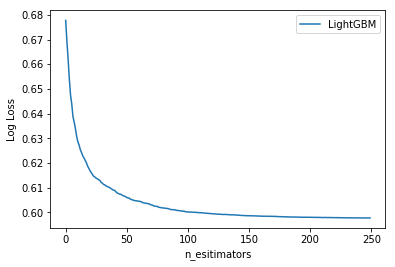

In [120]:
logloss = pd.DataFrame(list(model_lightgbm3.evals_result_.values())[0]['binary_logloss']).reset_index()

plt.plot(logloss.iloc[:, 0], logloss.iloc[:, 1], label = 'LightGBM')

plt.legend()
plt.xlabel('n_esitimators')
plt.ylabel('Log Loss')
plt.savefig("C:\\Users\\lenovo\\Downloads\\Thesis\\code1\\logloss2.png", dpi = 200, bbox_inches = 'tight')
plt.show();

In [126]:
df = pd.read_csv("C:\\Users\\lenovo\\Downloads\\Thesis\\data huawei\\propressed_data\\sampled_data2.csv", sep = ',')
df2 = df.drop(['uid', 'communication_onlinerate', 'up_membership_grade'], axis = 1, inplace = False)

X = df2.drop(['label'], axis = 1).copy()
y = df2['label'].copy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.25)

model_lightgbm4 = lgb.LGBMClassifier(seed = 42, objective = 'binary', learning_rate = 0.1, num_leaves = 100, max_depth = 7, n_estimators = 350, reg_alpha = 10, reg_lamda = 0.1)
start_time = timer(None)
model_lightgbm4.fit(X_train2, y_train2, verbose = True, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = [(X_test2, y_test2)])
timer(start_time)

[LightGBM] [Warning] Unknown parameter: reg_lamda
[1]	valid_0's binary_logloss: 0.683984
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.676538
[3]	valid_0's binary_logloss: 0.670367
[4]	valid_0's binary_logloss: 0.665254
[5]	valid_0's binary_logloss: 0.660696
[6]	valid_0's binary_logloss: 0.656773
[7]	valid_0's binary_logloss: 0.653268
[8]	valid_0's binary_logloss: 0.650292
[9]	valid_0's binary_logloss: 0.647911
[10]	valid_0's binary_logloss: 0.645689
[11]	valid_0's binary_logloss: 0.643612
[12]	valid_0's binary_logloss: 0.641996
[13]	valid_0's binary_logloss: 0.640345
[14]	valid_0's binary_logloss: 0.639108
[15]	valid_0's binary_logloss: 0.637503
[16]	valid_0's binary_logloss: 0.636471
[17]	valid_0's binary_logloss: 0.63524
[18]	valid_0's binary_logloss: 0.634375
[19]	valid_0's binary_logloss: 0.633657
[20]	valid_0's binary_logloss: 0.632887
[21]	valid_0's binary_logloss: 0.632189
[22]	valid_0's binary_logloss: 0.63148
[23]	valid_0's binar

[203]	valid_0's binary_logloss: 0.611442
[204]	valid_0's binary_logloss: 0.611423
[205]	valid_0's binary_logloss: 0.611416
[206]	valid_0's binary_logloss: 0.611364
[207]	valid_0's binary_logloss: 0.611357
[208]	valid_0's binary_logloss: 0.611354
[209]	valid_0's binary_logloss: 0.611307
[210]	valid_0's binary_logloss: 0.611287
[211]	valid_0's binary_logloss: 0.611241
[212]	valid_0's binary_logloss: 0.611228
[213]	valid_0's binary_logloss: 0.611227
[214]	valid_0's binary_logloss: 0.611235
[215]	valid_0's binary_logloss: 0.611217
[216]	valid_0's binary_logloss: 0.611221
[217]	valid_0's binary_logloss: 0.611204
[218]	valid_0's binary_logloss: 0.611199
[219]	valid_0's binary_logloss: 0.611126
[220]	valid_0's binary_logloss: 0.611088
[221]	valid_0's binary_logloss: 0.611088
[222]	valid_0's binary_logloss: 0.611094
[223]	valid_0's binary_logloss: 0.611086
[224]	valid_0's binary_logloss: 0.611087
[225]	valid_0's binary_logloss: 0.611038
[226]	valid_0's binary_logloss: 0.611046
[227]	valid_0's 

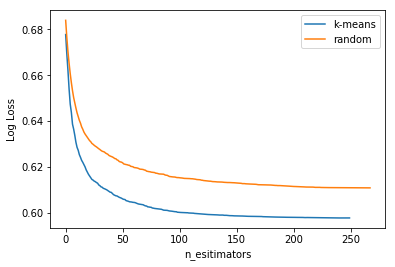

In [127]:
logloss = pd.DataFrame(list(model_lightgbm3.evals_result_.values())[0]['binary_logloss']).reset_index()
logloss2 = pd.DataFrame(list(model_lightgbm4.evals_result_.values())[0]['binary_logloss']).reset_index()

plt.plot(logloss.iloc[:, 0], logloss.iloc[:, 1], label = 'k-means')
plt.plot(logloss2.iloc[:, 0], logloss2.iloc[:, 1], label = 'random')

plt.legend()
plt.xlabel('n_esitimators')
plt.ylabel('Log Loss')
plt.savefig("C:\\Users\\lenovo\\Downloads\\Thesis\\code1\\logloss3.png", dpi = 200, bbox_inches = 'tight')
plt.show();

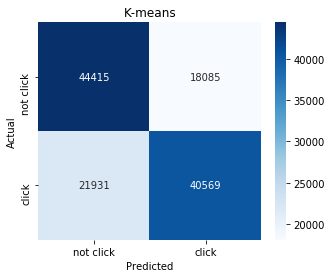

In [128]:
y_pred = model_lightgbm3.predict(X_test)
array = confusion_matrix(y_test, y_pred)
df_con = pd.DataFrame(array, index = ['not click', 'click'], columns = ['not click', 'click'])
plt.figure(figsize = (5, 4))
sn.heatmap(df_con, annot = True, cmap = 'Blues', fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-means')
plt.savefig("C:\\Users\\lenovo\\Downloads\\Thesis\\code1\\confusion_lightgbm_logloss2.png", dpi = 200, bbox_inches = 'tight')
plt.show()

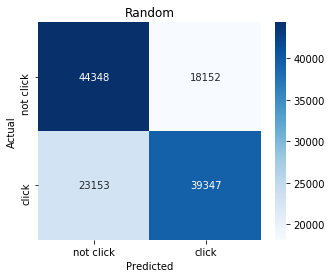

In [129]:
y_pred2 = model_lightgbm4.predict(X_test2)
array = confusion_matrix(y_test2, y_pred2)
df_con = pd.DataFrame(array, index = ['not click', 'click'], columns = ['not click', 'click'])
plt.figure(figsize = (5, 4))
sn.heatmap(df_con, annot = True, cmap = 'Blues', fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random')
plt.savefig("C:\\Users\\lenovo\\Downloads\\Thesis\\code1\\confusion_lightgbm_logloss3.png", dpi = 200, bbox_inches = 'tight')
plt.show()

In [123]:
from sklearn.metrics import f1_score

In [124]:
y_pred = model_lightgbm3.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69     62500
           1       0.69      0.65      0.67     62500

    accuracy                           0.68    125000
   macro avg       0.68      0.68      0.68    125000
weighted avg       0.68      0.68      0.68    125000

0.679872
0.6916663825144065
0.649104
0.6697096257655546


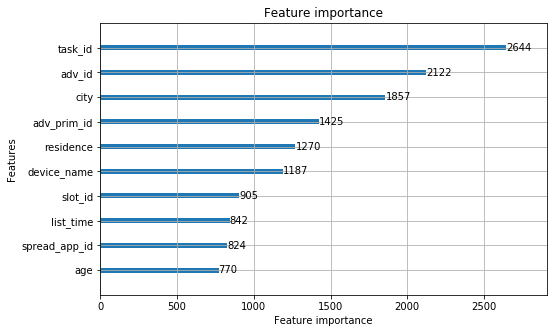

In [130]:
# lightgbm2 logloss
lgb.plot_importance(model_lightgbm3, max_num_features = 10, figsize = (8, 5))
plt.savefig("C://Users//lenovo//Downloads//Thesis//code1/importance2.png", dpi = 200, bbox_inches = 'tight')
plt.show()